## Classifying binary black holes from Population III stars with the Einstein Telescope: A machine-learning approach

This notebook contains the code to reproduce the results and all the figures of [Santoliquido et al., 2024](https://ui.adsabs.harvard.edu/abs/2024A%26A...690A.362S/abstract)


In [1]:
# importing libraries 
import pandas as pd 

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np 
import matplotlib.pyplot as plt
import os
import h5py
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.ticker
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

import corner
import matplotlib.lines as mlines
from tqdm import tqdm

# MACHINE LEARNING CLASSIFIER
from sklearn.model_selection import train_test_split
import seaborn as sns

# metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc

# resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# optimisation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
# XGboost
from xgboost import XGBClassifier
from xgboost import plot_importance

from corels import *
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

from matplotlib.colors import LogNorm
from astropy.cosmology import z_at_value
from astropy.cosmology import Planck18 
import astropy.units as u

from matplotlib import cm
from matplotlib.colors import Normalize

from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

#from scipy import stats
from scipy.stats import loguniform
from scipy.stats import uniform

from scipy.stats import gaussian_kde

In [3]:
# this string is to select posterior samples obtained with physical priors
FinalStatement = 'WithPhysicalPriors'

In [4]:
# set same font value for all the figures
font_value = 18
plt.rcParams.update({'font.size': font_value})

In [5]:
# set where to find locally to data processed with GWFish
path_local = ''

# error labels
lbs_errors = ['network_SNR', 'mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 
     'theta_jn', 'psi', 'geocent_time', 'phase', 'redshift', 'err_mass_1',
        'err_mass_2', 'err_luminosity_distance', 'err_dec', 'err_ra', 'err_theta_jn',
            'err_psi', 'err_geocent_time', 'err_phase', 'err_sky_location']

In [6]:
# select where to save all the results
folder_out = 'clf_plots_v9/'

In [7]:
class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [8]:
# here you need to clean the code...

def xgboost_on_BBH(X_train, X_test, y_train, y_test, Pop_model, cut_on_rel, priors):
    """
    This function trains the XGBoost classifier using the provided dataset. 
    Optimization is performed automatically if it has not already been done.
    
    Parameters:
    - X_train: Dataset of features for training.
    - X_test: Dataset of features for testing.
    - y_train: Target variables for the training set.
    - y_test: Target variables for the test set.
    - Pop_model: Indicates the population model.
    - cut_on_rel: Specifies the cut to apply on relative errors.
    - priors: A string used to save the results.

    Returns:
    - XGBoost classifier.
    """
    
    # read hyperparameters
    path_to_hyper = folder_out+'hyperparam_'+Pop_model+'_'+str(cut_on_rel)+'_'+str(priors)+'.txt'
    if os.path.exists(path_to_hyper) == True:
        print('... optimization already done')
        hyper = pd.read_csv(path_to_hyper, index_col=0)
        print(hyper)
        
    else:
        # here I run optimisation
        print('... optimizing the classifier')
        
        # a list of relevant hyperparameters
        # here I define ranges from which to sample
        # learning rate
        learning_rate = uniform(0, 0.1) 
        # Maximum number of levels in tree
        max_depth = loguniform_int(2, 15)
        # gamma
        gamma = uniform(0, 3) 
        
        # Create the random grid
        random_grid = {#'n_estimators': n_estimators,
                       'learning_rate': learning_rate,
                       'max_depth': max_depth,
                       'gamma': gamma
                        }
    
        # Use the random grid to search for best hyperparameters
        # First create the base model to tune
        clf = XGBClassifier(seed = 42, 
                            objective = 'binary:logistic',
                            n_estimators= 800,
                            early_stopping_rounds=5,
                            eval_metric = 'logloss')
        # Random search of parameters, using 3 fold cross validation, 
        # search across 100 different combinations, and use all available cores
        clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, 
                                        n_iter = 100, cv = 3, verbose=1,
                                        random_state=42, n_jobs = 10,
                                        scoring = 'precision')
        
        # Fit the random search model
        clf_random.fit(X_train, y_train,
                    verbose = False, 
                    eval_set = [(X_train, y_train), (X_test, y_test)])
        # take best parameters
        print('adopted hyperparameters for training the XGBoost')
        print(clf_random.best_params_)
        
        # save the selected hyperparameters
        hyper = pd.DataFrame(data = clf_random.best_params_, index=[0])
        hyper.to_csv(folder_out+'hyperparam_'+Pop_model+'_'+str(cut_on_rel)+'_'+str(priors)+'.txt')


    # let's build the XGBoost model
    # optimisation has been already done 
    xgb_clf = XGBClassifier(
                #subsample = hyper['subsample'].values[0],
                max_depth = hyper['max_depth'].values[0],
                learning_rate = hyper['learning_rate'].values[0],
                gamma = hyper['gamma'].values[0],
                seed = 42,
                objective= 'binary:logistic', 
                n_estimators= 800,
                n_jobs = 2,
                early_stopping_rounds=5,
                eval_metric = 'logloss'
                #eval_metric = 'error'
                )
        
    # fit model
    xgb_clf.fit(X_train, y_train,
              verbose = False, 
              eval_set = [(X_train, y_train), (X_test, y_test)]
              )
    
    # save the model 
    xgb_clf.save_model(folder_out+'/xgb_model_'+Pop_model+'_'+str(cut_on_rel)+'_'+str(priors)+'.json')


    # cross validation
    print('cross validation')
    f, axes = plt.subplots(1, 1, figsize=(6.5, 4.5))
    FOLDS = 5
    # stratification is not important, classes are almost balanaced
    k_fold = KFold(n_splits=FOLDS, shuffle=True,random_state=42)
    y_real = []
    y_proba = []
    
    # Normalize the values to be between 0 and 1
    data_fold = np.arange(FOLDS)
    norm = Normalize(vmin=data_fold.min(), vmax=data_fold.max())
   
    viridis_cmap = mpl.colormaps['viridis']
    # Map the values in the array to colors
    colors = viridis_cmap(norm(data_fold))[::-1]
    style = ['solid', 'solid', 'solid', 'solid', 'solid']
    auc_arr = []
    for i, (train_index, test_index) in enumerate(k_fold.split(X_train)):
        Xtrain_c, Xtest_c = X_train[train_index], X_train[test_index]
        ytrain_c, ytest_c = y_train[train_index], y_train[test_index]
        xgb_clf.fit(Xtrain_c, ytrain_c, 
                    verbose = False,
                   eval_set = [(Xtrain_c, ytrain_c), (X_test, y_test)])
        pred_proba = xgb_clf.predict_proba(X_test)
        precision, recall, thresholds = precision_recall_curve(y_test, pred_proba[:,1])
        #print(thresholds)
        #lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision))
        lab = 'fold %d, F1=%.2f' % (i+1, f1_score(y_test, xgb_clf.predict(X_test)))
        #f1_score(y_test, model.predict(X_test))
        auc_arr.append(auc(recall, precision))
        
        axes.step(recall, precision, label=lab, color = colors[i], lw = 2, linestyle = style[i])
        ind_thr = np.argmin(np.abs(thresholds - 0.5))
        print('selected threshold to plot ',thresholds[ind_thr])
        axes.plot(recall[ind_thr], precision[ind_thr],color = colors[i],lw = 0, marker = 's', markersize = 5)
        y_real.append(y_test)
        y_proba.append(pred_proba[:,1])

    axes.plot(0.5, -1,color = 'black',lw = 0, marker = 's', markersize = 7, label = 'threshold = 0.5')
    ###it can also plot the precision-recall curve of the entire training set
    #print('average AUC = ', round(np.mean(auc_arr),4), '\pm', round(np.std(auc_arr),4))
    #y_real = np.concatenate(y_real)
    #y_proba = np.concatenate(y_proba)
    #precision, recall, _ = precision_recall_curve(y_real, y_proba)
    #lab = 'Overall AUC=%.4f' % (auc(recall, precision))
    #axes.step(recall, precision, label=lab, lw=3, color='black')
    axes.set_xlabel('Recall')
    axes.set_ylabel('Precision')
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='random guess', color = 'red', lw = 2)
    axes.legend(loc = 'center')#, fontsize = font_value/1.2)
    if Pop_model == 'fiducial':
        title_here = Pop_model+r' balanced'
    elif Pop_model == 'pessimistic':
        title_here = Pop_model+r' balanced'
    elif Pop_model == 'optimistic':
        title_here = Pop_model+r' balanced'
    axes.set_title(title_here)
    axes.set_ylim([no_skill-0.02,1+0.02])
    plt.savefig(folder_out+'precision_recall_KFold_'+Pop_model+'_'+str(cut_on_rel)+'_'+str(priors)+'.pdf', 
                format = 'pdf', bbox_inches = 'tight')
    plt.show()
    
    return xgb_clf

In [9]:
# error labels after applying priors
lbs_r = ['network_SNR', 
                        'mass_1', 
                        'mass_2', 
                        'luminosity_distance', 
                        'dec', 
                        'ra', 
                        'theta_jn', 
                        'psi', 
                        'geocent_time', 
                        'phase', 
                        'redshift', 
                        'err_mass_1',
                        'err_mass_2', 
                        'err_luminosity_distance', 
                        'err_dec', 
                        'err_ra', 
                        'err_theta_jn',
                        'err_psi', 
                        'err_geocent_time', 
                        'err_phase', 
                        'err_sky_location',
                        'r_mass_1', 
                        'r_mass_2', 
                        'r_luminosity_distance', 
                        'r_dec', 
                        'r_ra', 
                        'r_theta_jn', 
                        'r_psi', 
                        'r_geocent_time', 
                        'r_phase']

In [10]:
def combine_all(Pop_model, cut_on_rel, priors):
    '''
    This function conducts the analysis on a balanced datasets.
    
    Parameters:
    - Pop_model: The selected BBH population model. 
                It can be 'pessimistic', 'fiducial', or 'optimistic' for Pop. III BBH. 
                For Pop. I-II, the 'fiducial' model is automatically selected.
    - cut_on_rel: A value between 0 and 1, representing the upper limit on relative error applied to all parameters.
    - priors: A boolean value. If True, training is conducted on true waveform parameters but only on sources that fulfill the cut. 
             If False, no cuts are taken into account.
    
    Returns:
    - pre: Precision on the test set with the classifier model.
    - indices_to_use: Instances used in the test set.
    '''
    
    # Corner plot with feature distributions used for training
    fig1 = plt.figure(figsize=(10,10))
    print('currently processing...', Pop_model, cut_on_rel, priors)
    
    fisher_matrix_code = 'GWFish'
    codes_leg = ['GWFish Pop. III', 'GWFish Pop. I-II']
    colors = ['blue', 'red']
    ls_codes = ['o', 's']
    models_fish = Pop_model
    psds = ['ET_cryo']
    # corner plot labels
    corner_lbs = [r'$m_{1,\mathrm{d}}$ [M$_\odot$]', 
                  r'$m_{2,\mathrm{d}}$ [M$_\odot$]',
                  r'$d_{\mathrm{L}}$ [Mpc]']

    # I apply a cut to keep a sample of well measured instances
    SNRth = 12
    thrs_m1 = cut_on_rel
    thrs_m2 = cut_on_rel
    thrs_L = cut_on_rel

    # corner plot arguments 
    CORNER_KWARGS = dict(
        smooth = 0.1, # smooths out contours. 
        plot_datapoints = False, # choose if you want datapoints
        label_kwargs = dict(fontsize = font_value), # font size for labels
        #show_titles = True, #choose if you want titles on top of densities.
        title_kwargs = dict(fontsize = font_value), # font size for title
        plot_density = True,
        title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
        levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
        fill_contours = True, #decide if you want to fill the contours
        #max_n_ticks = 2, # set a limit to ticks in the x-y axes.
        title_fmt=".3f",
        axes_scale='log'
        )

    for c, code_i in enumerate(codes_leg):
        print(code_i)
        if code_i == codes_leg[1]: 
            model_here = 'fiducial'
            model_meas = 'Pop.I'
            duration = '10'
        else:
            model_here = models_fish
            model_meas = 'Pop.III'
            if model_here == 'fiducial':
                duration = '1500'
            elif model_here == 'pessimistic':
                duration = '50000'
            elif model_here == 'optimistic':
                duration = '85'
                
        in_folder = path_local+code_i
        print('    ',model_here)
        psd = psds[0]
        print('    ',psd)            
        
        if (priors == True): 

            # load the pre-sampled catalogs
            path_to_file = 'measured_values_v1/meas_cat_'+model_meas+'_'+model_here+'_'+str(cut_on_rel)+'_'+duration+'yr_'+FinalStatement+'.dat'
            if os.path.exists(path_to_file) == True:
                new_data = pd.read_csv(path_to_file, names = lbs_r, 
                                       delimiter = ',', low_memory = False, skiprows = 1)
            else: 
                print(path_to_file)
                raise ValueError('presampled catalogs have not been found!')
            #print(new_data.keys())
            #print(len(np.array(new_data['network_SNR'])))
            
            # I need to reapply the cut
            # cut on SNR
            SNRs = np.array(new_data['network_SNR']) 
            r_ind_snr = np.nonzero(SNRs>SNRth)[0]
            #print('snr',len(r_ind_snr))
        
            # the indexing is different from the original data but this is not a problem 
            dm1 = np.array(new_data['err_mass_1'])
            dm2 = np.array(new_data['err_mass_2'])
            dL = np.array(new_data['err_luminosity_distance'])
            # load features
            m1 = np.array(new_data['mass_1'])
            m2 = np.array(new_data['mass_2'])
            L = np.array(new_data['luminosity_distance'])
            # here I apply the cuts on relative error
            r_ind_m1 = np.nonzero(dm1/m1 < thrs_m1)[0]
            #print('m1',len(r_ind_m1))
            r_ind_m2 = np.nonzero(dm2/m2 < thrs_m2)[0]
            #print('m2',len(r_ind_m2))
            r_ind_L = np.nonzero(dL/L < thrs_L)[0]
            #print('L',len(r_ind_L))
            r_ind_p = [r_ind_snr, r_ind_m1, r_ind_m2, r_ind_L]
            r_ea = list(set.intersection(*map(set, r_ind_p)))
            
            
            #print(r_ea)
            print('number of selected instances after resampling', len(r_ea))
            if len(r_ea) <= 1:
                print('There are no systems with this option. Exiting function')
                # precision is set to zero. Exit function
                pre = 0
                return pre

    
            ## load features --> these features are the new resampled max posteriors 
            #r_m1 = np.array(new_data['r_mass_1'].iloc[r_ea])
            #r_m2 = np.array(new_data['r_mass_2'].iloc[r_ea]) 
            #r_L = np.array(new_data['r_luminosity_distance'].iloc[r_ea])

            # load features --> these are the true injected values 
            print(' training is done on injected parameters!')
            path_to_file_kde = 'measured_values_v1/kde_cat_'+model_meas+'_'+model_here+'_'+str(cut_on_rel)+'_'+duration+'yr_'+FinalStatement+'.dat'
            if os.path.exists(path_to_file_kde) == True:
                samples = np.loadtxt(path_to_file_kde)
            else: 
                print('    ...taking KDE samples')
                r_m1_r = np.array(new_data['mass_1'].iloc[r_ea])
                r_m2_r = np.array(new_data['mass_2'].iloc[r_ea]) 
                r_L_r = np.array(new_data['luminosity_distance'].iloc[r_ea])
                # we have repeated objects in these data, I resample from a KDE
                r_data = np.transpose(np.stack([r_m1_r, r_m2_r, r_L_r], axis = 1))
                #print(r_data.shape) 
                kde = gaussian_kde(r_data, bw_method = 0.0015) # --> you can get negative values! I decreased the bw_method
                r_data_resampled = kde.resample(len(r_m1_r), seed = 42)
                #print(r_data_resampled)
                r_m1 = r_data_resampled[0,:]
                r_m2 = r_data_resampled[1,:]
                r_L = r_data_resampled[2,:]
                print('negative values while resampling KDE? - the code stops automatically if any')
                print(r_m1[r_m1<0])
                print(r_m2[r_m2<0])
                print(r_L[r_L<0])
                print('max redshift', np.max( np.array(new_data['redshift'].iloc[r_ea]) ))
                # and build the instances 
                samples = np.stack([r_m1, r_m2, r_L], axis = 1)   
                #print(samples)
                # I save resampling from the KDE
                np.savetxt(path_to_file_kde,samples)

        
        elif priors == False:

            path_to_file = 'true_parameters_v1/true_parameters_'+model_meas+'_'+model_here+'_'+duration+'yr.txt'
            if os.path.exists(path_to_file) == True:
                new_data = pd.read_csv(path_to_file, names = ['M1[Msun]', 'M2[Msun]', 'z_merg', 'Detected', 'TotalSNR', 'Theta_0', 'Theta_1', 'Theta_2'],
                                       delimiter = ' ', skiprows = 1)
            else: 
                print(path_to_file)
                raise ValueError('presampled catalogs have not been found!')


            # read features
            m1_src = new_data['M1[Msun]']
            m2_src = new_data['M2[Msun]']
            z = new_data['z_merg']

            if model_meas == 'Pop.III':
                # you can use the parameters in Signal_*.txt, you have the same problem of repeated entries,
                # you can solve it with a kde
                
                # I select a subsample instead on entire population made of >887_364 entries
                np.random.seed(42)
                ind_rnd = np.random.choice(np.arange(len(m1_src)), size = 20_000, replace = False)
                # load features
                r_m1 = m1_src.loc[ind_rnd]*(1+z.loc[ind_rnd])
                r_m2 = m2_src.loc[ind_rnd]*(1+z.loc[ind_rnd])
                r_L = Planck18.luminosity_distance(z.loc[ind_rnd])
                
            elif model_meas == 'Pop.I':
                np.random.seed(42)
                ind_rnd = np.random.choice(np.arange(len(m1_src)), size = 20_000, replace = False)
                # load features
                r_m1 = m1_src.loc[ind_rnd]*(1+z.loc[ind_rnd])
                r_m2 = m2_src.loc[ind_rnd]*(1+z.loc[ind_rnd])
                r_L = Planck18.luminosity_distance(z.loc[ind_rnd])
                #    # load features
                #    r_m1 = m1_src*(1+z)
                #    r_m2 = m2_src*(1+z)
                #    r_L = Planck18.luminosity_distance(z)
            
            # and build the instances 
            samples = np.stack([r_m1, r_m2, r_L], axis = 1)   
    

        
        corner.corner(samples, labels = corner_lbs, color = colors[c], **CORNER_KWARGS,                
                         bins = 40, fig = fig1) # number of bins for histograms)

        # save  for the two classes
        if code_i == codes_leg[0]: 
            samples_PopIII = samples
        elif code_i ==  codes_leg[1]: 
            samples_PopI = samples


    # plot the corner plot and save it
    blue_line = mlines.Line2D([], [], color='blue', label='Pop. III')
    red_line = mlines.Line2D([], [], color='red', label='Pop. I-II')
    plt.legend(handles=[blue_line,red_line], bbox_to_anchor=(0., 2.0, 1., .0), loc=4, fontsize = 16)
    for ax in fig1.get_axes():
        ax.tick_params(axis='both', labelsize=font_value)

    plt.savefig(folder_out+'corner_'+Pop_model+'_'+str(cut_on_rel)+'_'+str(priors)+'.pdf', 
                format = 'pdf', bbox_inches = 'tight')
    plt.show()

            
    # once the data frame are ready you can apply the classifing trees
    # select training and target features
    print('number of Pop I-II BBH (negative class) = ',samples_PopI.shape)
    print('number of Pop III BBH (positive class) = ', samples_PopIII.shape)
    
    X = np.vstack([samples_PopIII, samples_PopI])
    ratio = samples_PopI.shape[0]/samples_PopIII.shape[0]
    print('ratio  negative/positive class = ', ratio)
    print('percentage Pop I-II BBH:', samples_PopI.shape[0]/(samples_PopI.shape[0]+samples_PopIII.shape[0]))
    print('percentage Pop III BBH:', samples_PopIII.shape[0]/(samples_PopI.shape[0]+samples_PopIII.shape[0]))
    print('feature shape = ', X.shape)
    # minority class (Pop. III BBH) are set to one
    # majority class (Pop. I-II BBH) are set to zero 
    y = np.hstack([np.ones(len(samples_PopIII[:,0])), np.zeros(len(samples_PopI[:,0]))])
    print('target shape = ', y.shape)

    ## I made the two population perfectly balanced by increasing T_obs
    #rus = SMOTE(random_state=42)
    #X_res, y_res = rus.fit_resample(X, y)
    
    
    print('...bulding the training and test set')
    # let's build the train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size = 0.7, random_state = 42)
    #ind_X_train, ind_X_test, y_train, y_test = train_test_split(np.arange(X.shape[0]), y, stratify = y, train_size = 0.7, random_state = 42)
    #X_train = X[ind_X_train]
    #X_test = X[ind_X_test] 

    
    print('X_train shape = ', X_train.shape)
    print('X_test shape = ', X_test.shape)
    # take test instances in Pop. I-II to then apply posterior sample classification
    
    #indices_to_use = [index for index, element in enumerate(samples_PopI) if element in X_test[y_test == 0]]
    print('extracting Pop I indexes for subsequent testing')
    indices_to_use = []
    for index, element in enumerate(tqdm(samples_PopI)):
        for element2 in X_test[y_test == 0]:
            #if np.allclose(element,element2) == True:
            if element[0] == element2[0] and element[1] == element2[1] and element[2] == element2[2]:
                #print(element[0],element2[0])
                indices_to_use.append(index)
                break
    #indices_to_use = ind_X_test
    
    print('samples Pop I \n',np.sort(samples_PopI[indices_to_use], axis = 0))
    print('samples in X_test Pop I \n', np.sort(X_test[y_test == 0], axis = 0))
    print(len(indices_to_use))
    print(X_test[y_test == 0].shape[0])
    np.savetxt(folder_out+'indices_to_use_Pop.I_'+Pop_model+'_'+str(cut_on_rel)+'_'+str(priors)+'.txt', indices_to_use)
    
    ######## training the XGBoost 
    model = xgboost_on_BBH(X_train, X_test, y_train, y_test, Pop_model, cut_on_rel, priors)

    if Pop_model == 'fiducial':
        title_here = Pop_model+r' balanced'
    elif Pop_model == 'pessimistic':
        title_here = Pop_model+r' balanced'
    elif Pop_model == 'optimistic':
        title_here = Pop_model+r' balanced'

    ######## this figure checks if overfitting happened
    results_pruned = model.evals_result()
    plt.figure(figsize=(9,6))
    plt.plot(results_pruned['validation_0']['logloss'], label='train')
    plt.plot(results_pruned['validation_1']['logloss'], label='test')
    #plt.plot(results_pruned['validation_0']['error'], label='train')
    #plt.plot(results_pruned['validation_1']['error'], label='test')
    plt.legend()
    plt.ylim([0,1])
    plt.ylabel('logloss')
    plt.xlabel('$n$ estimators')
    plt.savefig(folder_out+'logloss_'+Pop_model+'_'+str(cut_on_rel)+'_'+str(priors)+'.pdf', 
                format = 'pdf', bbox_inches = 'tight')
    plt.show()
    
    ######## check model performance
    acc = accuracy_score(y_test,model.predict(X_test))
    print('accuracy score = ', acc)
    b_acc = balanced_accuracy_score(y_test,model.predict(X_test))
    print('balanced accuracy score = ', b_acc)
    rec = recall_score(y_test,model.predict(X_test))
    print('recall score = ', rec)
    f1 = f1_score(y_test, model.predict(X_test))
    print('f1 score = ', f1)
    pre = precision_score(y_test,model.predict(X_test))
    print('precision score = ', pre)
    data_performance = {
       'accuracy':[acc],
        'balanced_accuracy':[b_acc],
        'precision':[pre],
        'recall':[rec],
        'f1':[f1]
    }
    data_perf = pd.DataFrame(data = data_performance)
    data_perf.to_csv(folder_out+'performance_'+Pop_model+'_'+str(cut_on_rel)+'_'+str(priors)+'.txt')

    
    ######## confusion matrix
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_test, model.predict(X_test), normalize='all'),
                cmap='Blues', annot=True, fmt = '.2f', ax = ax, vmin = 0, vmax = 0.5)
    # Add extrema values to the colorbar
    # Modify colorbar ticks
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    ax.set_xlabel('Predicted labels', fontsize = font_value)
    ax.set_ylabel('True labels', fontsize = font_value)
    ax.xaxis.set_ticklabels(['Pop. I-II', 'Pop. III'], fontsize = font_value )
    ax.yaxis.set_ticklabels(['Pop. I-II', 'Pop. III'], fontsize = font_value)
    ax.set_title(title_here)
    plt.savefig(folder_out+'conf_matrix_'+Pop_model+'_'+str(cut_on_rel)+'_'+str(priors)+'.pdf', 
                format = 'pdf', bbox_inches = 'tight')
    plt.show()

    ######## ROC 
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure(figsize=(9,6))
    plt.plot(fpr, tpr, label='ROC curve - XGBoost')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.xlim([-0.02, 1])
    plt.ylim([0, 1.02])
    plt.legend(loc="lower right")
    plt.savefig(folder_out+'ROC_'+Pop_model+'_'+str(cut_on_rel)+'_'+str(priors)+'.pdf', 
                format = 'pdf', bbox_inches = 'tight')
    plt.show()

    

    ######## precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure(figsize=(9,6))
    plt.plot(recall, precision, marker = '.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    # number of positive examples over the total number of data
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.ylim([no_skill-0.05,1+0.01])
    plt.legend()
    plt.savefig(folder_out+'precision_recall_'+Pop_model+'_'+str(cut_on_rel)+'_'+str(priors)+'.pdf', 
                format = 'pdf', bbox_inches = 'tight')
    plt.show()

    ######## calibration curve
    prob_true_curve, prob_pred_curve = calibration_curve(y_test, model.predict_proba(X_test)[:,1], n_bins=10)
    plt.plot(prob_pred_curve,prob_true_curve, label = 'XGBoost balanced', lw = 1, marker = 'o',
            markersize = 5)
    plt.xlabel('mean predicted probabilities')
    plt.ylabel('fraction of true positives')
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), label = 'perfectly calibrated')
    plt.legend()
    plt.show()

    ###### MANUAL CLASSIFIER ####
    print('manual classification!')

    # I want to implement a more sophisticated searcher for manual bounds
    m1_thrs = np.logspace(np.log10(int(min(X_test[:,0]))),
                        np.log10(int(max(X_test[:,0]))),
                        1000)
    #print(dl_thrs)

    f1_man_search = np.zeros((len(m1_thrs)))
    for i_m1, m1_thr_i in (enumerate(tqdm(m1_thrs))):
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        for i_y in range(len(y_train)):
            # simple step function
            if (X_train[i_y,0] > m1_thr_i):
                #X_test_pred[i_y] = 1
                if y_train[i_y] == 1:
                    TP += 1
                else:
                    FP += 1
            else:
                #X_test_pred[i_y] = 0
                if y_train[i_y] == 0:
                    TN += 1
                else:
                    FN += 1
                    
        f1_man_search[i_m1] = 2*TP/(2*TP+FP+FN)

    #print(f1_man_search)
    min_ind = np.unravel_index(np.argmax(f1_man_search), 
                               f1_man_search.shape)
    #print('found value = ', min_ind)
    #print('f1 score on train = ',f1_man_search[min_ind])
    
    
    print('m1_thrs = ', m1_thrs[min_ind[0]])

    X_test_pred_s = np.zeros(len(y_test))
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i_y in range(len(y_test)):
        if (X_test[i_y,0] > m1_thrs[min_ind[0]]):
            X_test_pred_s[i_y] = 1
            if y_test[i_y] == 1:
                TP += 1
            else:
                FP += 1
        else:
            X_test_pred_s[i_y] = 0
            #X_test_pred[i_y] = 0
            if y_test[i_y] == 0:
                TN += 1
            else:
                FN += 1
    f1_test = 2*TP/(2*TP+FP+FN)
    print('f1 score on test = ', f1_test)
    # this is the confusion matrix
    fig, ax = plt.subplots(figsize=(4,4))
    image = sns.heatmap(confusion_matrix(y_test, X_test_pred_s,normalize='all'),
                cmap="OrRd", annot=True, fmt = '.2f', ax = ax, vmin = 0, vmax = 0.5)
    # Add extrema values to the colorbar
    # Modify colorbar ticks
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

    ax.set_xlabel('Predicted labels', fontsize = font_value)
    ax.set_ylabel('True labels', fontsize = font_value)
    ax.xaxis.set_ticklabels(['Pop. I-II', 'Pop. III'], fontsize = font_value )
    ax.yaxis.set_ticklabels(['Pop. I-II', 'Pop. III'], fontsize = font_value)
    ax.set_title(title_here)
    plt.savefig(folder_out+'conf_matrix_manual_'+Pop_model+'_'+str(cut_on_rel)+'_'+str(priors)+'.pdf', 
                format = 'pdf', bbox_inches = 'tight')
    plt.show()
    
    return pre, indices_to_use

fiducial
currently processing... fiducial 0.3 True
GWFish Pop. III
     fiducial
     ET_cryo
number of selected instances after resampling 11397
 training is done on injected parameters!
GWFish Pop. I-II
     fiducial
     ET_cryo
number of selected instances after resampling 11397
 training is done on injected parameters!


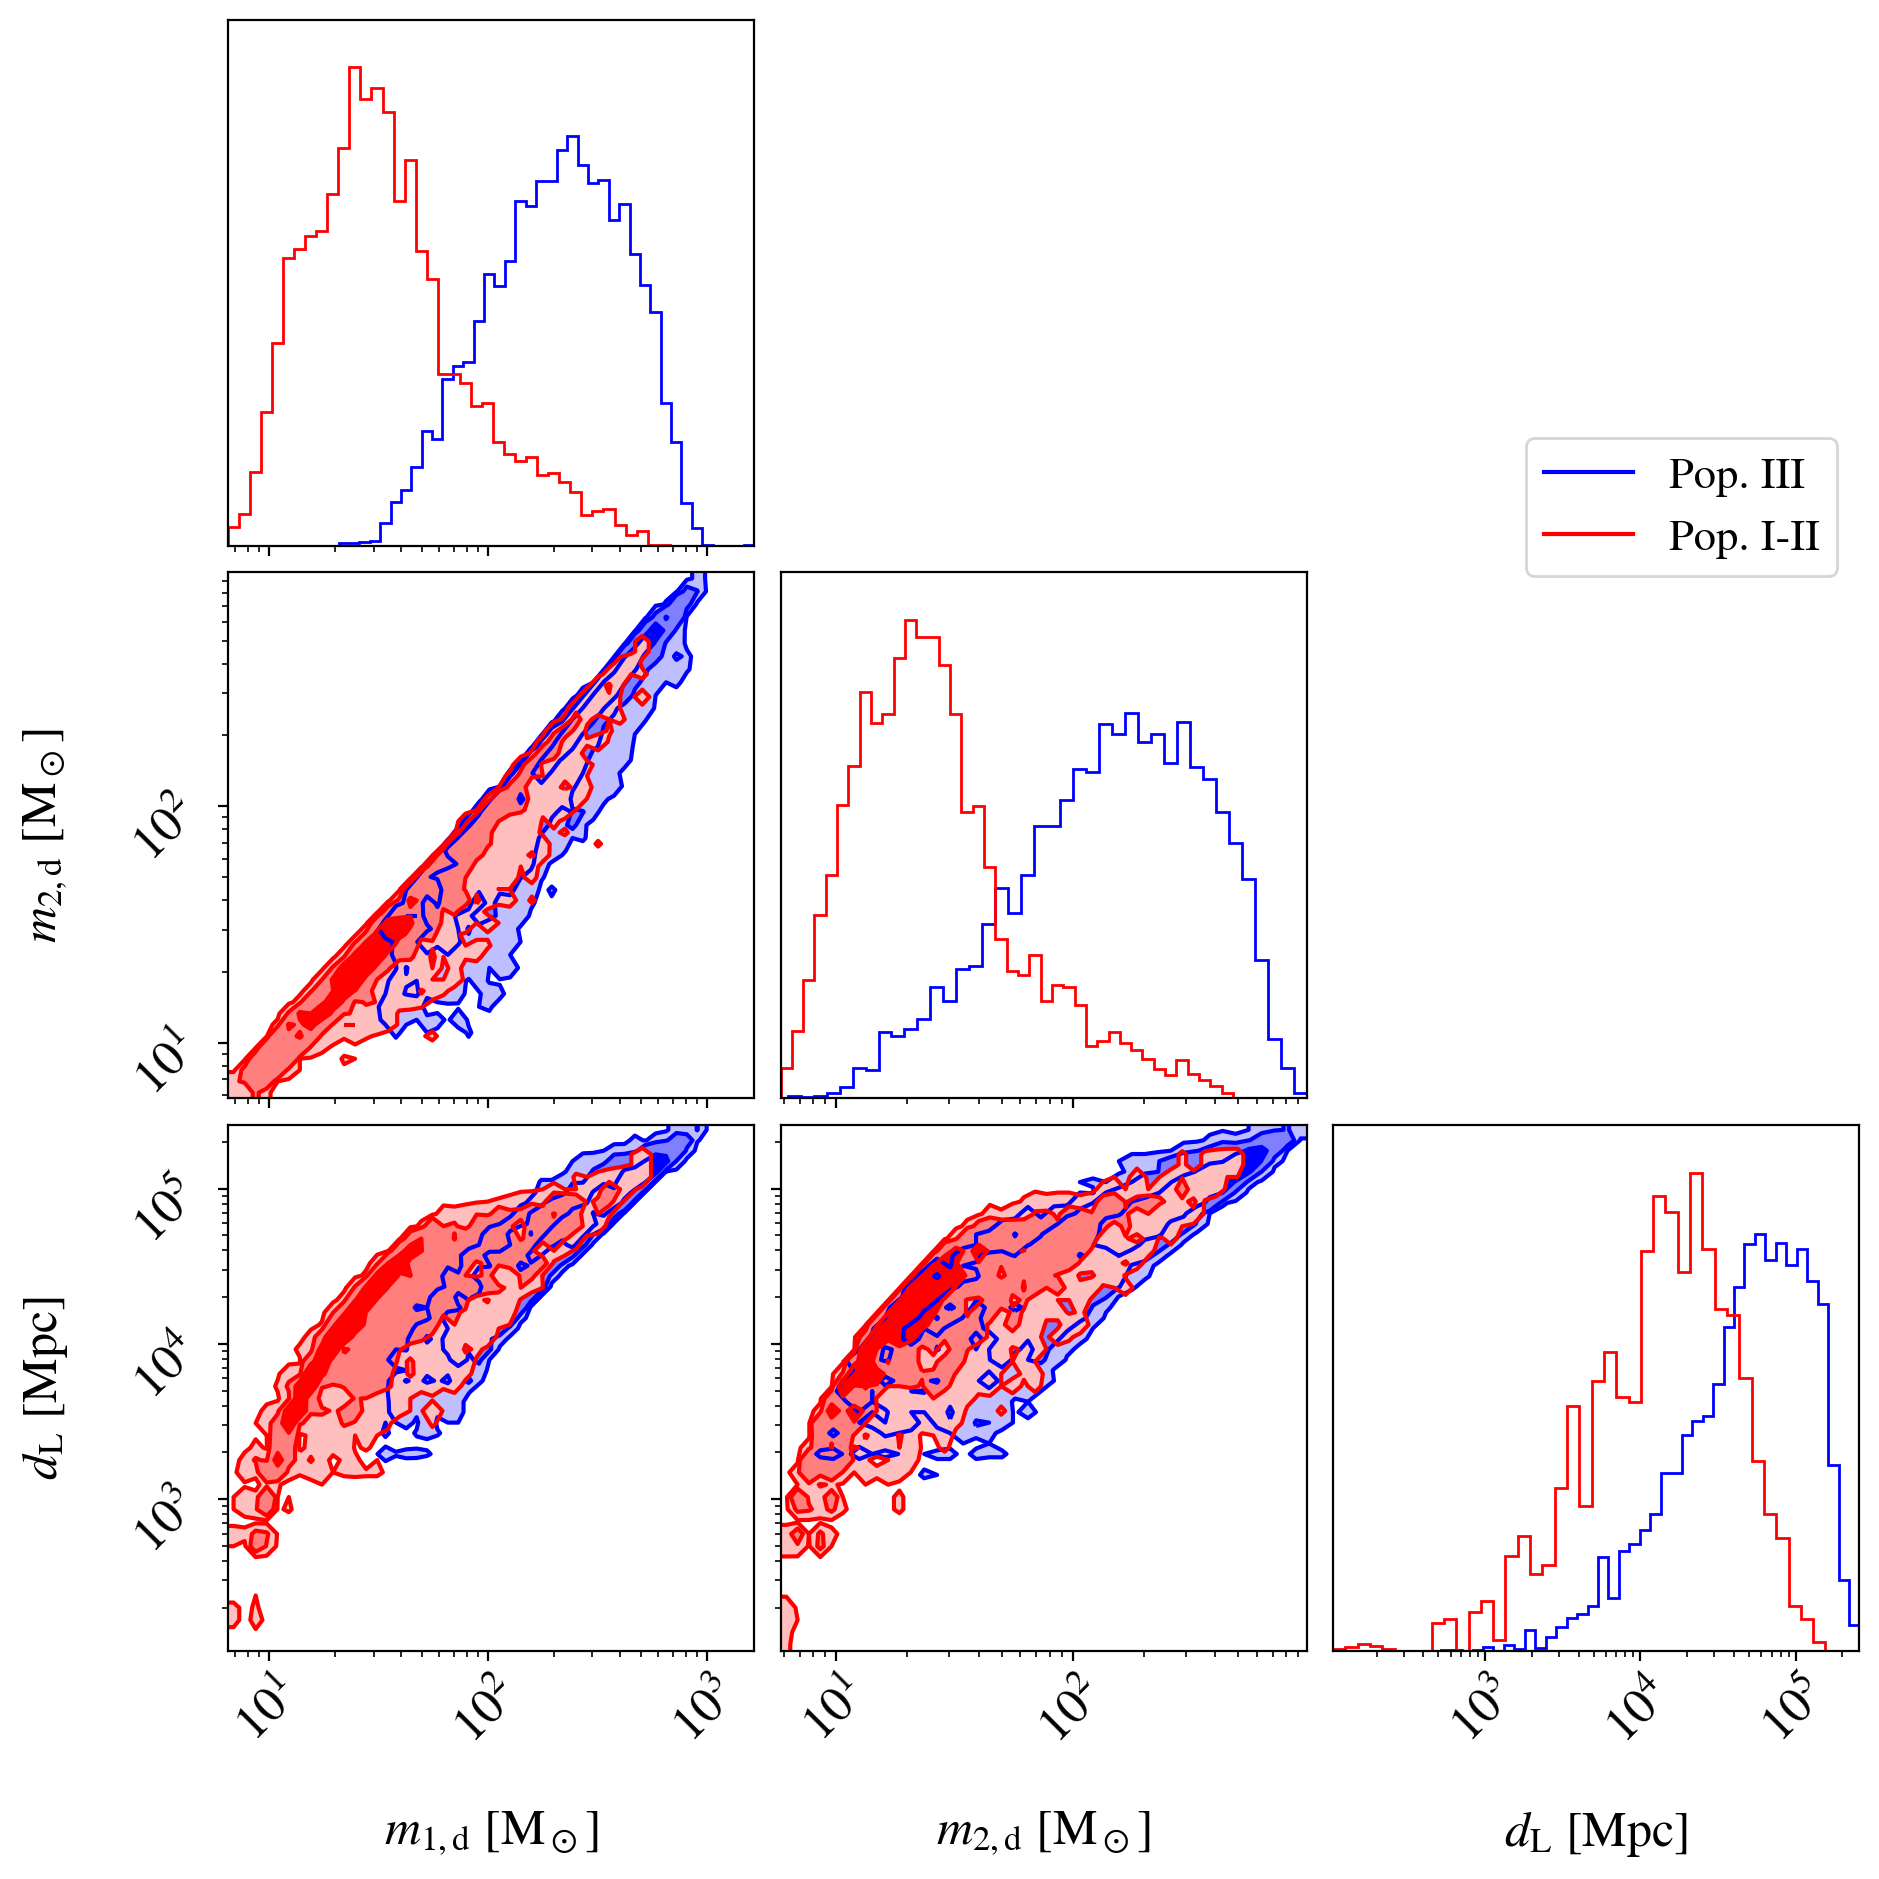

number of Pop I-II BBH (negative class) =  (11397, 3)
number of Pop III BBH (positive class) =  (11397, 3)
ratio  negative/positive class =  1.0
percentage Pop I-II BBH: 0.5
percentage Pop III BBH: 0.5
feature shape =  (22794, 3)
target shape =  (22794,)
...bulding the training and test set
X_train shape =  (15955, 3)
X_test shape =  (6839, 3)
extracting Pop I indexes for subsequent testing


100%|███████████████████████████████████| 11397/11397 [00:08<00:00, 1385.99it/s]


samples Pop I 
 [[6.46737991e+00 5.81398112e+00 1.04977587e+02]
 [6.55937047e+00 5.93815077e+00 1.12931481e+02]
 [6.59783417e+00 6.04068109e+00 1.38179253e+02]
 ...
 [5.04188577e+02 4.21022051e+02 1.40678537e+05]
 [5.06806773e+02 4.24935735e+02 1.40737246e+05]
 [5.34224073e+02 4.58795445e+02 1.40744140e+05]]
samples in X_test Pop I 
 [[6.46737991e+00 5.81398112e+00 1.04977587e+02]
 [6.55937047e+00 5.93815077e+00 1.12931481e+02]
 [6.59783417e+00 6.04068109e+00 1.38179253e+02]
 ...
 [5.04188577e+02 4.21022051e+02 1.40678537e+05]
 [5.06806773e+02 4.24935735e+02 1.40737246e+05]
 [5.34224073e+02 4.58795445e+02 1.40744140e+05]]
3420
3420
... optimization already done
      gamma  learning_rate  max_depth
0  0.359596       0.033762         13
cross validation
selected threshold to plot  0.4996482
selected threshold to plot  0.5007665
selected threshold to plot  0.5000427
selected threshold to plot  0.50049704
selected threshold to plot  0.49991193


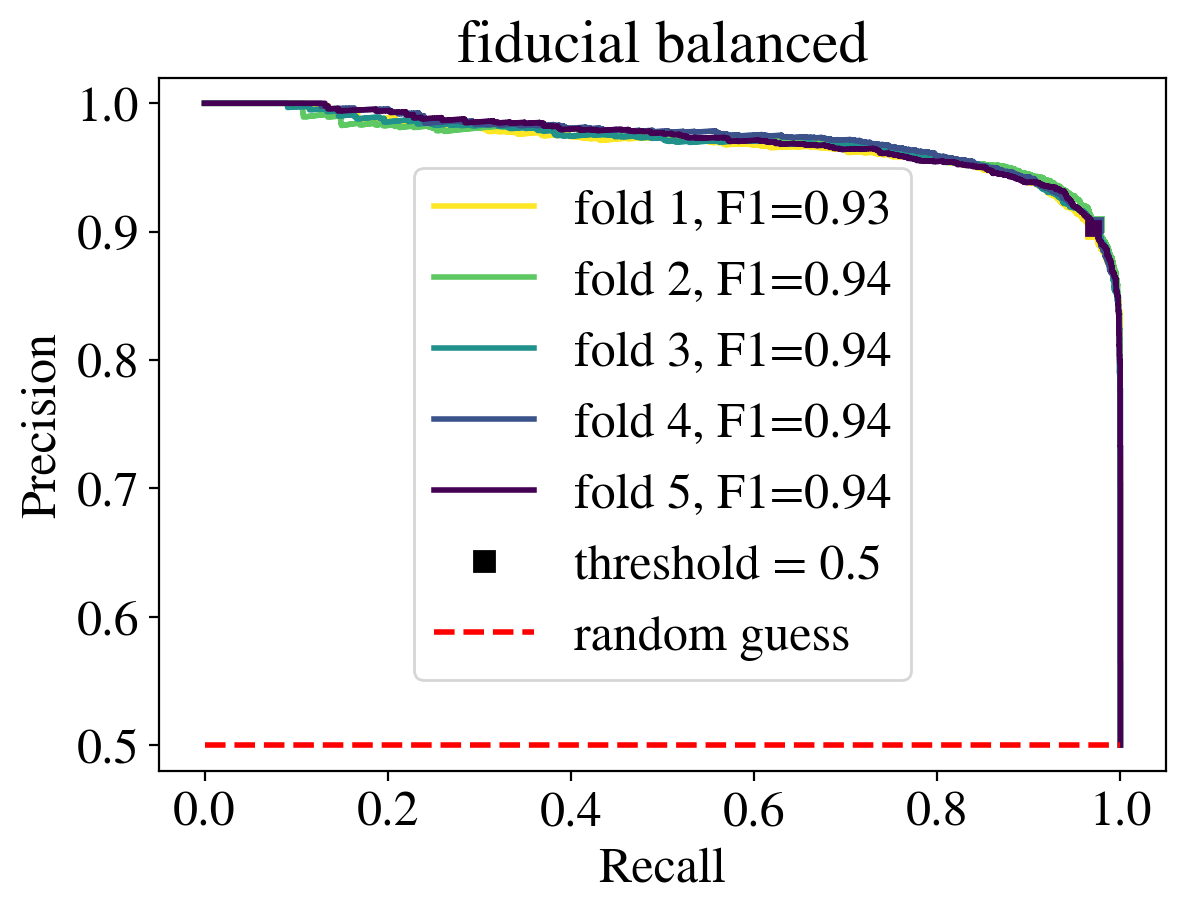

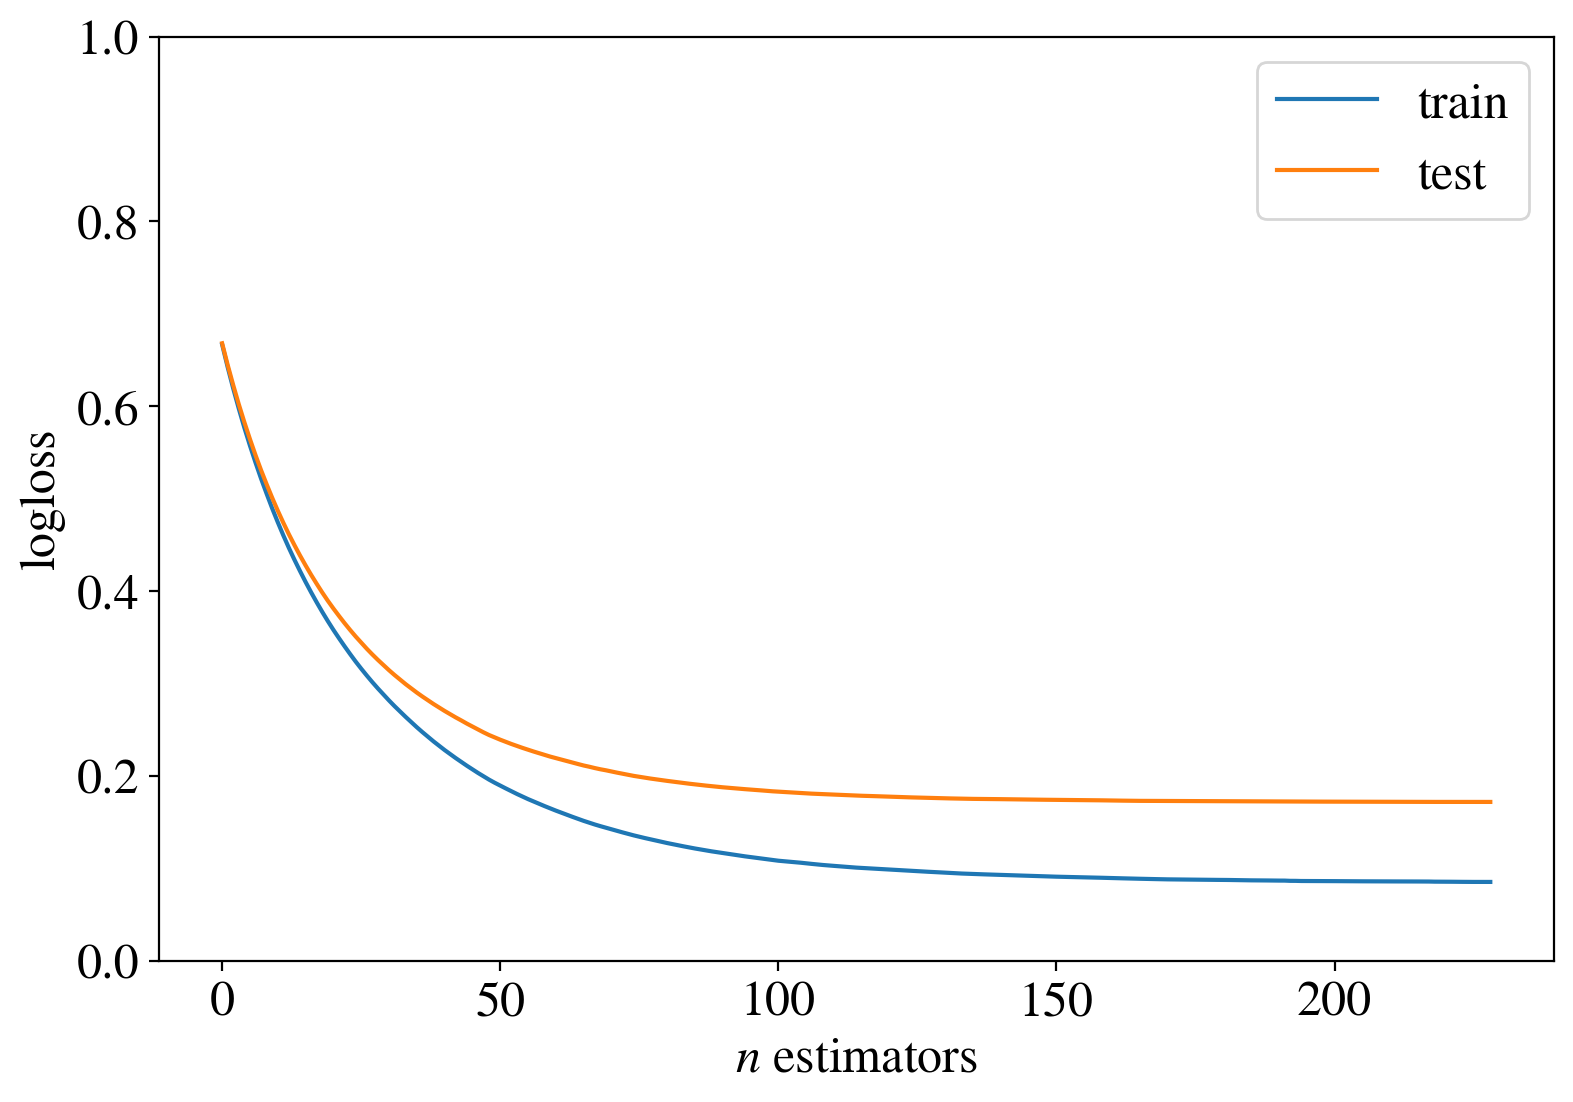

accuracy score =  0.9327387044889603
balanced accuracy score =  0.932744133659683
recall score =  0.9698742322316467
f1 score =  0.9351381838691485
precision score =  0.9028042472093657


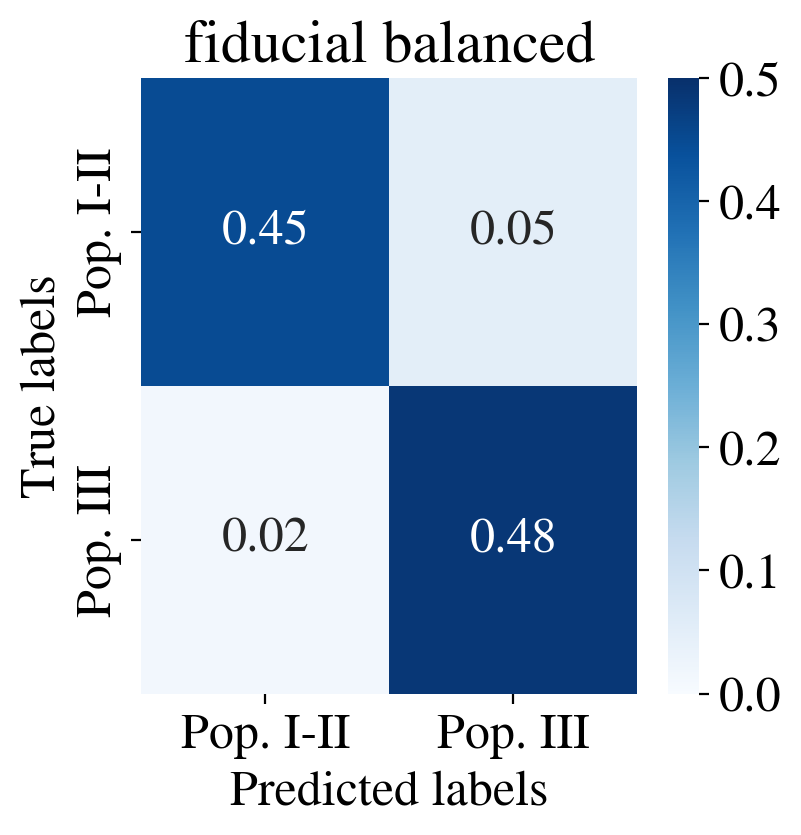

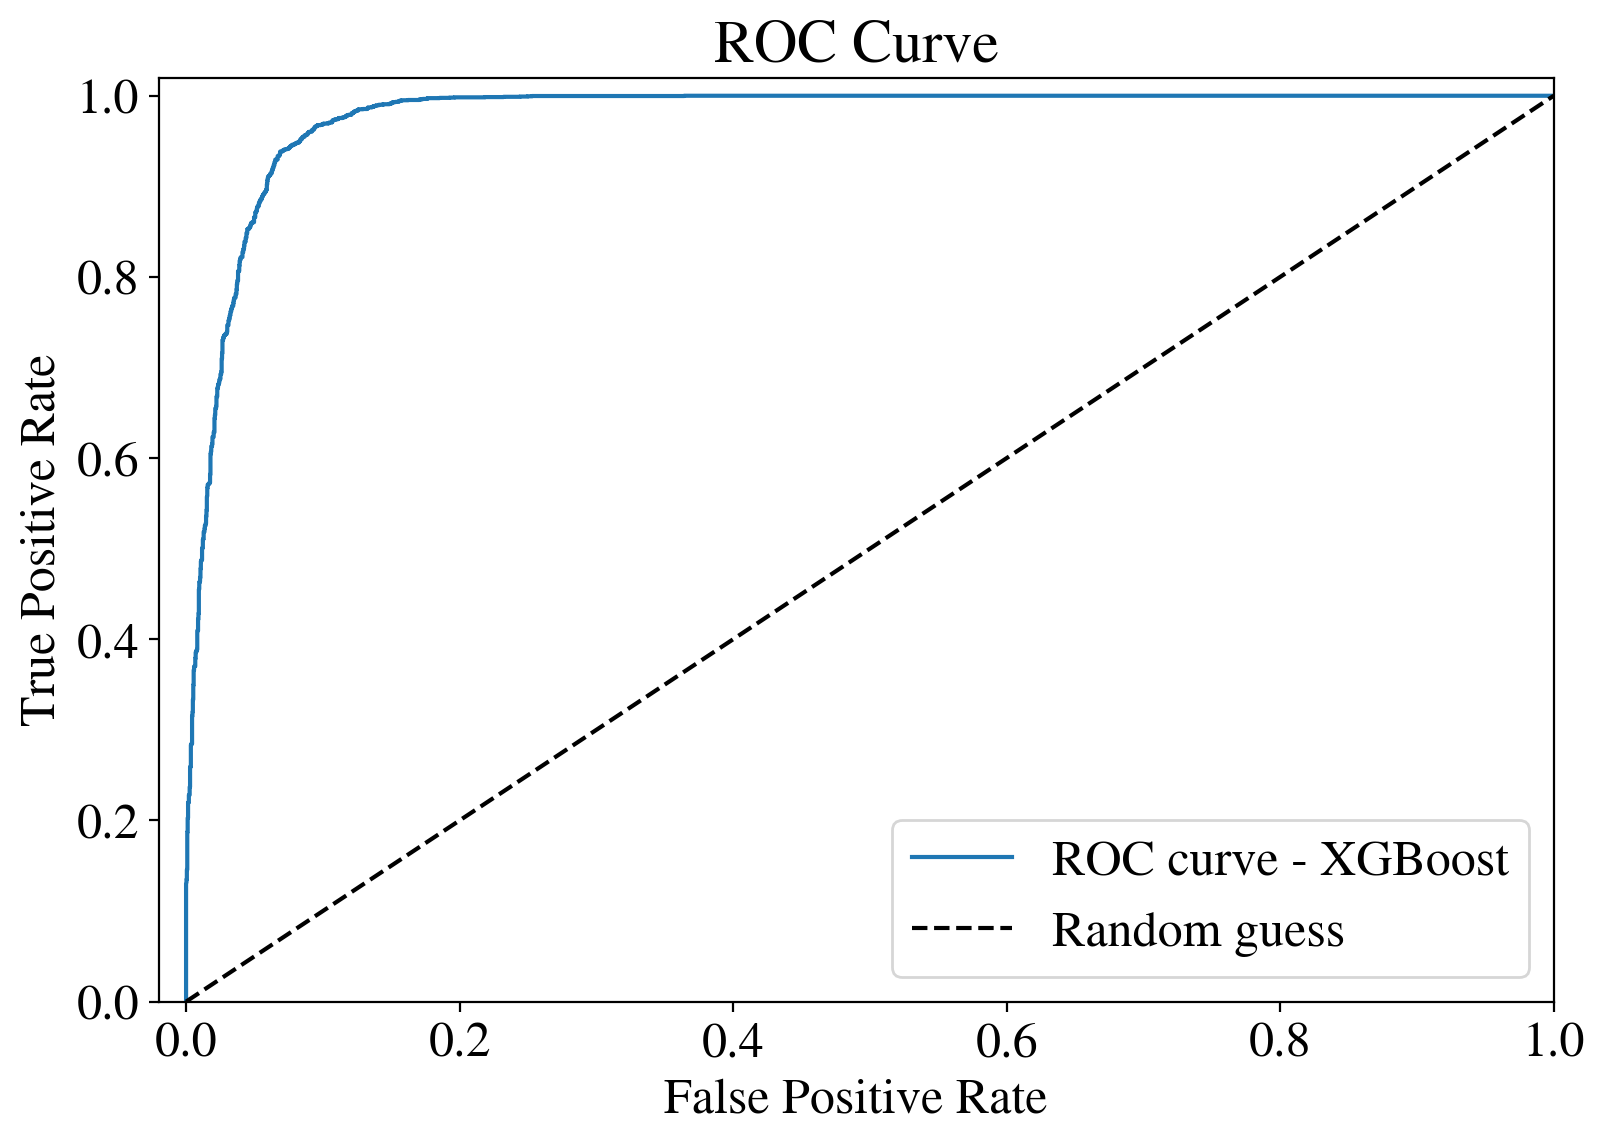

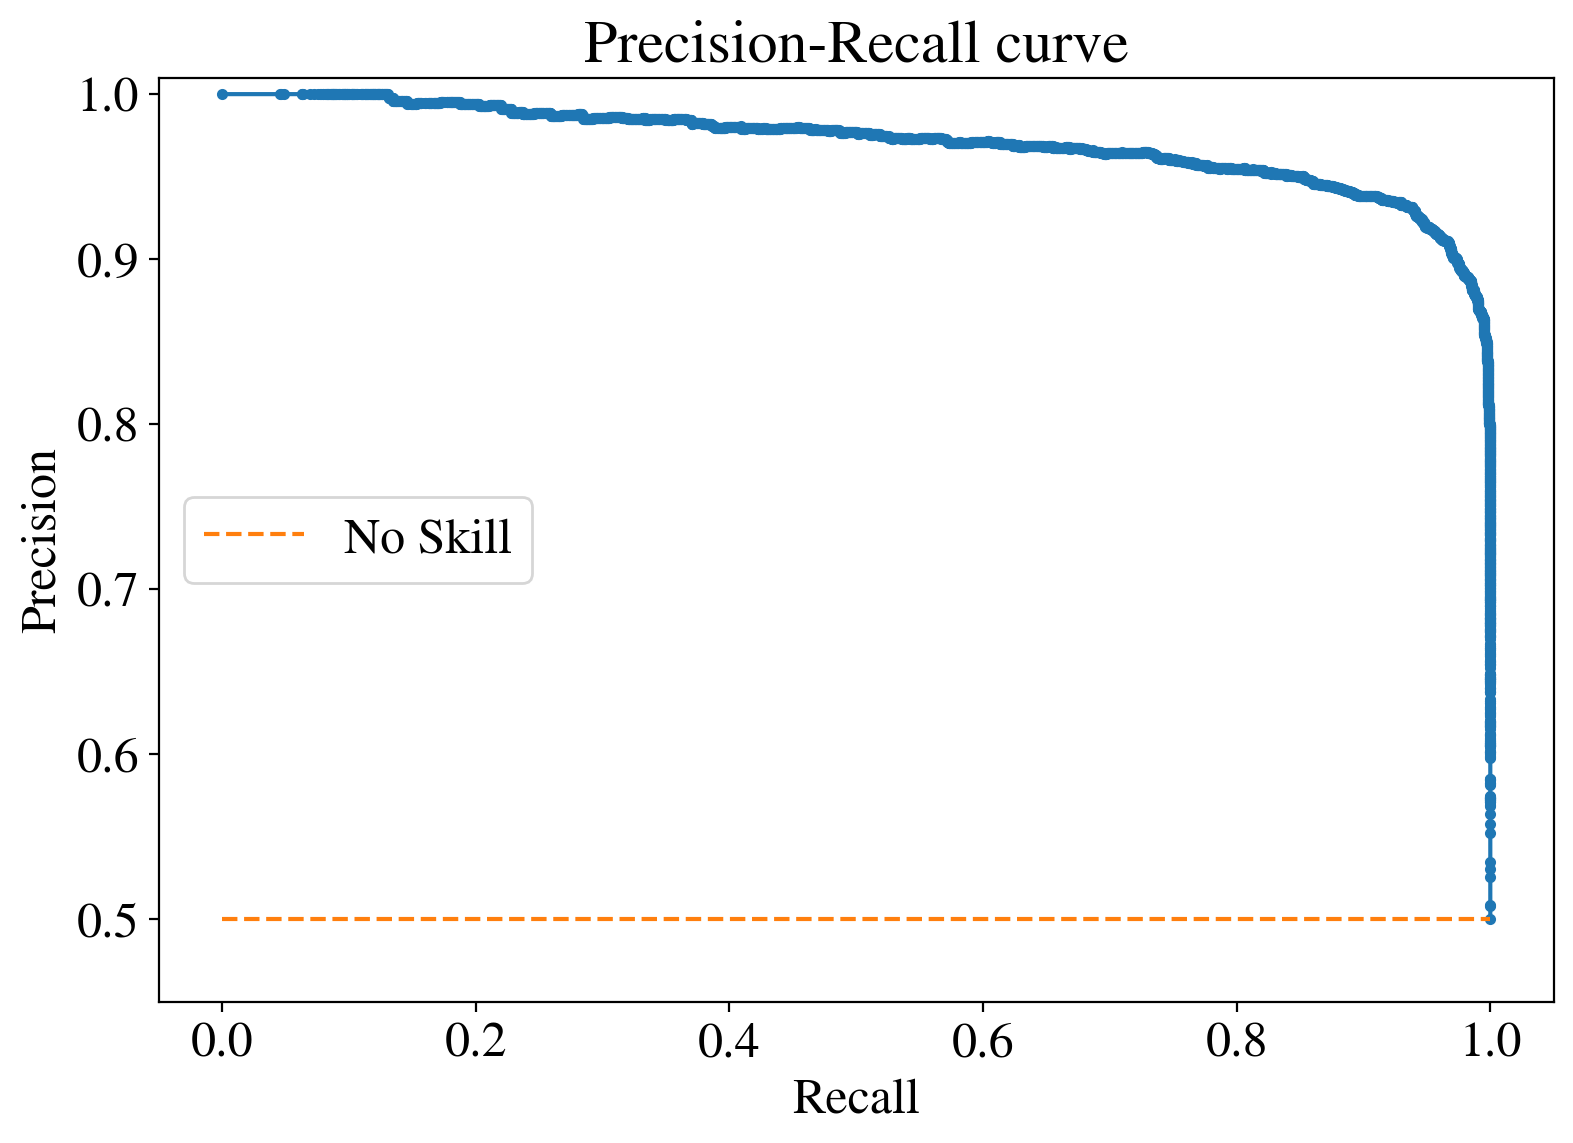

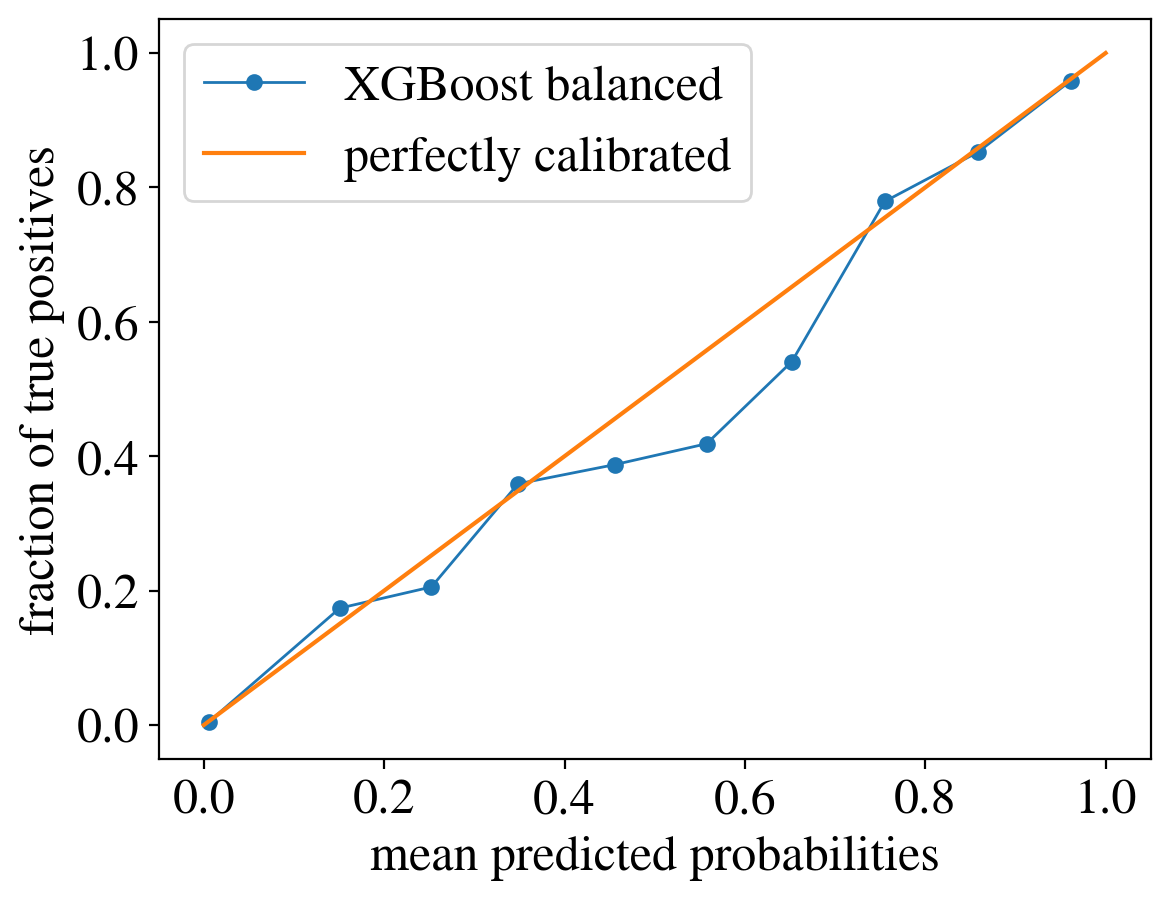

manual classification!


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 245.26it/s]


m1_thrs =  61.94153102327241
f1 score on test =  0.8689524325789403


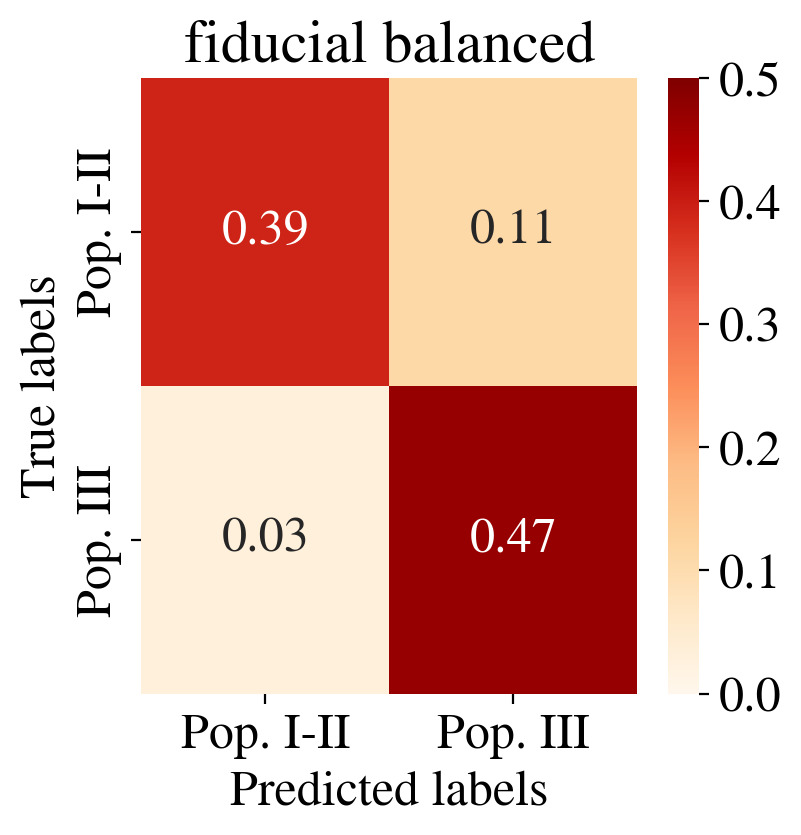

optimistic
currently processing... optimistic 0.3 True
GWFish Pop. III
     optimistic
     ET_cryo
number of selected instances after resampling 11397
 training is done on injected parameters!
GWFish Pop. I-II
     fiducial
     ET_cryo
number of selected instances after resampling 11397
 training is done on injected parameters!


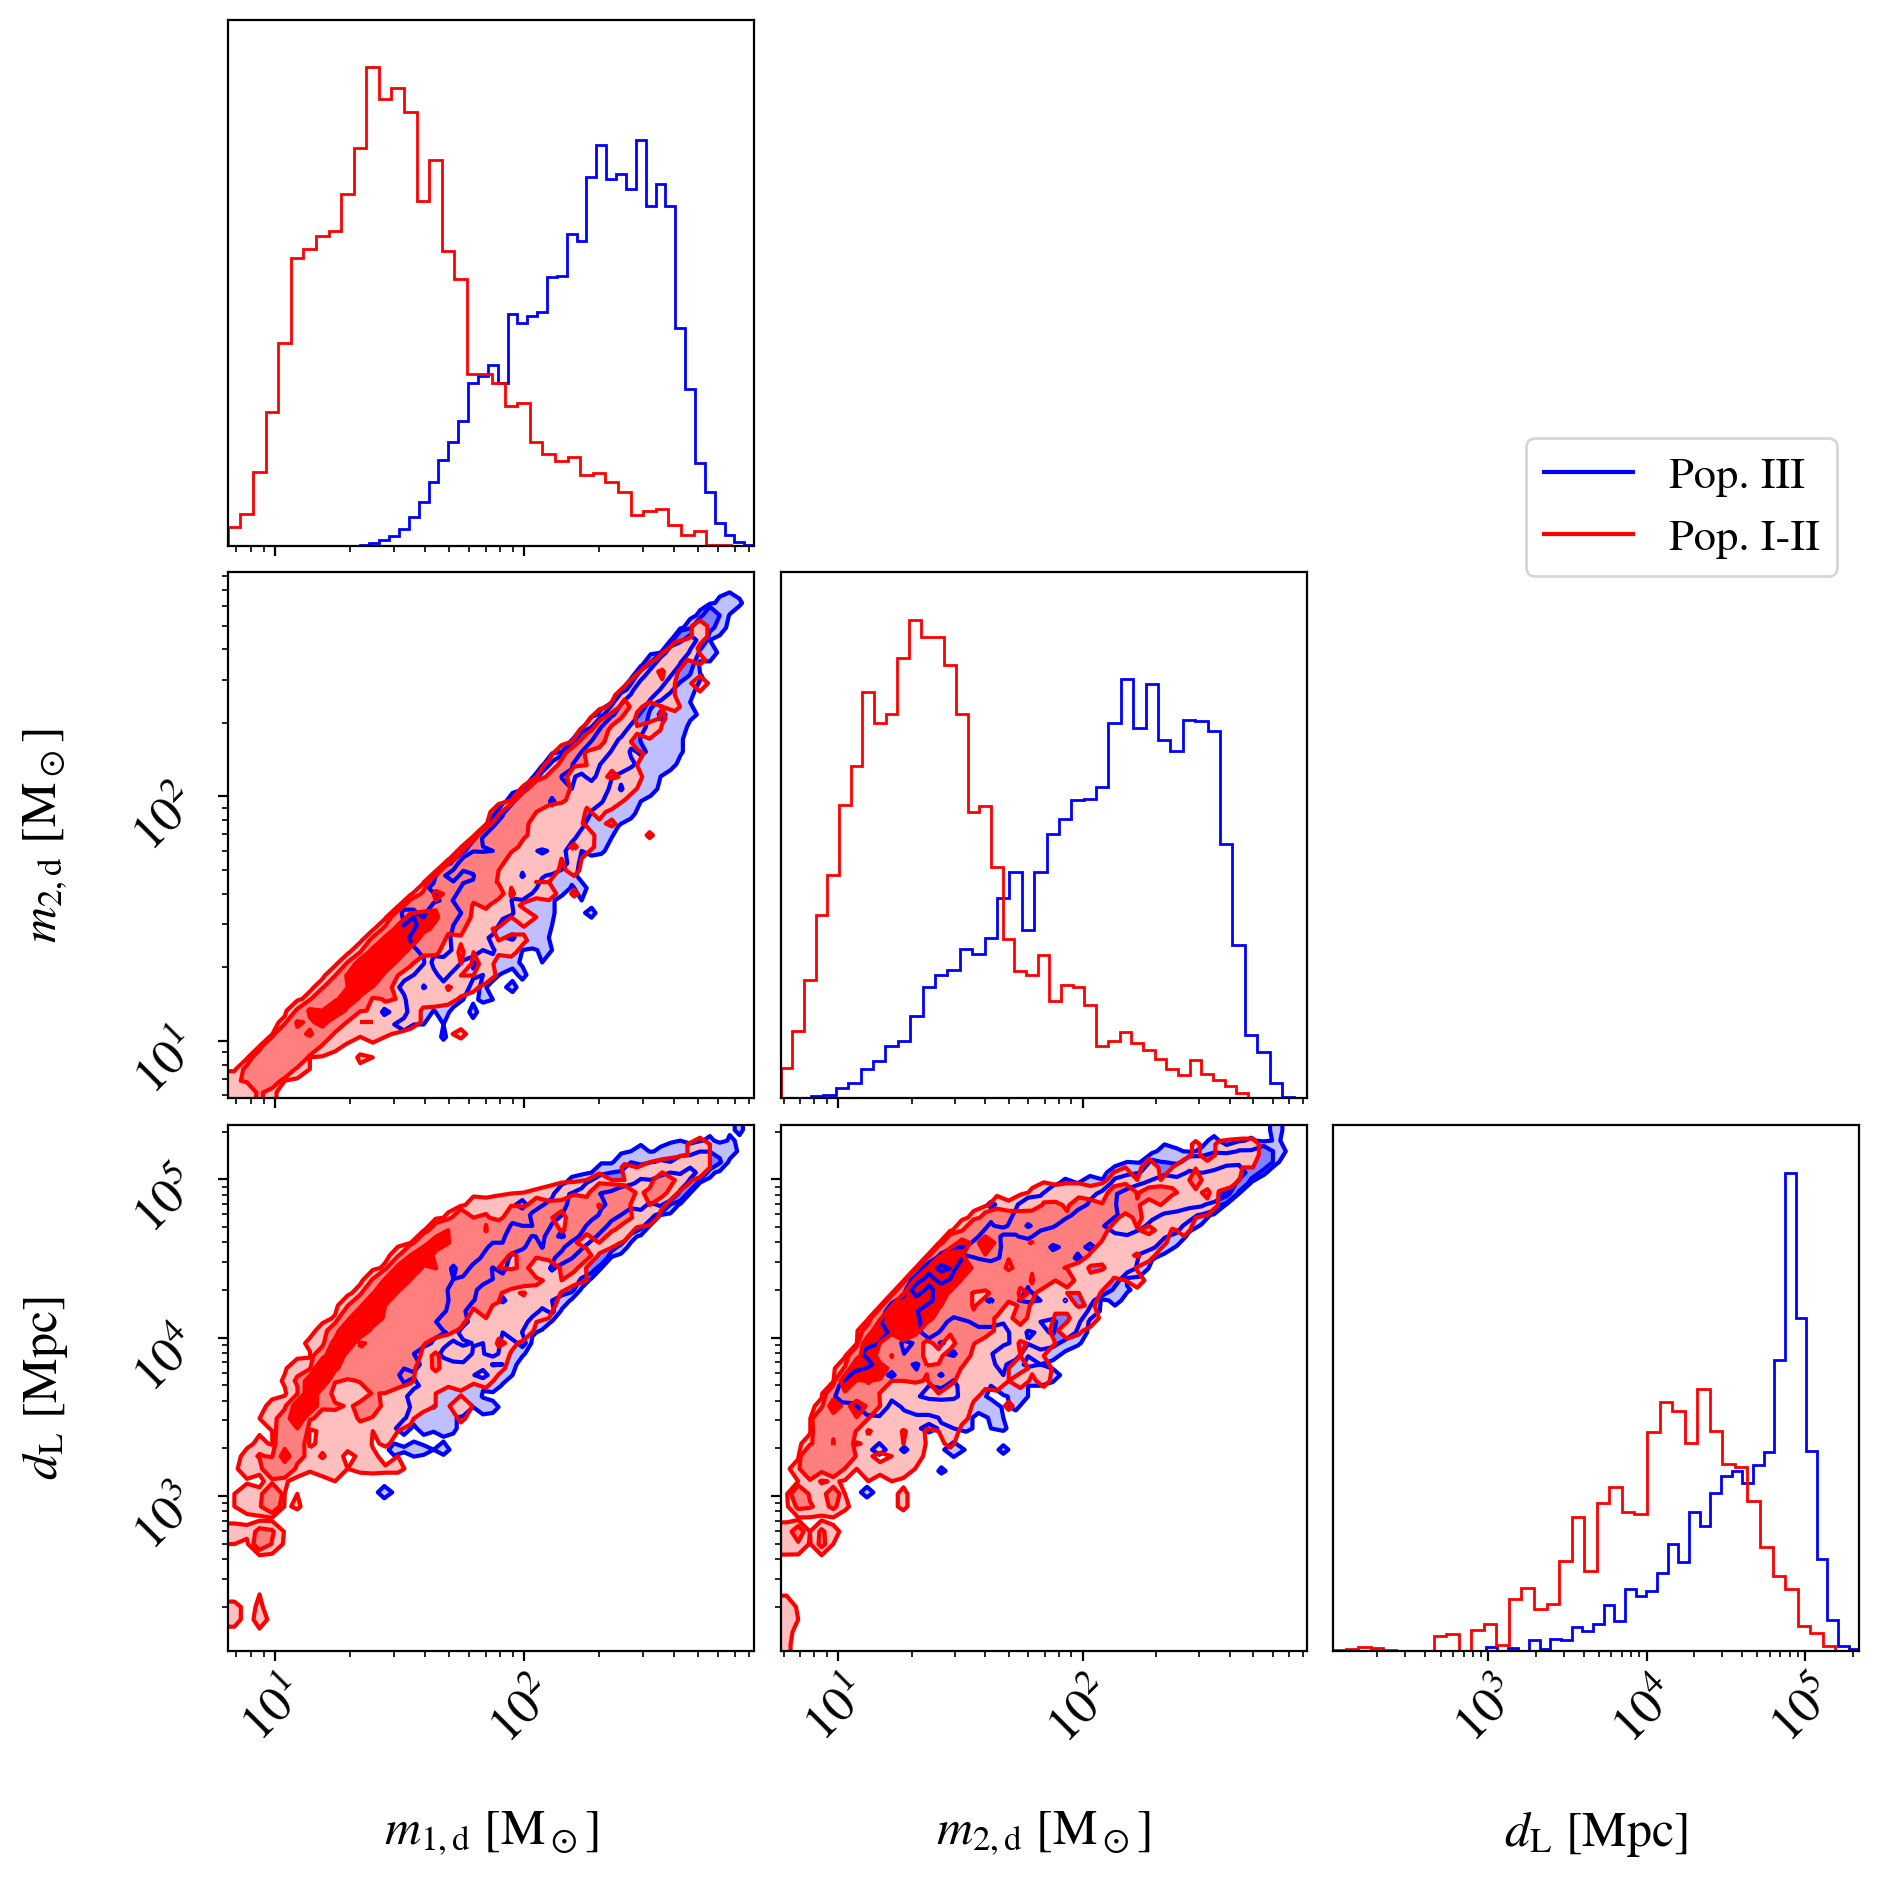

number of Pop I-II BBH (negative class) =  (11397, 3)
number of Pop III BBH (positive class) =  (11397, 3)
ratio  negative/positive class =  1.0
percentage Pop I-II BBH: 0.5
percentage Pop III BBH: 0.5
feature shape =  (22794, 3)
target shape =  (22794,)
...bulding the training and test set
X_train shape =  (15955, 3)
X_test shape =  (6839, 3)
extracting Pop I indexes for subsequent testing


100%|███████████████████████████████████| 11397/11397 [00:07<00:00, 1462.48it/s]


samples Pop I 
 [[6.46737991e+00 5.81398112e+00 1.04977587e+02]
 [6.55937047e+00 5.93815077e+00 1.12931481e+02]
 [6.59783417e+00 6.04068109e+00 1.38179253e+02]
 ...
 [5.04188577e+02 4.21022051e+02 1.40678537e+05]
 [5.06806773e+02 4.24935735e+02 1.40737246e+05]
 [5.34224073e+02 4.58795445e+02 1.40744140e+05]]
samples in X_test Pop I 
 [[6.46737991e+00 5.81398112e+00 1.04977587e+02]
 [6.55937047e+00 5.93815077e+00 1.12931481e+02]
 [6.59783417e+00 6.04068109e+00 1.38179253e+02]
 ...
 [5.04188577e+02 4.21022051e+02 1.40678537e+05]
 [5.06806773e+02 4.24935735e+02 1.40737246e+05]
 [5.34224073e+02 4.58795445e+02 1.40744140e+05]]
3420
3420
... optimization already done
      gamma  learning_rate  max_depth
0  0.359596       0.033762         13
cross validation
selected threshold to plot  0.49898285
selected threshold to plot  0.50007963
selected threshold to plot  0.5024228
selected threshold to plot  0.4987436
selected threshold to plot  0.49996287


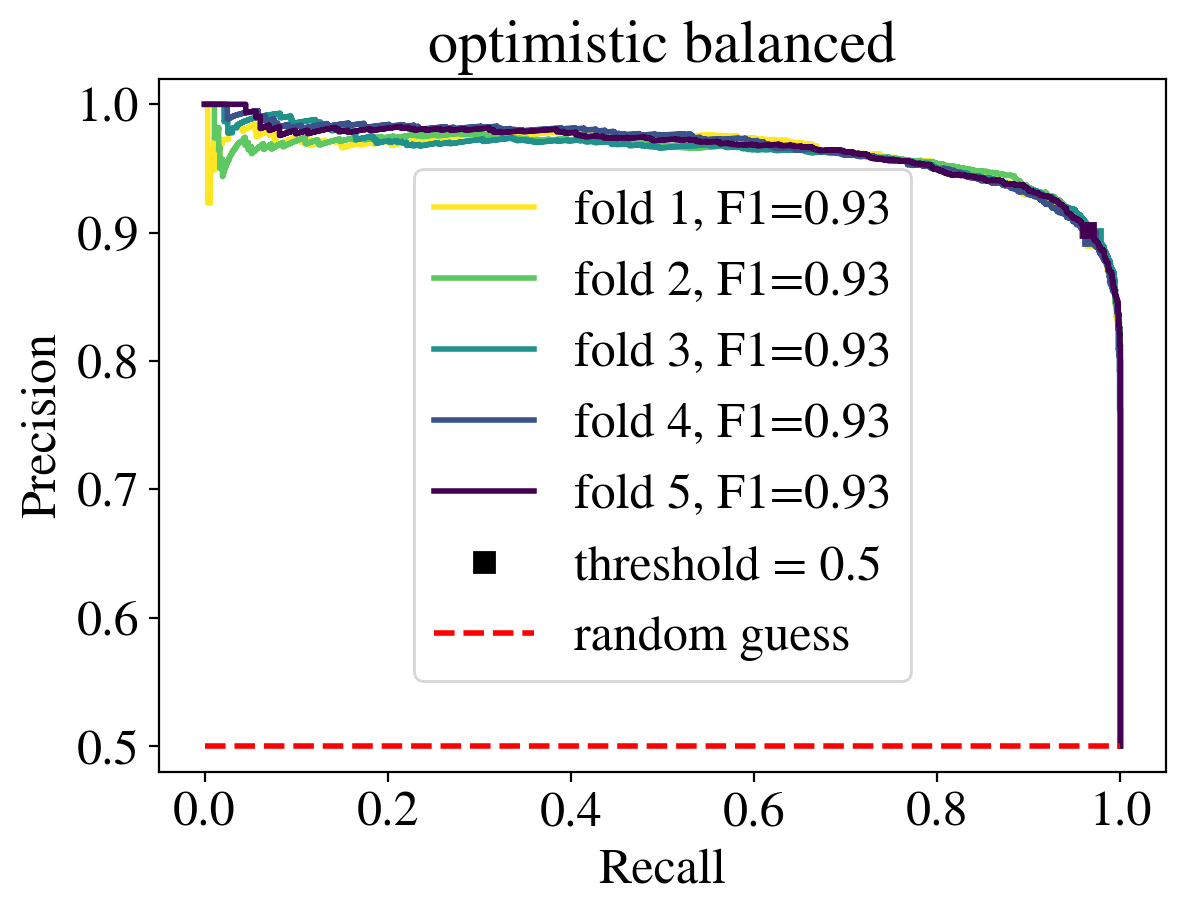

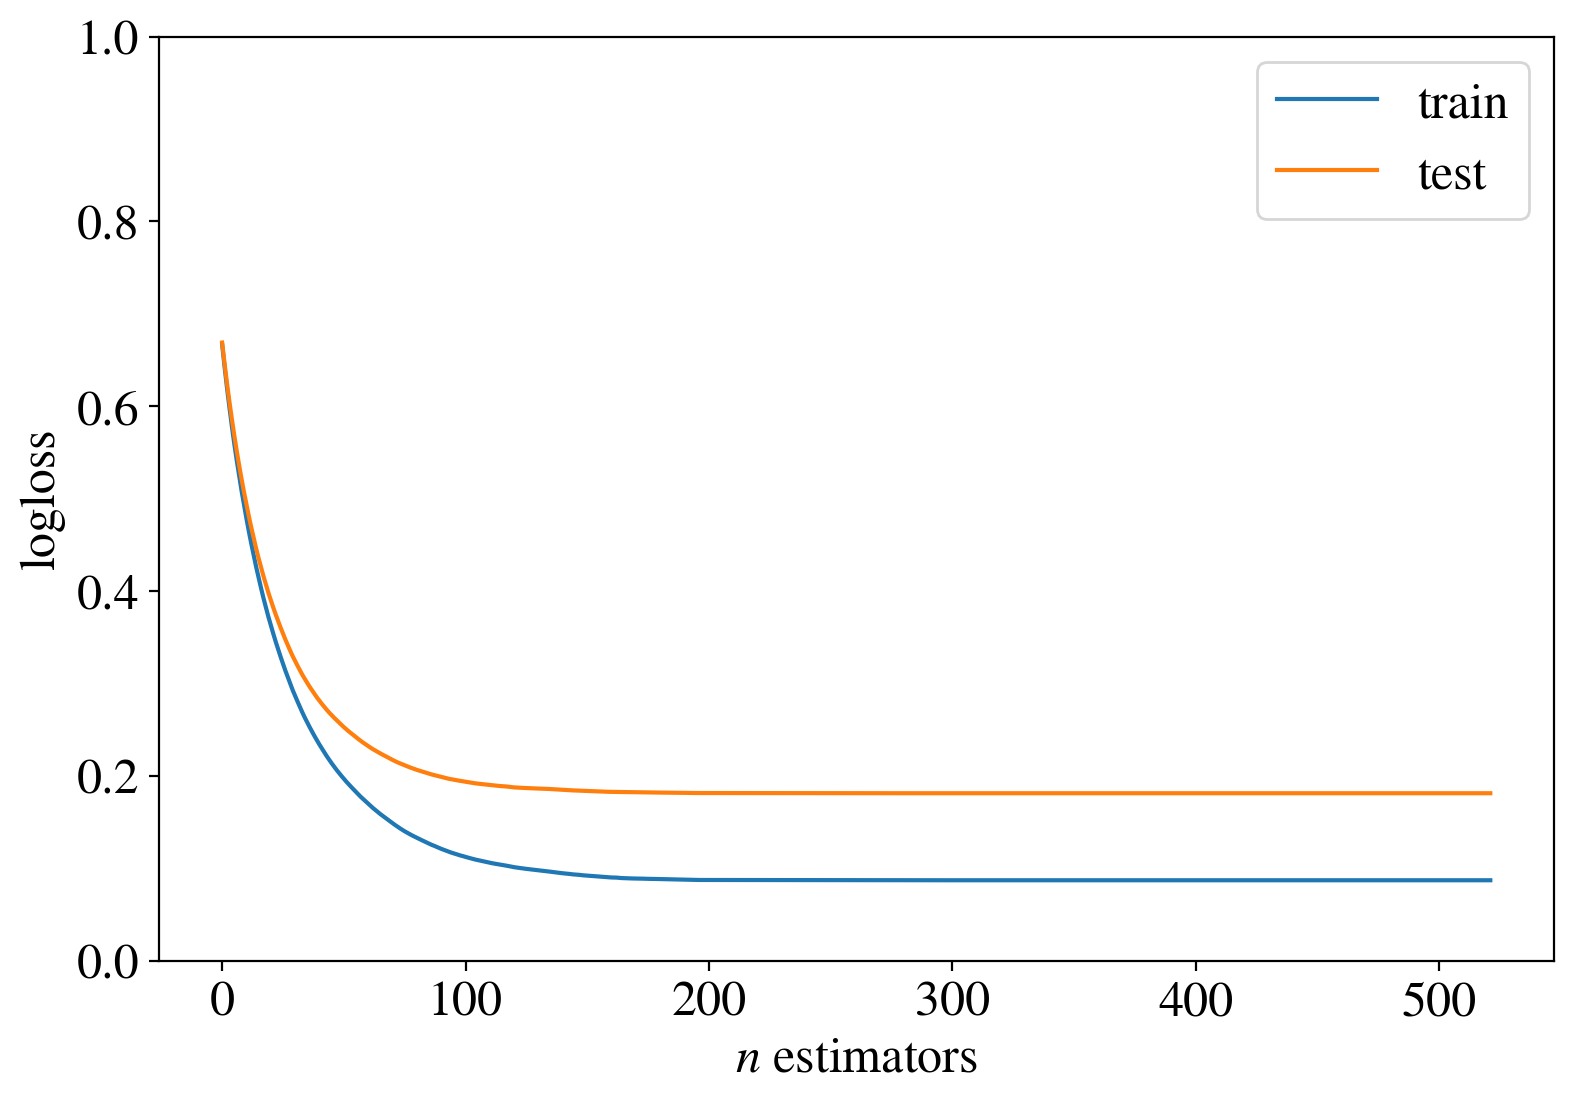

accuracy score =  0.9298143003363065
balanced accuracy score =  0.9298193873589111
recall score =  0.9646095349517403
f1 score =  0.9321650650084794
precision score =  0.9018321028165163


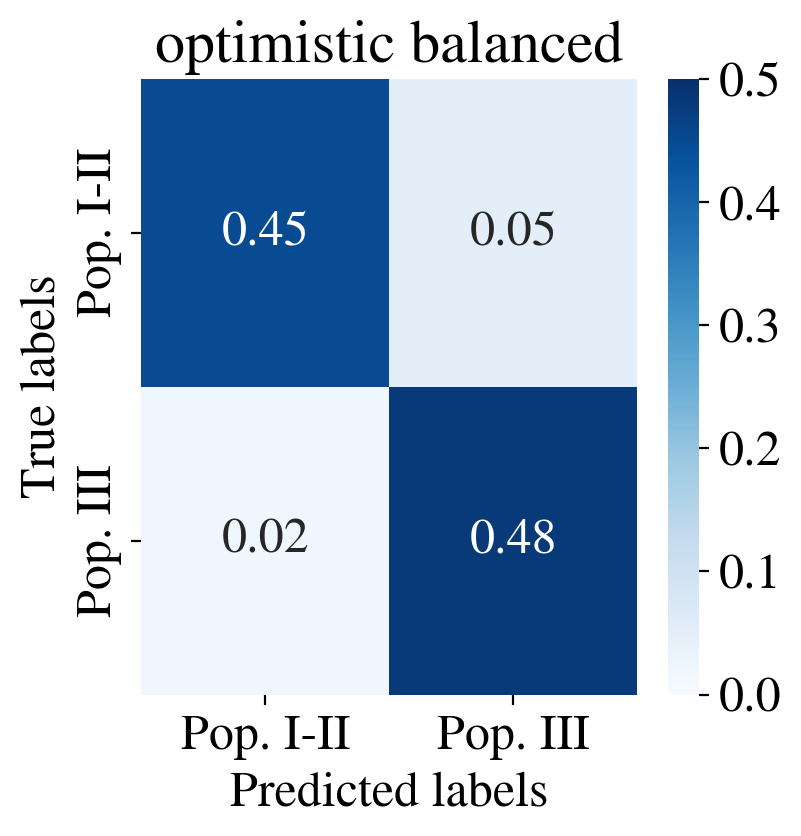

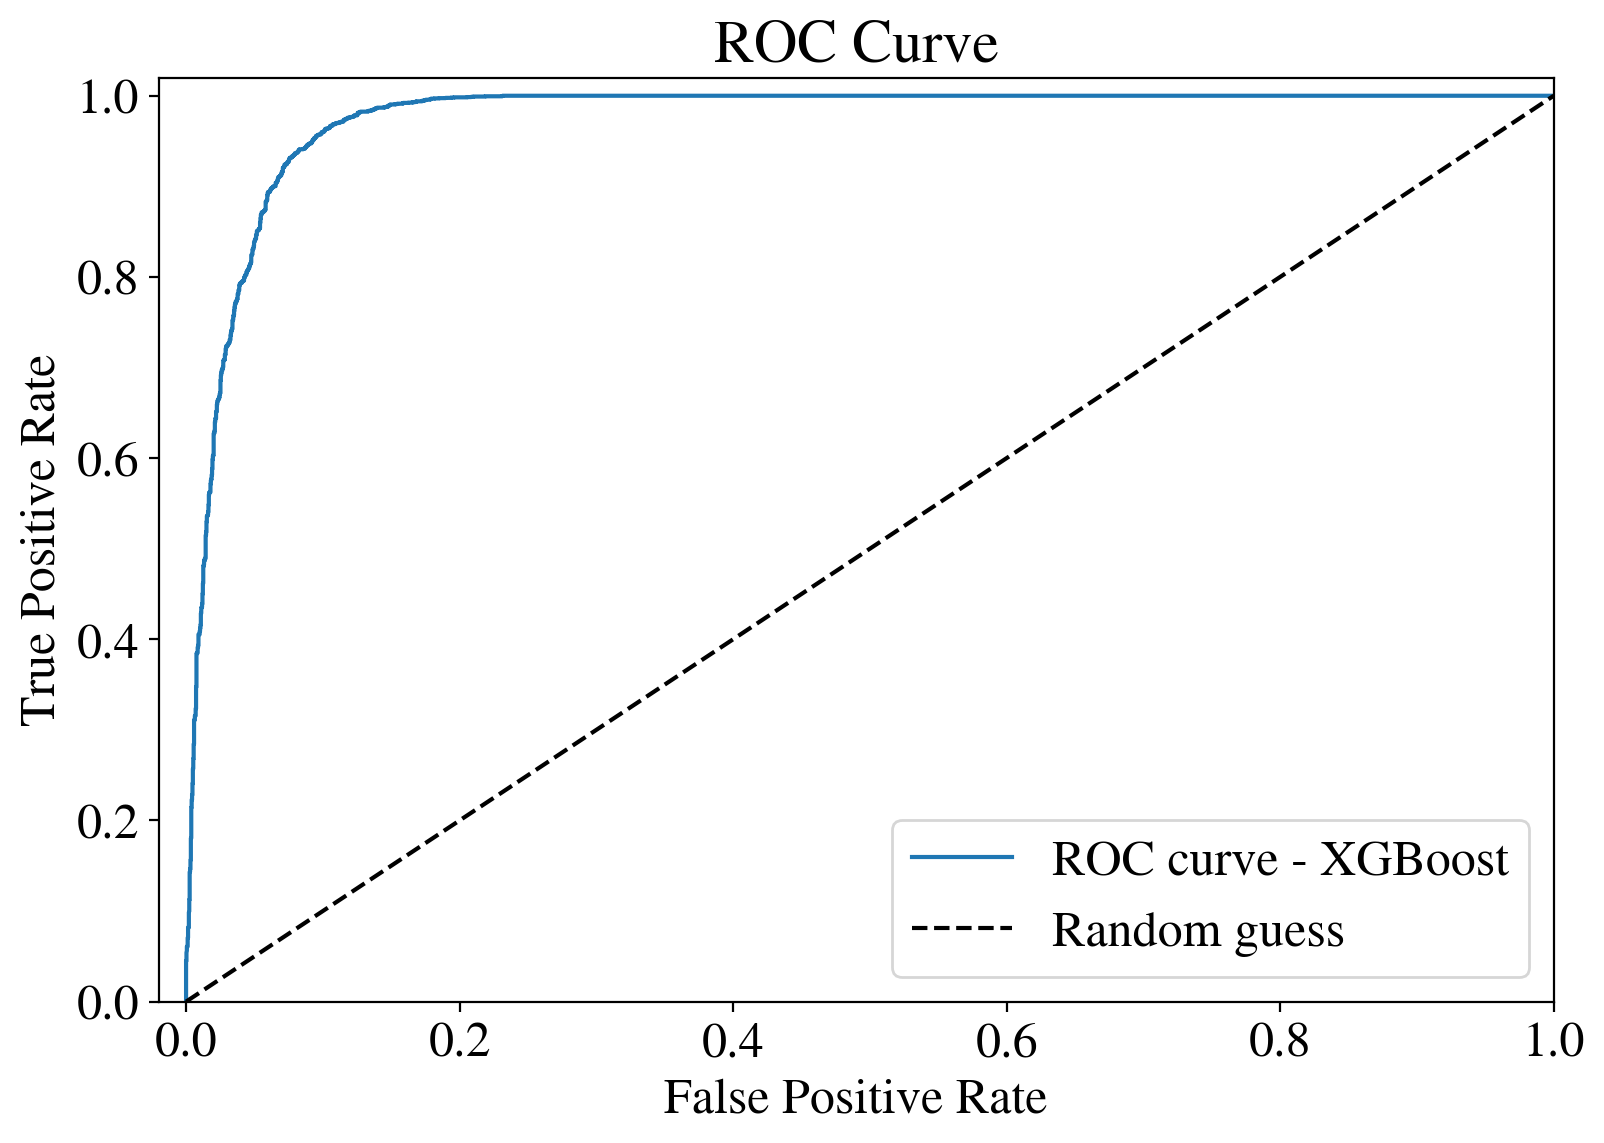

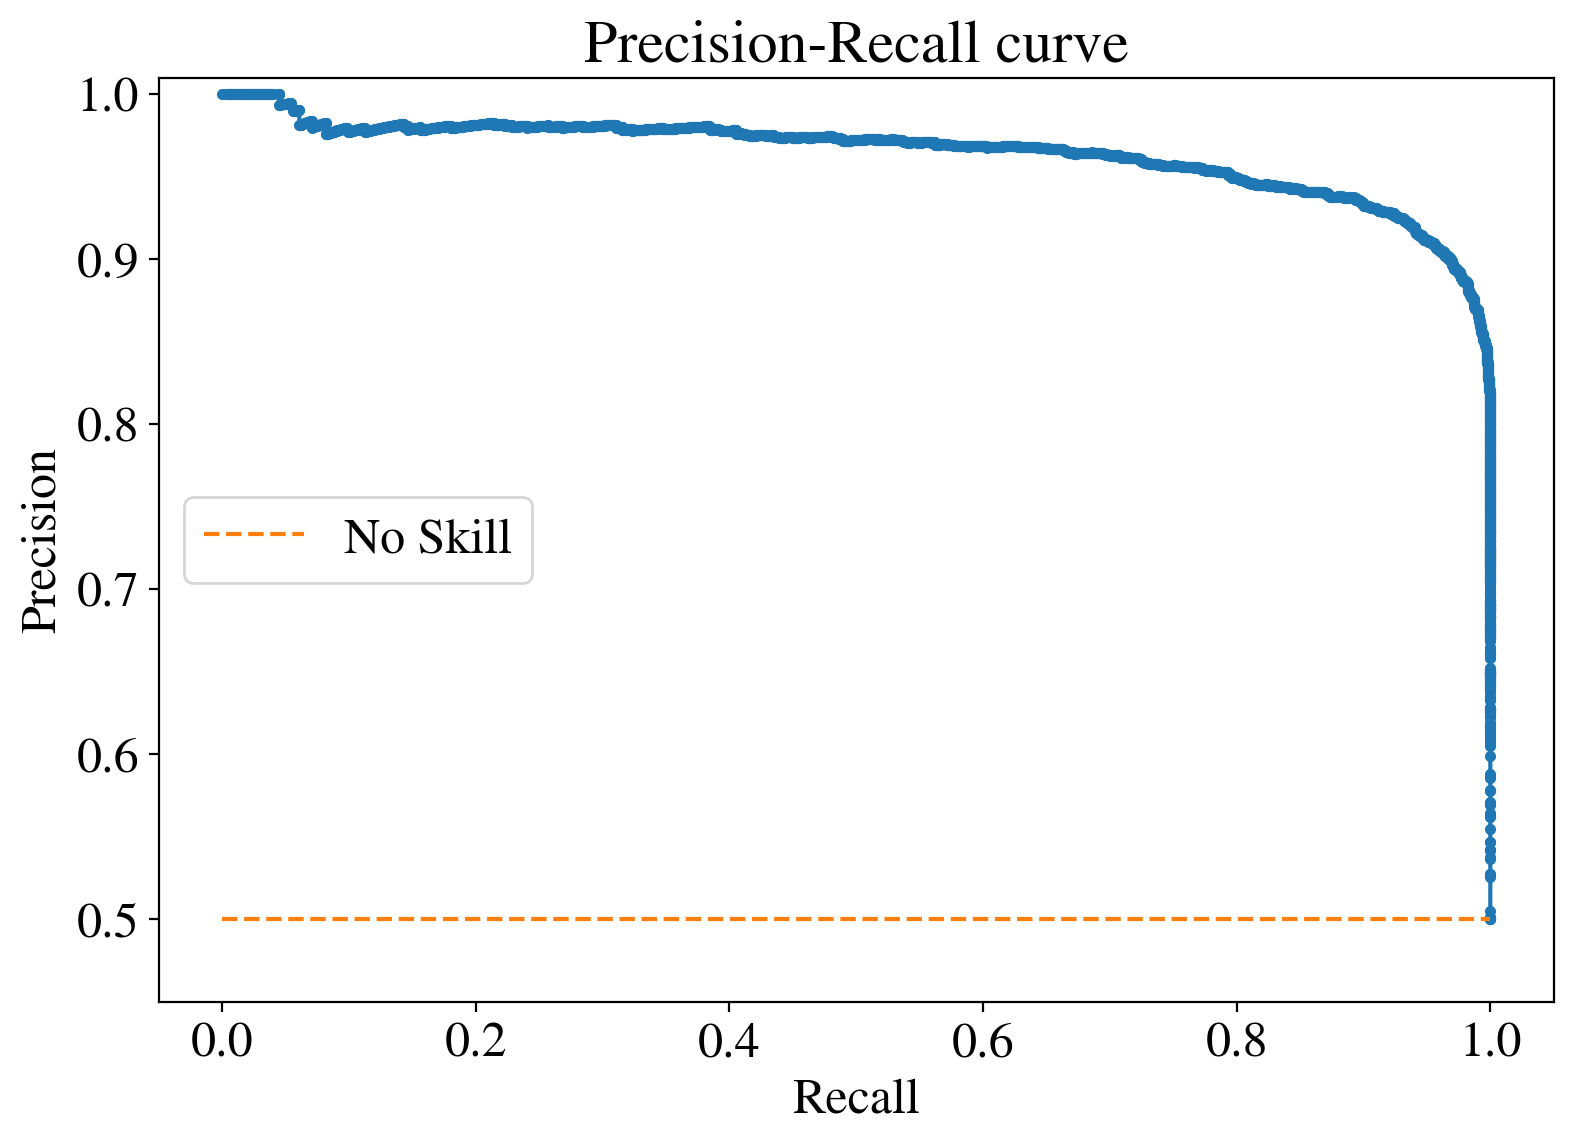

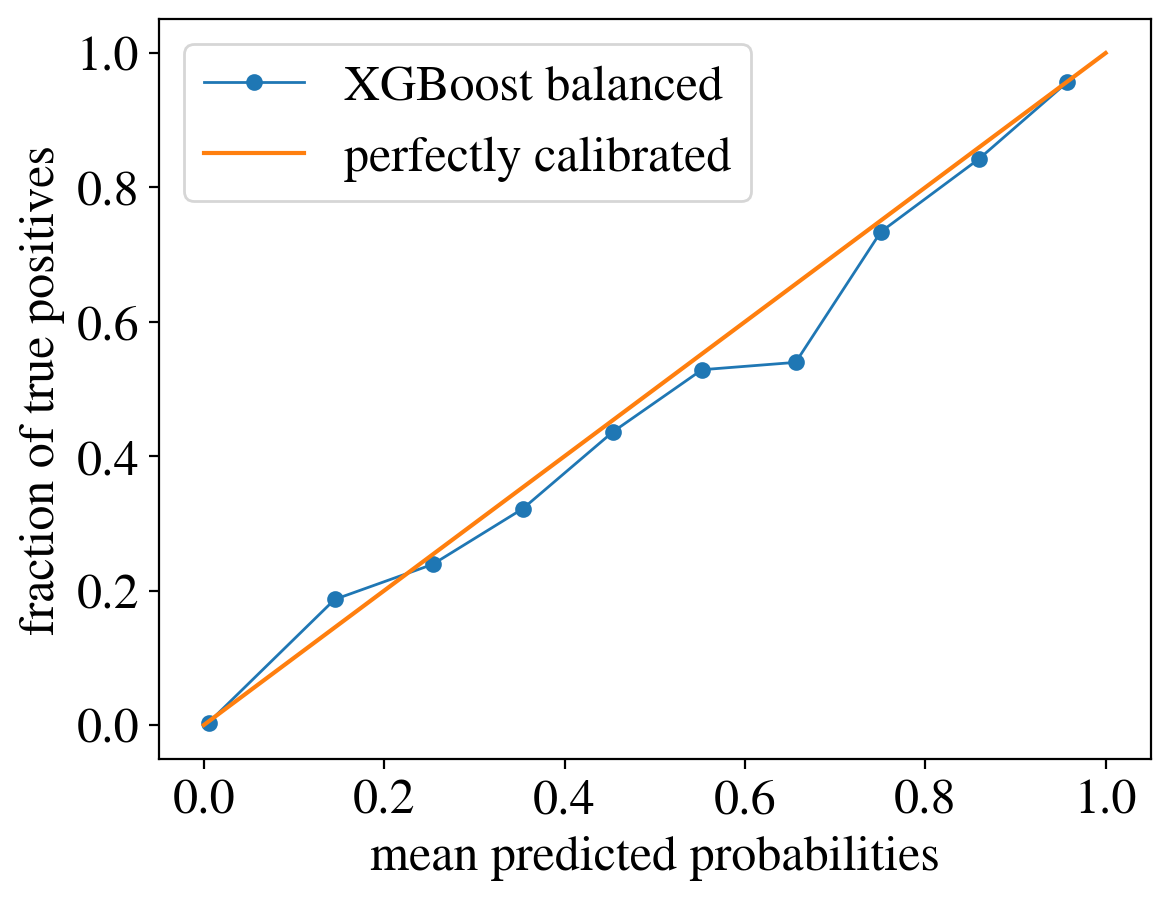

manual classification!


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 232.21it/s]


m1_thrs =  56.71722973276033
f1 score on test =  0.859672658975047


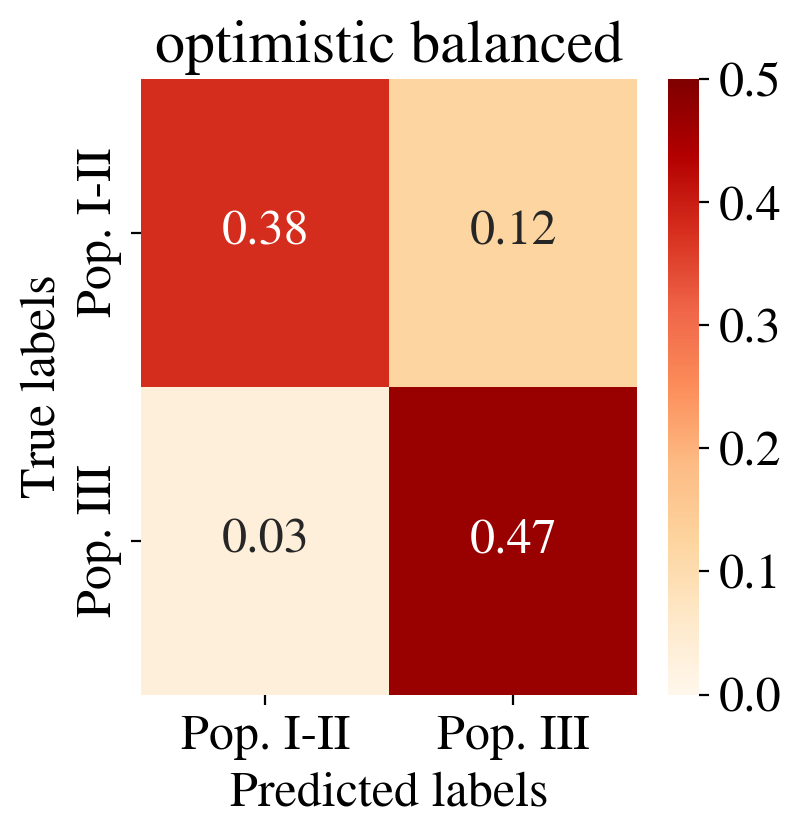

pessimistic
currently processing... pessimistic 0.3 True
GWFish Pop. III
     pessimistic
     ET_cryo
number of selected instances after resampling 11397
 training is done on injected parameters!
GWFish Pop. I-II
     fiducial
     ET_cryo
number of selected instances after resampling 11397
 training is done on injected parameters!


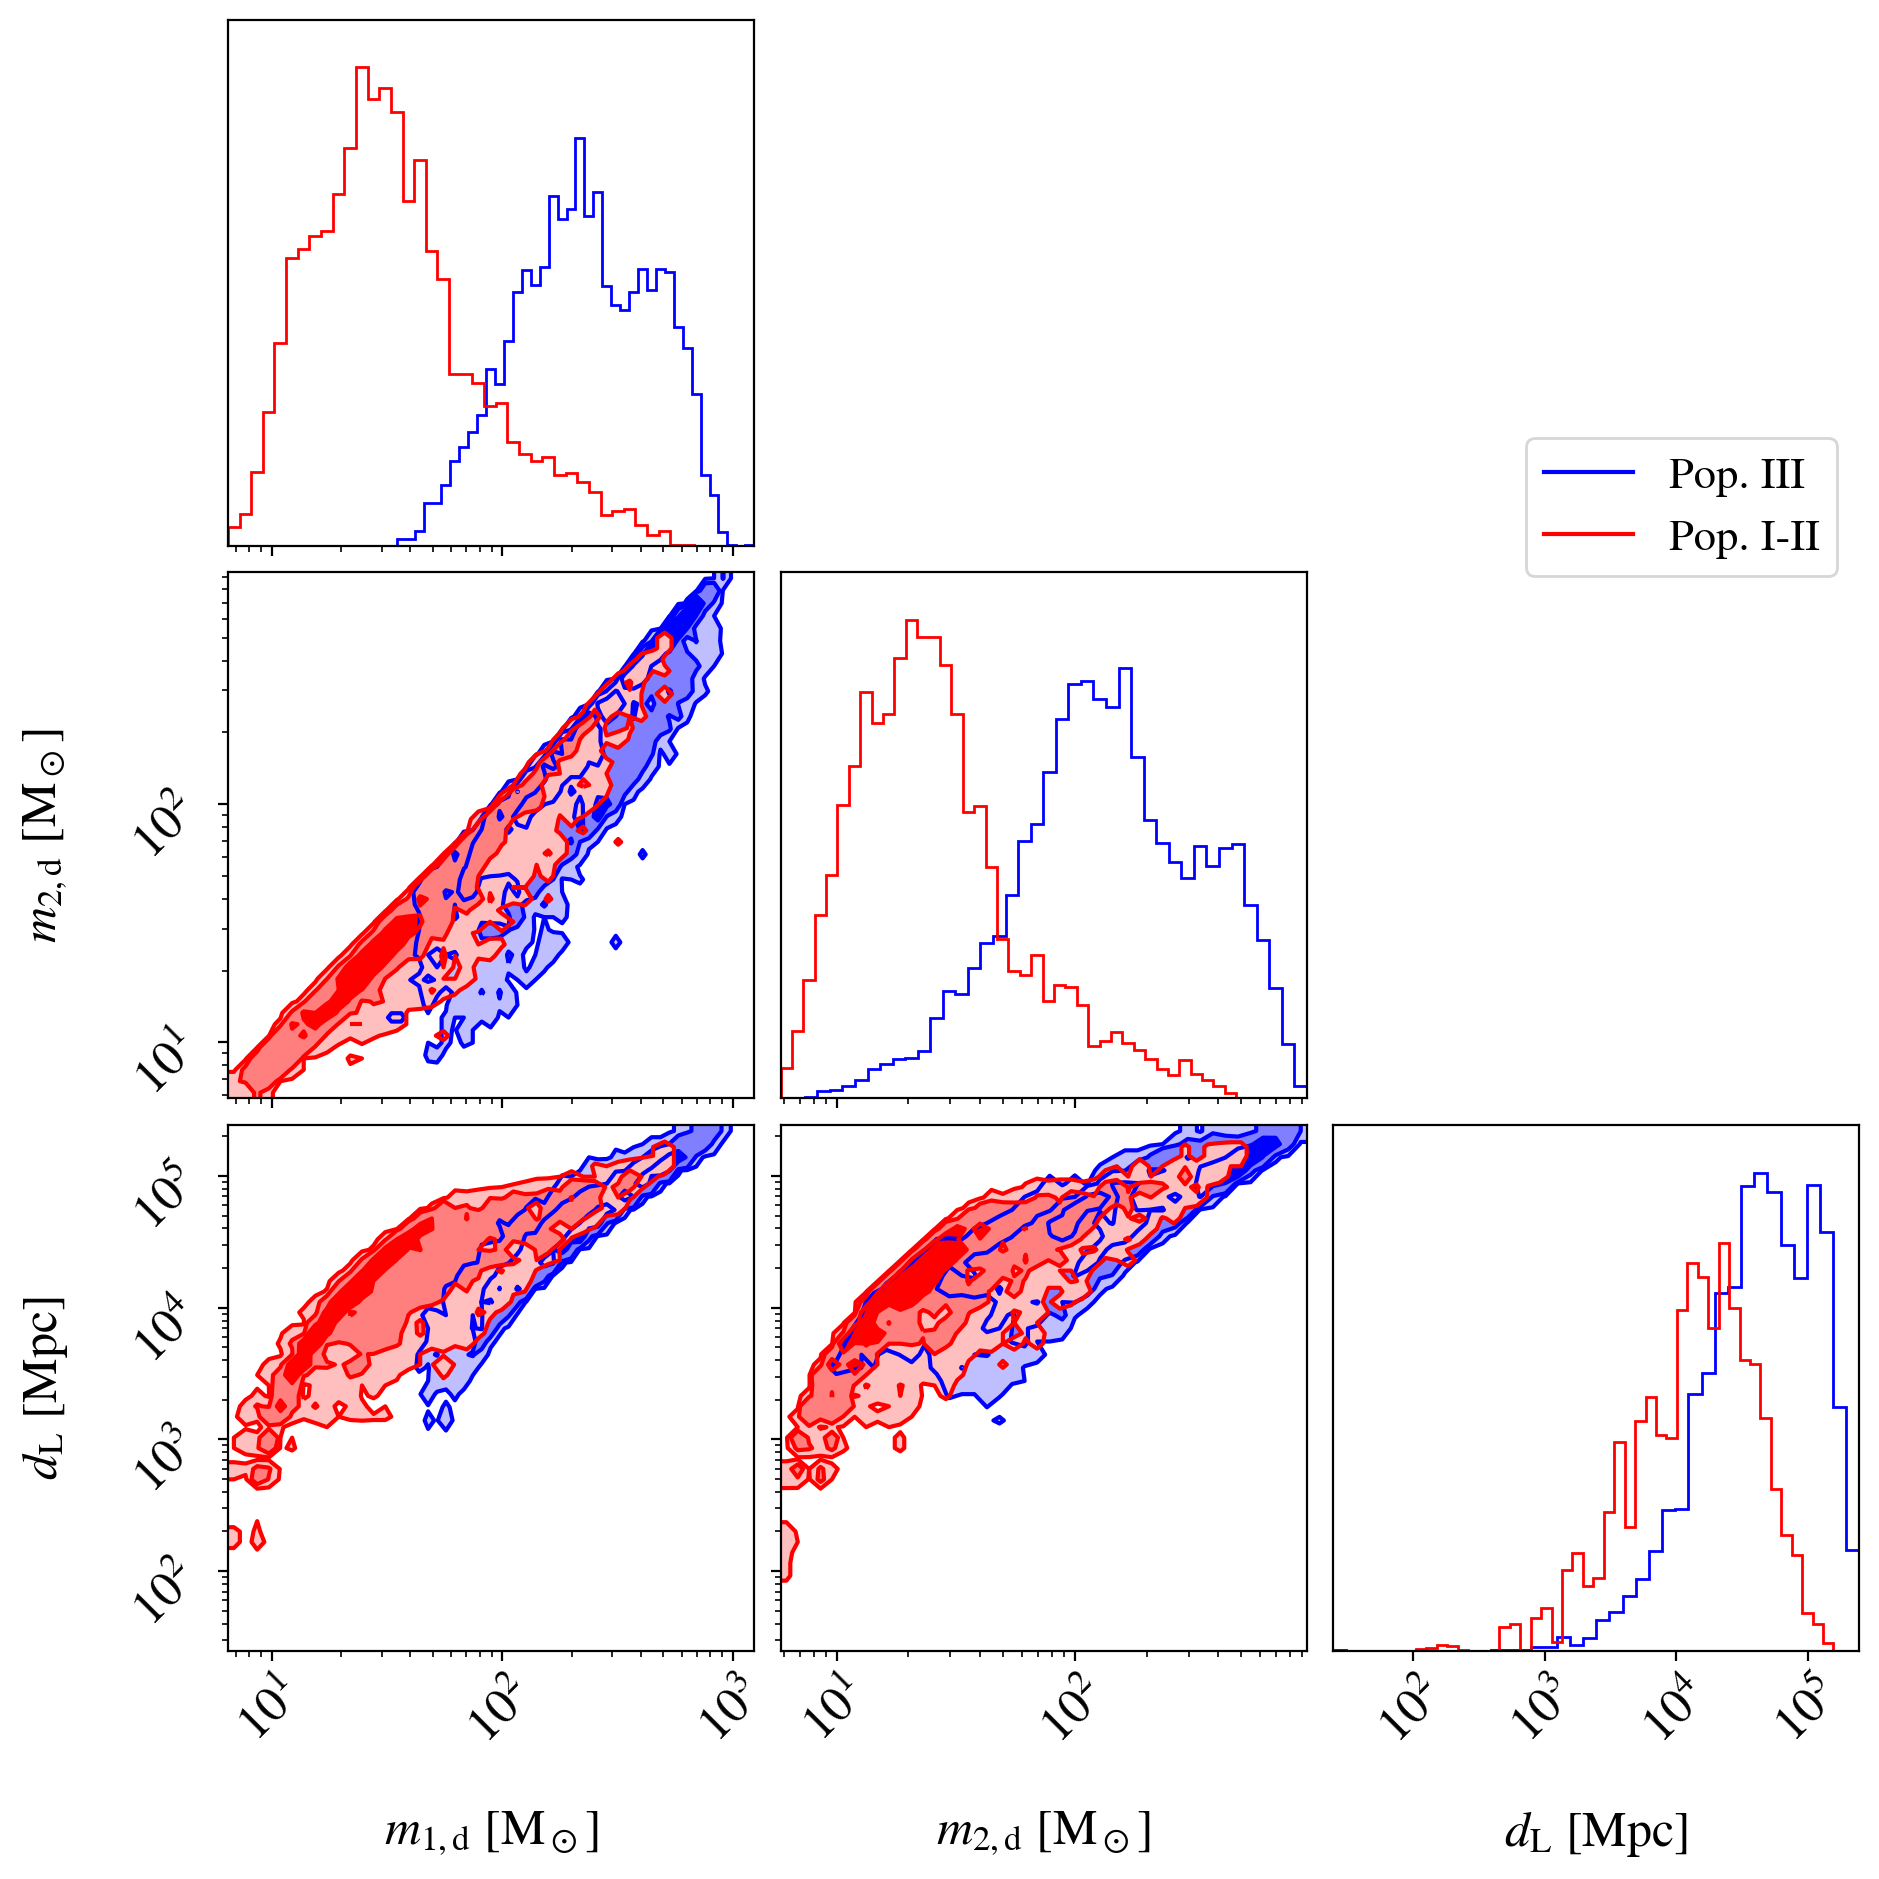

number of Pop I-II BBH (negative class) =  (11397, 3)
number of Pop III BBH (positive class) =  (11397, 3)
ratio  negative/positive class =  1.0
percentage Pop I-II BBH: 0.5
percentage Pop III BBH: 0.5
feature shape =  (22794, 3)
target shape =  (22794,)
...bulding the training and test set
X_train shape =  (15955, 3)
X_test shape =  (6839, 3)
extracting Pop I indexes for subsequent testing


100%|███████████████████████████████████| 11397/11397 [00:08<00:00, 1354.76it/s]


samples Pop I 
 [[6.46737991e+00 5.81398112e+00 1.04977587e+02]
 [6.55937047e+00 5.93815077e+00 1.12931481e+02]
 [6.59783417e+00 6.04068109e+00 1.38179253e+02]
 ...
 [5.04188577e+02 4.21022051e+02 1.40678537e+05]
 [5.06806773e+02 4.24935735e+02 1.40737246e+05]
 [5.34224073e+02 4.58795445e+02 1.40744140e+05]]
samples in X_test Pop I 
 [[6.46737991e+00 5.81398112e+00 1.04977587e+02]
 [6.55937047e+00 5.93815077e+00 1.12931481e+02]
 [6.59783417e+00 6.04068109e+00 1.38179253e+02]
 ...
 [5.04188577e+02 4.21022051e+02 1.40678537e+05]
 [5.06806773e+02 4.24935735e+02 1.40737246e+05]
 [5.34224073e+02 4.58795445e+02 1.40744140e+05]]
3420
3420
... optimization already done
     gamma  learning_rate  max_depth
0  0.25242       0.016163         12
cross validation
selected threshold to plot  0.49983722
selected threshold to plot  0.5014705
selected threshold to plot  0.5002978
selected threshold to plot  0.5008806
selected threshold to plot  0.49884194


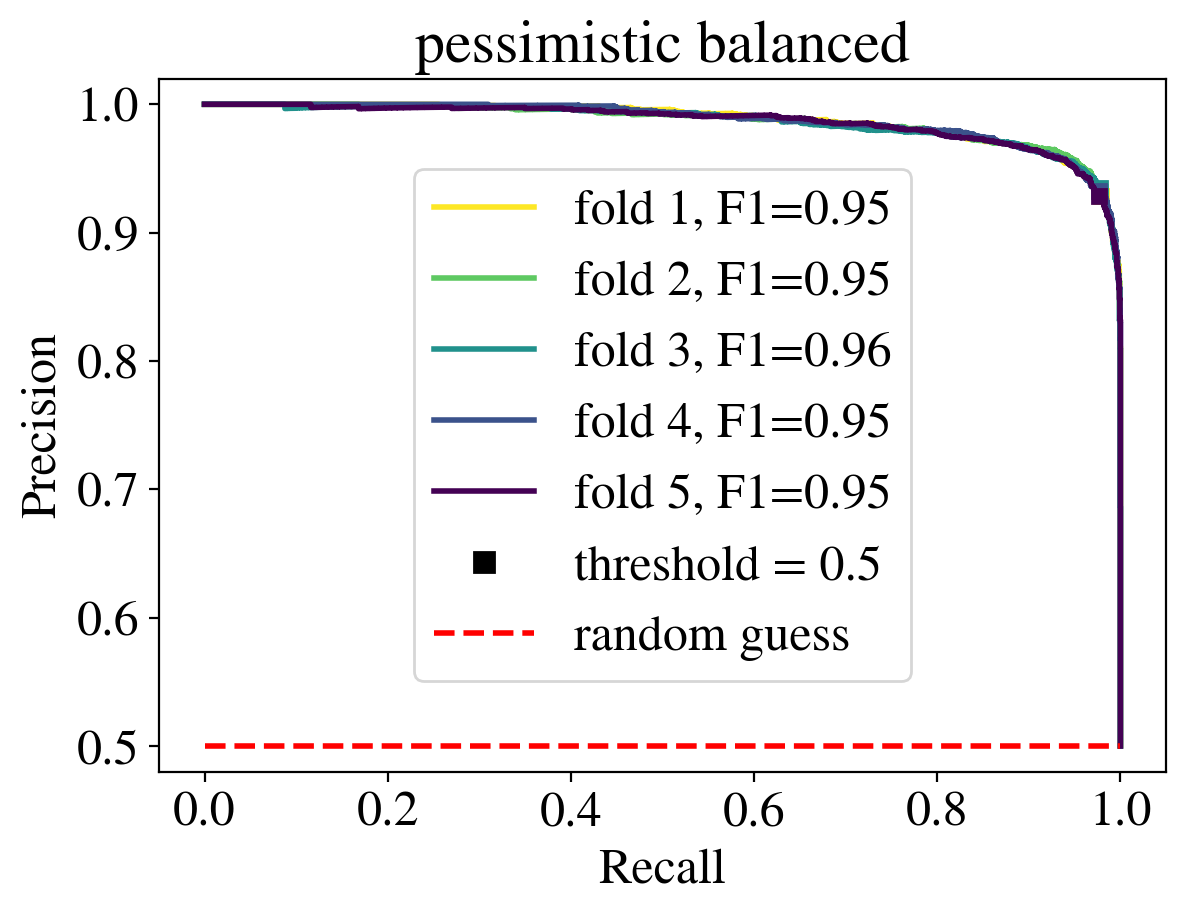

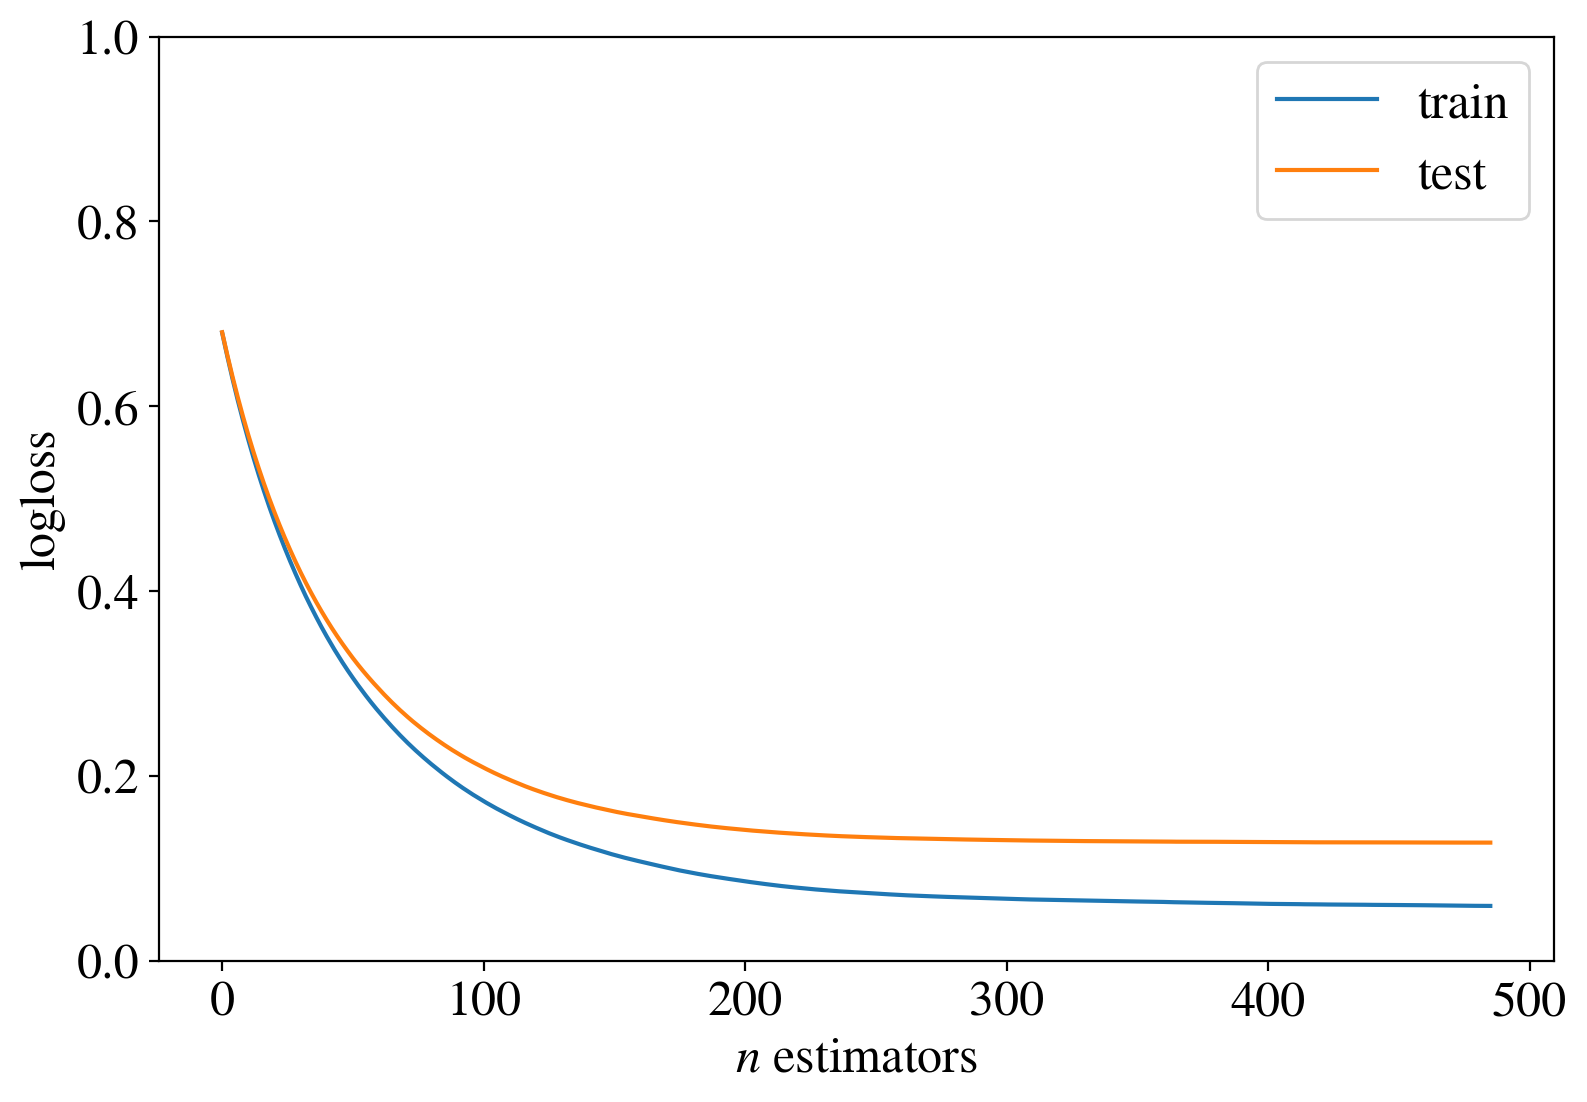

accuracy score =  0.95116245065068
balanced accuracy score =  0.9511662125480416
recall score =  0.9768938286048552
f1 score =  0.9523809523809523
precision score =  0.9290681502086231


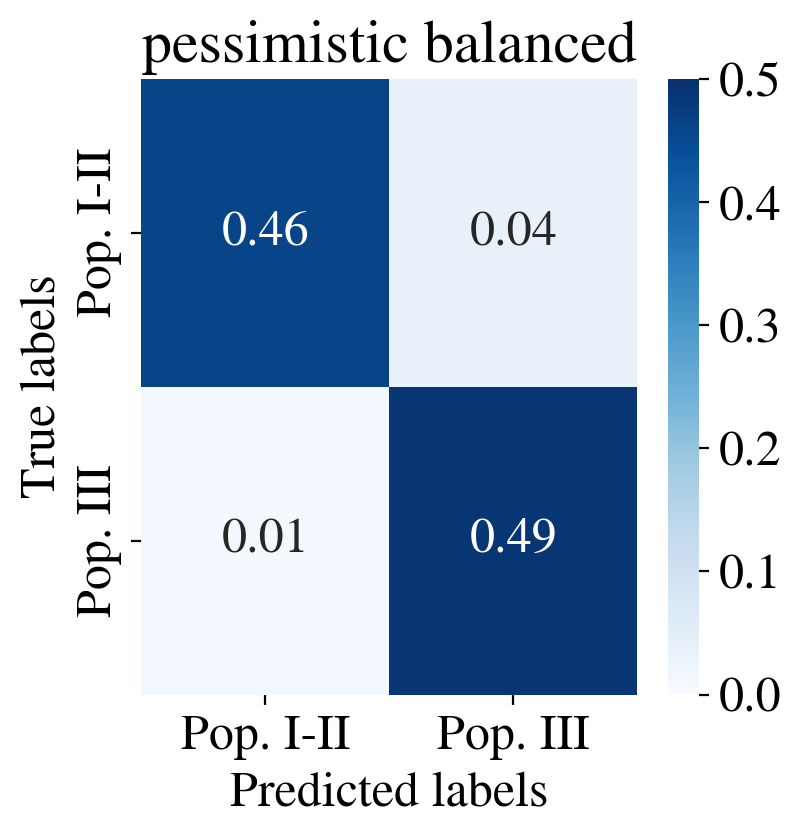

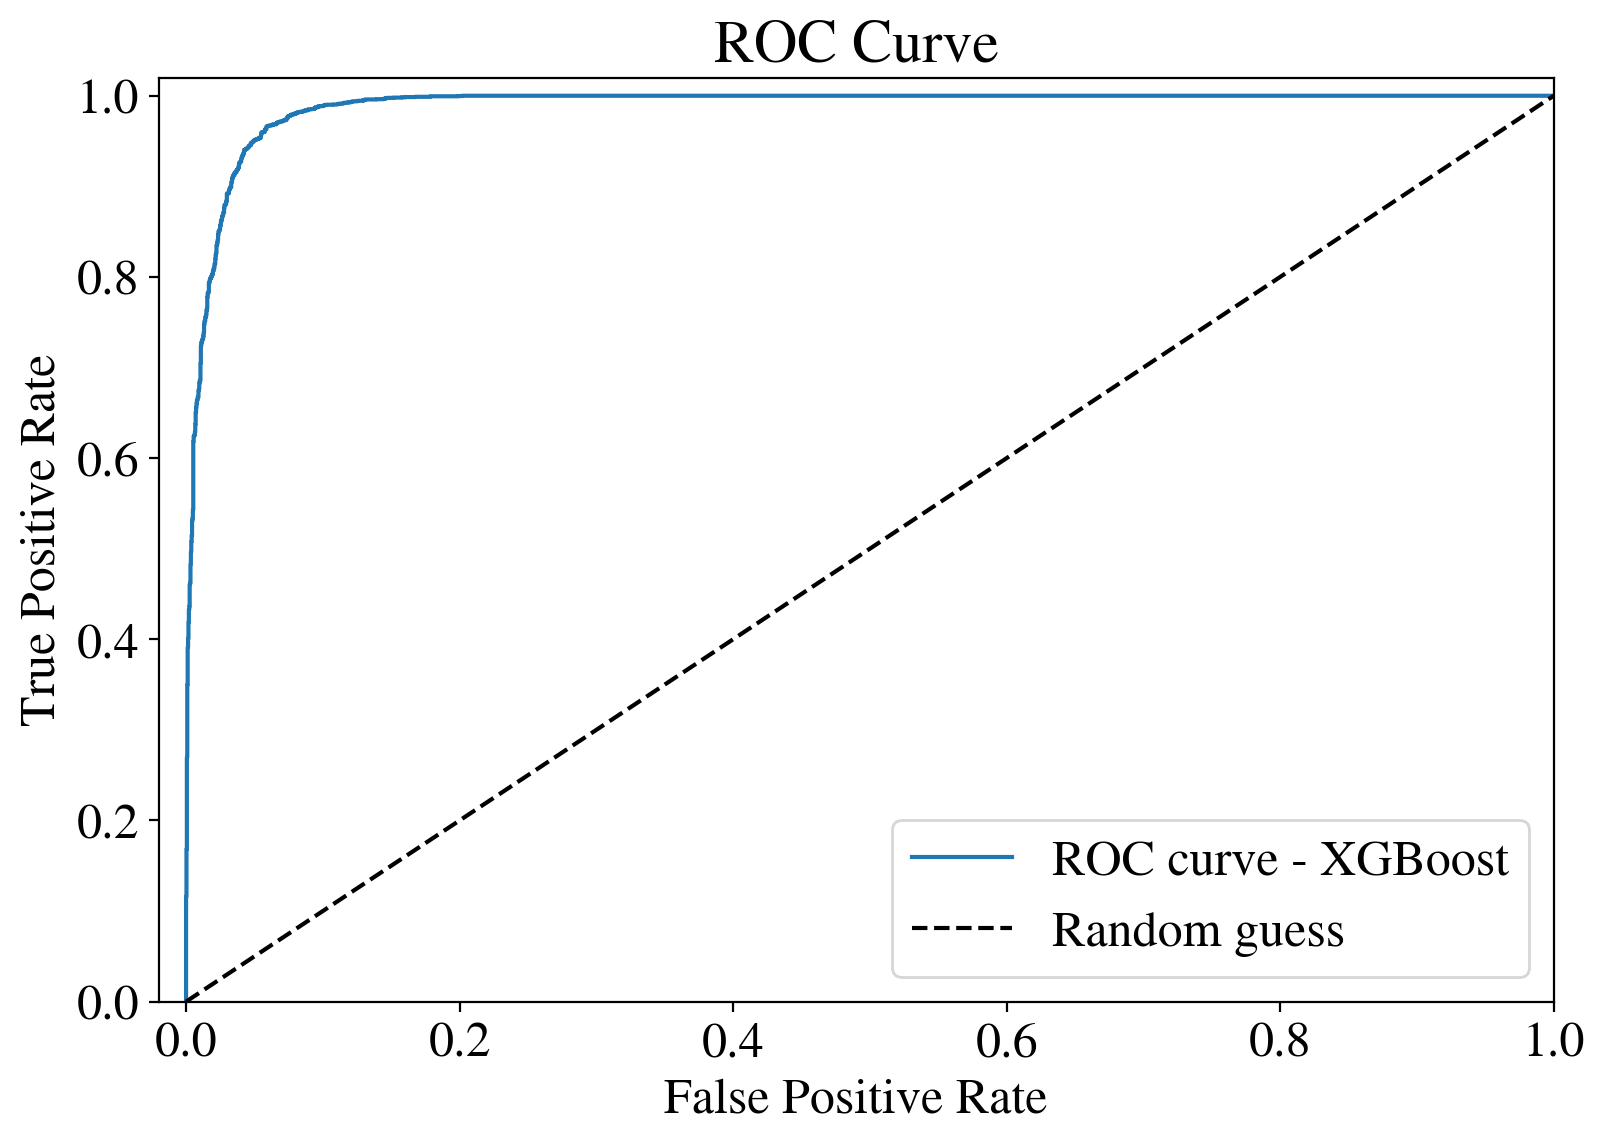

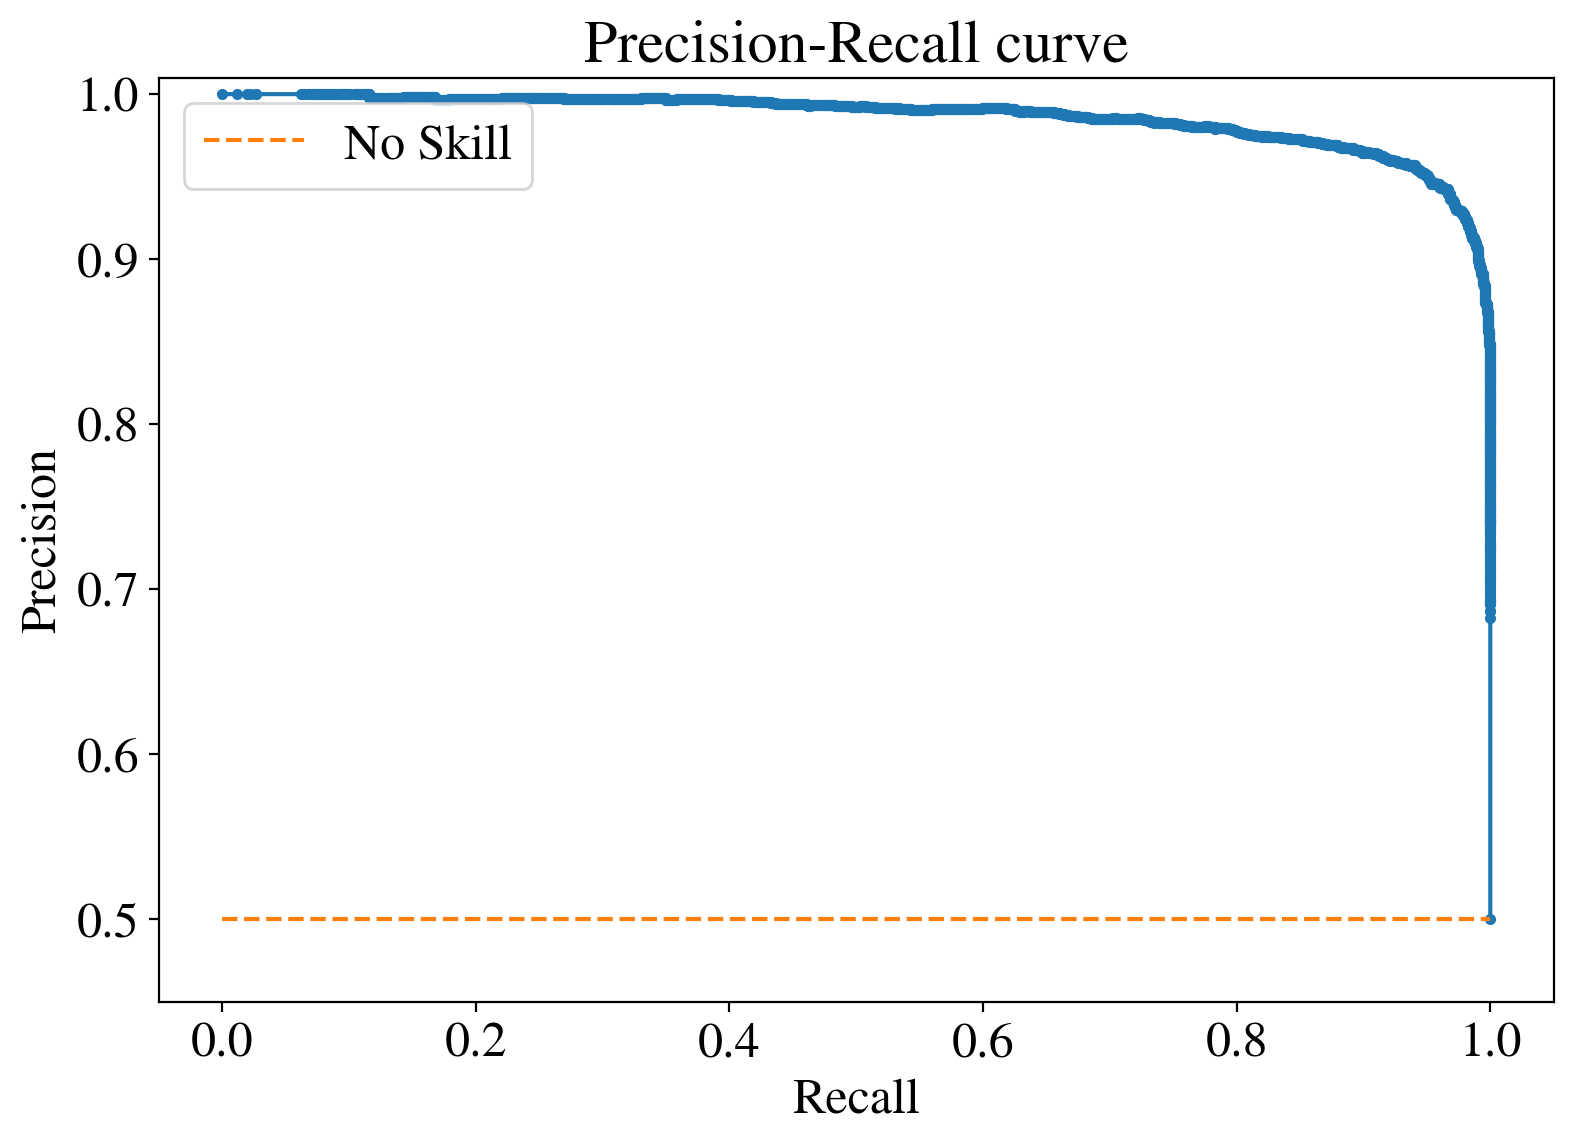

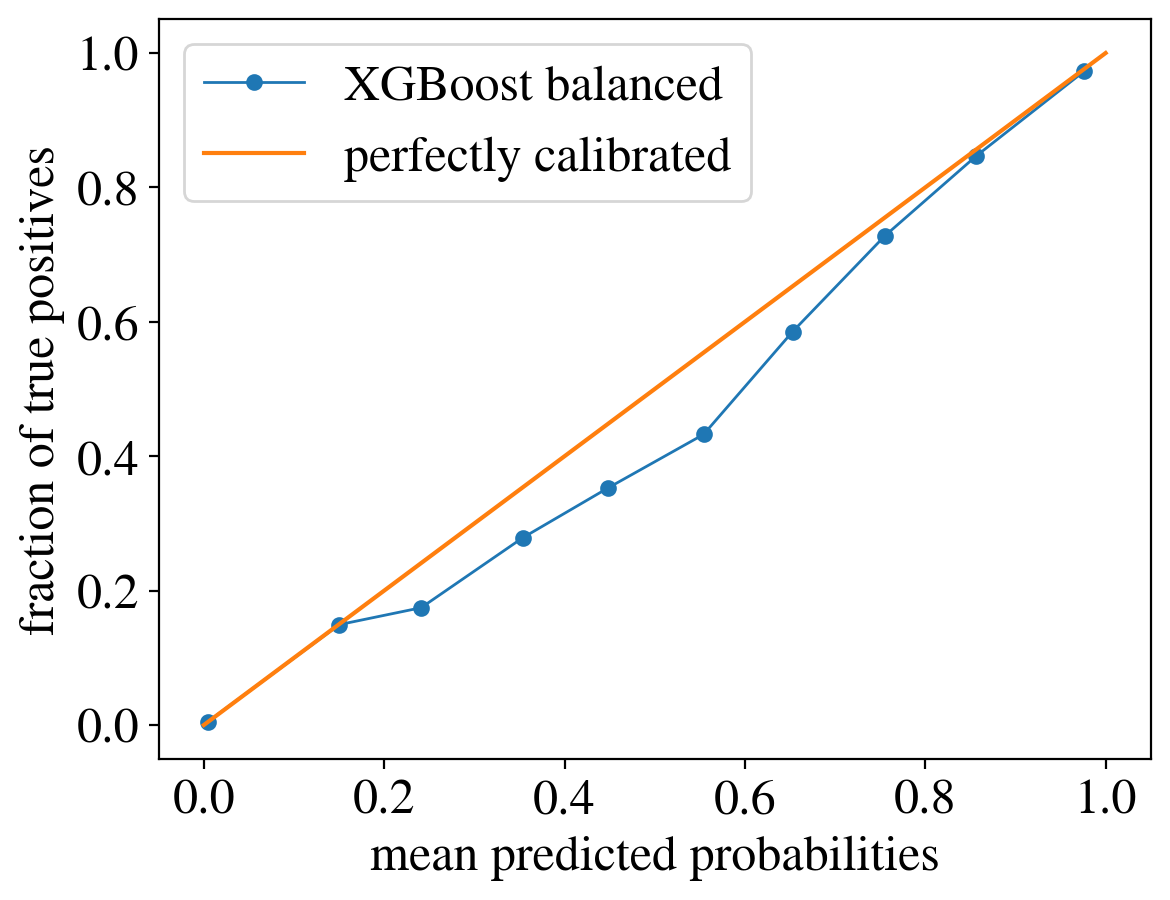

manual classification!


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 235.75it/s]


m1_thrs =  71.75128461885038
f1 score on test =  0.8903809262811729


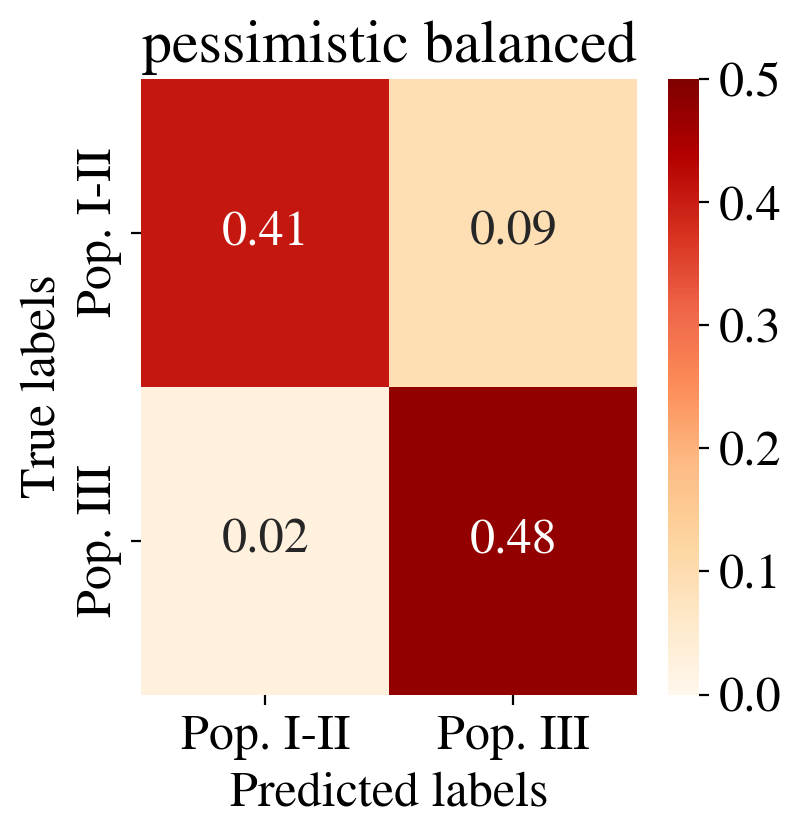

In [11]:
# select the population 
Pop_model = ['fiducial','optimistic','pessimistic']
#Pop_model = ['pessimistic']

#cut_on_rel = [0.1,0.2,0.5,0.8,1]
cut_on_rel = [0.3]
#cut_on_rel = [0.9]


priors = [True] 
# with priors == False it performs classification on true parameters for any SNR!
# otherwise (priors == True) it does classification on balanced instances with resampled max posteriors and SNR and P.E. cut

precisions = np.zeros([len(Pop_model), len(cut_on_rel), len(priors)])

indeces_to_use_all = []

for i_p, p in enumerate(Pop_model):
    for i_c, c in enumerate(cut_on_rel):
        for i_s, s in enumerate(priors):
            print(p)
            precisions[i_p, i_c, i_s], indeces_to_use_all_one  = combine_all(p, c, s)
            indeces_to_use_all.append(indeces_to_use_all_one)

In [12]:
def combine_all_pair_plot(Pop_model, cut_on_rel):
    '''
    This function creates a pair plot representing the datasets in the feature space.
    
    Parameters:
    - Pop_model: The selected BBH population model. 
                 It can be 'pessimistic', 'fiducial', or 'optimistic' for Pop. III BBH. 
                 For Pop. I-II, the 'fiducial' model is automatically selected.
    - cut_on_rel: A value between 0 and 1, representing the upper limit on relative error applied to all parameters.
    
    Returns:
    None
    '''
    #leg_t = ['injected', 'measured']
    plt.figure(figsize=(8,8))
    tt = 0
    colors = ['darkblue','darkred']
    legends = [['Pop. III BBH'],['Pop. I-II BBH']]
    lines = []
    
    codes_leg = ['GWFish Pop. III', 'GWFish Pop. I-II']

    models_fish = Pop_model
    psds = ['ET_cryo']
    # corner plot labels
    corner_lbs = ['$m_{1,\\mathrm{d}}$ [M$_\\odot$]', '$m_{2,\\mathrm{d}}$ [M$_\\odot$]', '$D_{l}$ [Mpc]']
    #['$m_{1,\mathrm{d}}$ [M$_\odot$]', 
                 # '$m_{2,\mathrm{d}}$ [M$_\odot$]',
                 # '$D_{l}$ [Mpc]']

    # I apply some cut to keep a sample of well measured instances
    SNRth = 12
    thrs_m1 = cut_on_rel
    thrs_m2 = cut_on_rel
    thrs_L = cut_on_rel

    for t in [True]:
        print(tt)
        print('currently processing...', Pop_model, cut_on_rel, t)

        for c, code_i in enumerate(codes_leg):
            print('code_i', code_i)

                
            if code_i == codes_leg[1]:#fisher_matrix_code+'/pop12_10yr_v2':
                model_here = 'fiducial'
                model_meas = 'Pop.I'
                duration = '10'
                model_here_abv = 'pop12'
            else:
                model_here = models_fish
                model_meas = 'Pop.III'
                if model_here == 'fiducial':
                    #duration = '150'
                    duration = '1500'
                    model_here_abv = 'pop3_fid'
                elif model_here == 'pessimistic':
                    #duration = '5000'
                    duration = '50000'
                    model_here_abv = 'pop3_pess'
                elif model_here == 'optimistic':
                    #duration = '10'
                    duration = '85'
                    model_here_abv = 'pop3_opt'
                
                
            in_folder = path_local+code_i
            print('    ',model_here)
            psd = psds[0]
            print('    ',psd)            

            if (t == True): #and (code_i != fisher_matrix_code+'/BBH_Pop1_2_right_order'):

                # load the pre sampled catalogs
                # this is for the 0.8 cut on relative error
                #path_to_file = 'measured_values/meas_cat_'+model_meas+'_'+model_here+'_0.8.dat'
                path_to_file = 'measured_values_v1/meas_cat_'+model_meas+'_'+model_here+'_'+str(cut_on_rel)+'_'+duration+'yr_'+FinalStatement+'.dat'
                if os.path.exists(path_to_file) == True:
                    new_data = pd.read_csv(path_to_file, names = lbs_r, 
                                           delimiter = ',', low_memory = False, skiprows = 1)
                else: 
                    print(path_to_file)
                    raise ValueError('presampled catalogs have not been found!')


                # I need to reapply the cut
                # cut on SNR
                SNRs = np.array(new_data['network_SNR']) 
                r_ind_snr = np.nonzero(SNRs>SNRth)[0]
                #print('snr',len(r_ind_snr))

                # the indexing is different from the original data but this is not a problem 
                dm1 = np.array(new_data['err_mass_1'])
                dm2 = np.array(new_data['err_mass_2'])
                dL = np.array(new_data['err_luminosity_distance'])
                # load features
                m1 = np.array(new_data['mass_1'])
                m2 = np.array(new_data['mass_2'])
                L = np.array(new_data['luminosity_distance'])
                # here I apply the cuts on relative error
                r_ind_m1 = np.nonzero(dm1/m1 < thrs_m1)[0]
                #print('m1',len(r_ind_m1))
                r_ind_m2 = np.nonzero(dm2/m2 < thrs_m2)[0]
                #print('m2',len(r_ind_m2))
                r_ind_L = np.nonzero(dL/L < thrs_L)[0]
                #print('L',len(r_ind_L))
                r_ind_p = [r_ind_snr, r_ind_m1, r_ind_m2, r_ind_L]
                r_ea = list(set.intersection(*map(set, r_ind_p)))


                #print(r_ea)
                #print('number of measured instances', len(r_ea))
                if len(r_ea) <= 1:
                    raise ValueError('There are no systems with this option. Exiting function')

                print('minimum SNR ', np.min(new_data['network_SNR'].iloc[r_ea]))

                ## load features --> these features are the new resampled max posteriors
                #r_m1 = np.array(new_data['r_mass_1'].iloc[r_ea])
                #r_m2 = np.array(new_data['r_mass_2'].iloc[r_ea]) 
                #r_L = np.array(new_data['r_luminosity_distance'].iloc[r_ea])
                
                # load features --> these are the true injected values 
                print(' training is done on injected parameters!')
                
                #r_m1_r = np.array(new_data['mass_1'].iloc[r_ea])
                #r_m2_r = np.array(new_data['mass_2'].iloc[r_ea]) 
                #r_L_r = np.array(new_data['luminosity_distance'].iloc[r_ea])
                ## we have repeated objects in these data, I resample from a KDE
                #r_data = np.transpose(np.stack([r_m1_r, r_m2_r, r_L_r], axis = 1))
                ##print(r_data.shape)
                #kde = gaussian_kde(r_data, bw_method = 0.002)
                #r_data_resampled = kde.resample(len(r_m1_r), seed = 42)
                ##print(r_data_resampled)
                #r_m1 = r_data_resampled[0,:]
                #print(r_m1[r_m1<0])
                #r_m2 = r_data_resampled[1,:]
                #print(r_m2[r_m2<0])
                #r_L = r_data_resampled[2,:]
                #print(r_L[r_L<0])
                ## you can get negative values! I decreased the bw_method
                #print('max redshift', np.max( np.array(new_data['redshift'].iloc[r_ea]) ))
                
                # and build the instances 
                #samples = np.stack([r_m1, r_m2, r_L], axis = 1)   
                #print(samples)
                path_to_file_kde = 'measured_values_v1/kde_cat_'+model_meas+'_'+model_here+'_'+str(cut_on_rel)+'_'+duration+'yr_'+FinalStatement+'.dat'
                samples = np.loadtxt(path_to_file_kde)
            
            # save  for the two classes
            if code_i == codes_leg[0]:#fisher_matrix_code+'/pop3':
                if Pop_model == 'fiducial':
                    title_here = Pop_model+r' balanced'
                elif Pop_model == 'pessimistic':
                    title_here = Pop_model+r' balanced'
                elif Pop_model == 'optimistic':
                    title_here = Pop_model+r' balanced'
                
                #print('code_i',code_i)
                #print(samples[0,:])
                s1 = pd.DataFrame({
                    r'$m_{1,\mathrm{d}}$ [M$_\odot$]': samples[:,0],
                               r'$m_{2,\mathrm{d}}$ [M$_\odot$]': samples[:,1],
                                r'$d_{L}$ [Mpc]': samples[:,2],
                                " ": title_here
                              })
                print(s1)
            elif code_i == codes_leg[1]: #fisher_matrix_code+'/pop12_10yr_v2':
                print('code_i',code_i)
                s2 = pd.DataFrame({
                    r'$m_{1,\mathrm{d}}$ [M$_\odot$]': samples[:,0],
                    r'$m_{2,\mathrm{d}}$ [M$_\odot$]': samples[:,1],
                    r'$d_{L}$ [Mpc]': samples[:,2],
                    " ": "Pop. I-II BBHs"
                              })
                samples_all = pd.concat([s1, s2],axis = 0,ignore_index = True)
               
                print(samples_all)



        g = sns.PairGrid(samples_all, hue = ' ', palette = colors, hue_order = [title_here,'Pop. I-II BBHs'])
        #print(samples_all)
        nbb = 20
        nbins = iter([np.logspace(0.7,3.1,nbb),
                      np.logspace(0.7,3.1,nbb),
                      np.logspace(0.7,3.1,nbb),
                      np.logspace(0.7,3.1,nbb),
                      np.logspace(2,5.5,nbb),
                      np.logspace(2.5,5.5,nbb)])
        def myhist(*args, **kwargs):
            sns.histplot(*args, bins=next(nbins), **kwargs, #stat = 'count'
                         stat = 'probability'
                         , kde = False)
        g.map_diag(myhist)



        #g.map_diag(sns.histplot, bins = np.logspace(0.7,3.1,50))
        #g.map_offdiag(sns.scatterplot, alpha = 1)
        g.map_upper(sns.scatterplot, alpha = 1, s = 10)
        g.map_lower(sns.kdeplot, 
                    fill = True, 
                    log_scale = True, 
                    bw_method = 0.2,
                    #levels = [1 - np.exp(-0.5),1 - np.exp(-2),1 - np.exp(-9 / 2.)],
                    levels = 20, 
                    common_norm = True, 
                    common_grid = True,
                    #hue_norm = LogNorm(0,100),
                    #hue = 'BBHs',
                    #data = samples_all
                    alpha = 0.5,
                    thresh = 0.01,
                   )

        handles = g._legend_data.values()
        labels = g._legend_data.keys()
        g.add_legend(ncols = 2)#loc='upper right')
        g._legend.set_bbox_to_anchor((0.5, 1.01))
        
        for ax in g.axes.flat:
            #print('xlabel = ',ax.get_xlabel(),'ylabel = ',ax.get_ylabel())
            #print(corner_lbs)
            ax.set(xscale="log")
            ax.set(yscale="log")
            
            if ax.get_xlabel() == '$d_{L}$ [Mpc]': 
                locmin = matplotlib.ticker.LogLocator(base=10.0,
                                                      subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),
                                                      numticks=10)
                ax.xaxis.set_minor_locator(locmin)
                ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
                ax.set_xticks([1e3, 1e4, 1e5])
                ax.set_xticklabels([r'$10^3$',r'$10^4$', r'$10^5$'])
                

        plt.savefig(folder_out+'pair_plots/all_'+Pop_model+'_'+str(cut_on_rel)+'.pdf', 
                    format = 'pdf', bbox_inches = 'tight')
        plt.savefig(folder_out+'pair_plots/all_'+Pop_model+'_'+str(cut_on_rel)+'.png', 
                    format = 'png', bbox_inches = 'tight', dpi = 300)
        tt += 1

        plt.show()






In [13]:
# this allows to skip the pair plot 
skip_pairplot = True

In [14]:
if skip_pairplot == False:
    # extra parameters
    Pop_model = ['fiducial','optimistic','pessimistic']
    #Pop_model = ['pessimistic']
    #cut_on_rel = [0.3]
    
    c = cut_on_rel[0]
    
    for i_p, p in enumerate(Pop_model):
        combine_all_pair_plot(p, c)
        


In [15]:
def apply_prior(p, N3, N2):
    """
    This function converts from $p(j \in k|\mathbf{x}, d_j)$ to $p(j \in k|\mathbf{x}, d_j, \{β\})$.
    
    Parameters:
    - p: Probability extracted from the classifier using the method predict_proba.
    - N3: Number of Pop. III BBHs.
    - N2: Number of Pop. I-II BBHs.
    
    Returns:
    - p_post: Probability corrected for imbalance.
    """
    #Q = p/(1-p)*N3/N2
    # changed as now is in the paper
    p_post = (p*N3)/(p*(N3-N2)+N2)

    return p_post #Q/(1+Q)

In [16]:
# classifying detections 

def check_posteriors(model_here, cut_on_rel, model_meas, priors, indeces_to_use, check_robust = False, manual_option = False):
    """
    This function evaluates the probability for each posterior sample for all the expected detections to belong to the Pop. III BBH class.
    
    Parameters:
    - model_here: The selected BBH population model. 
                  It can be 'pessimistic', 'fiducial', or 'optimistic' for Pop. III BBH. 
                  For Pop. I-II, it can be 'fiducial'.
    - cut_on_rel: A value between 0 and 1, representing the upper limit on relative error applied to all parameters.
    - model_meas: It can be 'Pop.III' or 'Pop.I'.
    - priors: A string used to load the results.
    - indices_to_use: Indices of the instances used for testing. It is an output of combine_all (see above).
    - check_robust: Deprecated (default == False).
    - manual_option: If True, classification is done with the manual classifier (default == False). Otherwise, it uses the method preditc_proba
    
    Returns:
    - p_PopIII_arr: Average probability for each detection to belong to the Pop. III class.
    - dl_med_arr: Median luminosity distance for each detection.
    - central_values_arr: Maximum posterior for all the parameters for each detection.
    - medians_arr: Medians for all the parameters for each detection.
    - all_predictions: Probability for each posterior sample for all the expected detections to belong to the Pop. III BBH class.
    """
        
    
    # get luminosity distance for each instance
    path_to_file = 'test_catalogs_v1/median_cat_'+model_meas+'_'+model_here+'_'+str(cut_on_rel)+'_10yr_'+FinalStatement+'.dat'
    if os.path.exists(path_to_file) == True:
        new_data = pd.read_csv(path_to_file, names = lbs_r, 
                                   delimiter = ',', low_memory = False, skiprows = 1)
    else: 
        print(path_to_file)
        raise ValueError('presampled catalogs have not been found!')

    if model_meas == 'Pop.I':
        print('index used')
        # select subsample based on indeces_to_use
        index_subsample = indeces_to_use
        print(len(index_subsample))
    else: #model_meas == 'Pop.III' or model_meas == 'Seed_':
        num_of_popIII = new_data.shape[0]
        # here I need to take the subsample of PopIII
        np.random.seed(45)
        index_subsample = np.random.choice(np.arange(num_of_popIII), size = int(0.3*num_of_popIII), replace = False)
        print(index_subsample)
        np.savetxt(folder_out+'indices_to_use_Pop.III_'+model_here+'_'+str(cut_on_rel)+'.txt', index_subsample)
        
    # I need to load the resampled luminosity distance
    dl_med_arr = new_data['r_luminosity_distance'].loc[index_subsample]
        
    
    # load the posteriors catalogs
    path_to_file = 'test_catalogs_v1/test_cat_'+model_meas+'_'+model_here+'_'+str(cut_on_rel)+'_10yr_'+FinalStatement+'.h5'
    if os.path.exists(path_to_file) == True:
        f1 = h5py.File(path_to_file,'r')  
        #f1 = pd.read_hdf(path_to_file,mode = 'r') 
    else: 
        print(path_to_file)
        raise ValueError('presampled catalogs have not been found!')
    
    # load classifier
    xgb_clf_loaded = XGBClassifier()
    if check_robust == True:
        if model_here == 'optimistic':
            model_here_load = 'pessimistic'
            xgb_clf_loaded.load_model(folder_out+'/xgb_model_'+model_here_load+'_'+str(cut_on_rel)+'_True.json')

    else:
        if model_here == 'fiducial' and cut_on_rel == 0.4:
            print('taking 0.3')
            xgb_clf_loaded.load_model(folder_out+'/xgb_model_'+model_here+'_0.3_True.json')
        else:
            xgb_clf_loaded.load_model(folder_out+'/xgb_model_'+model_here+'_'+str(cut_on_rel)+'_'+str(priors)+'.json')


    #print(print(list(f1.keys())))
    # for each instance check samples
    num_sam = len(np.array(f1['instance_0']['samples'][0]))
    
    count_good = 0
    num_of_instances = len(index_subsample) #len(f1.keys())
    print('number of instances', num_of_instances)
    print('number of samples for each instance', num_sam)

    #plt.figure()
        
    p_PopIII_arr = []
    all_predictions = []
    #bayes_0_ratio_arr = []
    medians_arr = np.zeros((num_of_instances,3))
    central_values_arr = np.zeros((num_of_instances,3))


    if manual_option == False:
        for i_c, i in (enumerate(tqdm(index_subsample))):
            #print(f1[i].keys())
            #print(np.array(f1['instance_0']['samples']))
            #print(i_c)
        
            #X_test = np.transpose(f1['instance_'+str(i_c)]['samples'])
            #### ---- it should go over i not i_c !!!!!
            X_test = np.transpose(f1['instance_'+str(i)]['samples'])

            #### ---- it should go over i not i_c !!!!!
            # I need to take in account the resampled values
            #central_values = [new_data['mass_1'].iloc[i_c],
            #                 new_data['mass_2'].iloc[i_c],
            #                 new_data['luminosity_distance'].iloc[i_c]]
            central_values = [new_data['mass_1'].iloc[i],
                 new_data['mass_2'].iloc[i],
                 new_data['luminosity_distance'].iloc[i]]
            
            #print('resampled values', central_values)
            central_values_arr[i_c,:] = central_values
            medians = np.median(X_test, axis = 0)
            medians_arr[i_c,:] = medians
            #print('median of posterior samples', medians)
            #print('')
            prediction = xgb_clf_loaded.predict_proba(X_test)
            #print(prediction)
            all_predictions.append(prediction[:,1])
            # here I need to calculate the weights

            #weights = WeightCalculation(model_here, cut_on_rel, X_test)
            
            p_PopIII = np.sum(prediction[:,1])/num_sam
            p_PopIII_arr.append(p_PopIII)

      
    elif manual_option == True:

        p_PopIII_arr = []
        if model_here == 'fiducial':
            m1_thr = 61.94
        elif model_here == 'optimistic':
            m1_thr = 56.71
        elif model_here == 'pessimistic':
            m1_thr = 71.75
            
        for i_c, i in (enumerate(tqdm(index_subsample))):

            #### ---- it should go over i not i_c !!!!!
            X_test = np.transpose(f1['instance_'+str(i)]['samples'])
            medians = np.median(X_test, axis = 0)
            medians_arr[i_c,:] = medians
            #print('number of samples for each instance', num_sam)
            
            prediction = np.zeros(num_sam)
            for i_x in range(num_sam):
                if (X_test[i_x,0] > m1_thr): 
                    prediction[i_x] = 1
                else:
                    prediction[i_x] = 0
                    
            all_predictions.append(prediction)
    
    
    return p_PopIII_arr, dl_med_arr, central_values_arr, medians_arr, all_predictions
        



In [17]:
# check posterios
Pop_model = ['fiducial']

#cut_on_rel = [0.3]
c = cut_on_rel[0]



for i_p, p in enumerate(Pop_model):
    print(p)
    #figure_2 = plt.figure(figsize=(10,10))
    print(len(indeces_to_use_all[i_p]))
    p_PopIII_arr_popI, dl_med_arr_popI, central_values_popI, medians_arr_popI, all_predicitions_popI = check_posteriors(p, c, 'Pop.I', priors[0], indeces_to_use_all[i_p])
    np.savetxt(folder_out+'p_PopIII_PopI.txt', np.transpose([medians_arr_popI[:,0],medians_arr_popI[:,1],medians_arr_popI[:,2],p_PopIII_arr_popI]),
              header = 'med_mass_1 med_mass_2 med_lum_dist p_PopIII', comments = '')

fiducial
3420
index used
3420
number of instances 3420
number of samples for each instance 1000


100%|███████████████████████████████████████| 3420/3420 [01:40<00:00, 34.13it/s]


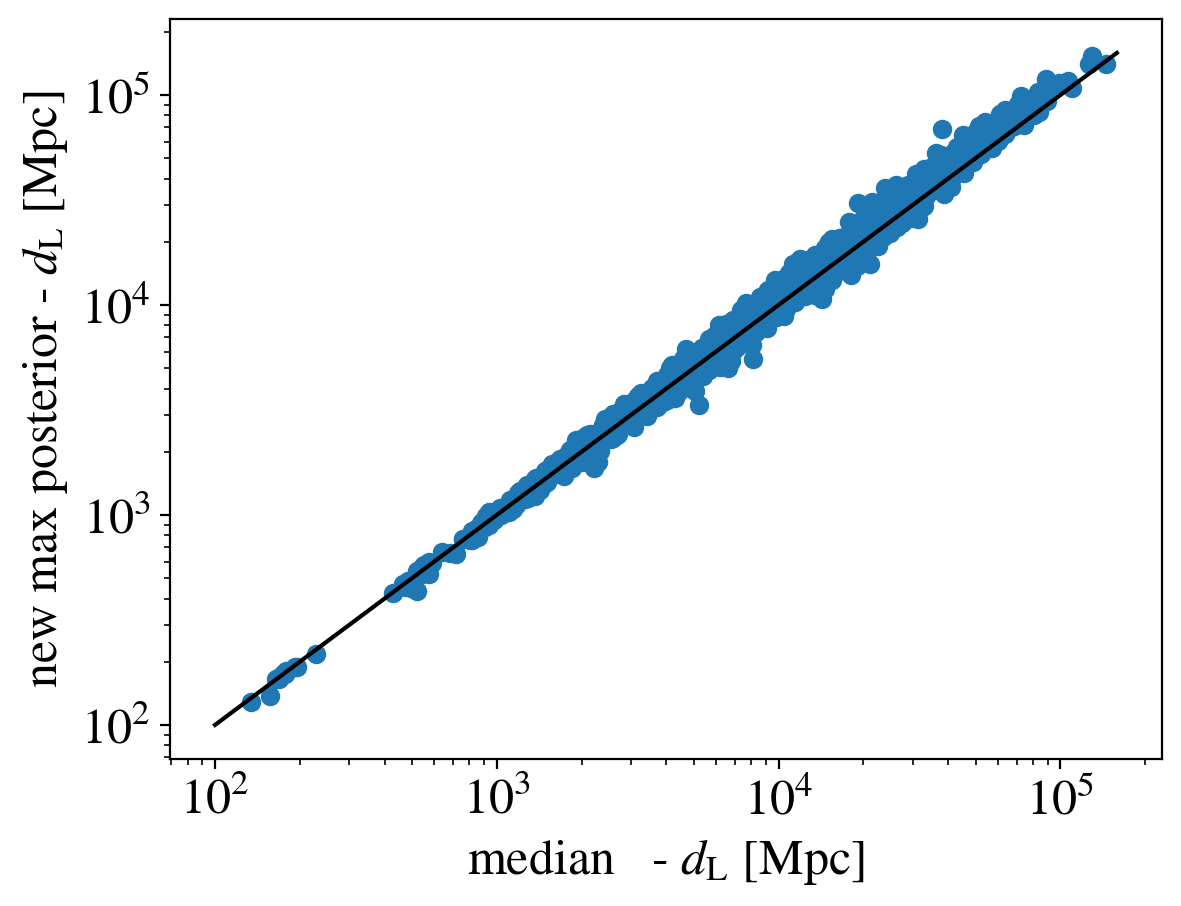

In [18]:
#print(central_values_popI)
#print(medians_arr_popI)
plt.scatter(medians_arr_popI[:,2],central_values_popI[:,2])
plt.plot(np.logspace(2,5.2,100),np.logspace(2,5.2,100), color = 'black')
plt.xlabel('median   - $d_{\mathrm{L}}$ [Mpc]')
plt.ylabel('new max posterior - $d_{\mathrm{L}}$ [Mpc]')


plt.xscale('log')
plt.yscale('log')


In [19]:
# check posterios
Pop_model = ['fiducial','optimistic','pessimistic']
#cut_on_rel = [0.3]

c = cut_on_rel[0]

central_values_popIII_all = []
p_PopIII_arr_popIII_all = []
medians_arr_popIII_all = []
all_predictions_popIII_all = []

for i_p, p in enumerate(Pop_model):
    print(p)
    #figure_2 = plt.figure(figsize=(10,10))
    p_PopIII_arr_popIII, dl_med_arr_popIII, central_values_popIII, medians_arr_popIII, all_predictions_popIII = check_posteriors(p, c, 'Pop.III', priors[0], indeces_to_use_all[i_p])
    central_values_popIII_all.append(central_values_popIII)
    p_PopIII_arr_popIII_all.append(p_PopIII_arr_popIII)
    medians_arr_popIII_all.append(medians_arr_popIII)
    all_predictions_popIII_all.append(all_predictions_popIII)
    np.savetxt(folder_out+'p_PopIII_'+p+'.txt', np.transpose([medians_arr_popIII[:,0],medians_arr_popIII[:,1],medians_arr_popIII[:,2],p_PopIII_arr_popIII]),
              header = 'med_mass_1 med_mass_2 med_lum_dist p_PopIII', comments = '')

   

fiducial
[ 61 421 223 340 423 191  52 173 342 299 305 387 263 360 440 442 125 149
  14 249 275 260 262 184 347 370 168 129 291  39  50 361 431  38 306 151
 422 101  25 156 403  91 343 169 432  79 329 446 455 336 354  99  64 222
 330  48 365 208   4  69 318  73 108 159  22 200 325 441 195 416 433 250
 102 226 227 271 321 424 353 280 369  13 257 258  20  10 350 461 390 188
 395 317 259 332 246  28  35 296 279 219 301 132 284 134 411 363 122 351
   3  63 339 128 216 206 161 352 180  33  76 210 240 220  72  45 148 384
 104 133 313 118 112 190  96 451 320 452 166 372 261]
number of instances 139
number of samples for each instance 1000


100%|█████████████████████████████████████████| 139/139 [00:04<00:00, 32.73it/s]


optimistic
[3313 6665  865 ... 6410 9443 8464]
number of instances 3055
number of samples for each instance 1000


100%|███████████████████████████████████████| 3055/3055 [01:33<00:00, 32.71it/s]


pessimistic
[12 16 18 19 21  2]
number of instances 6
number of samples for each instance 1000


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 23.47it/s]


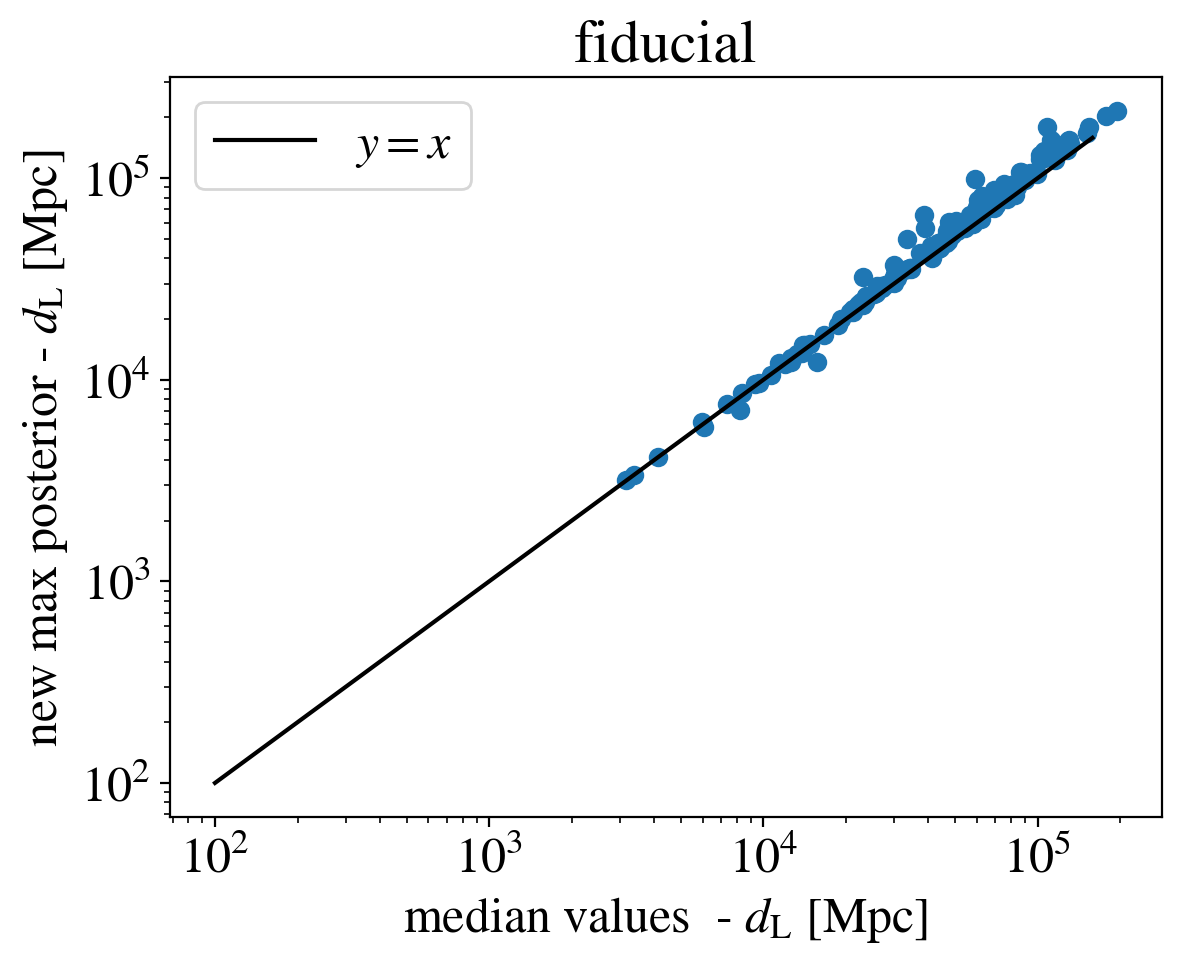

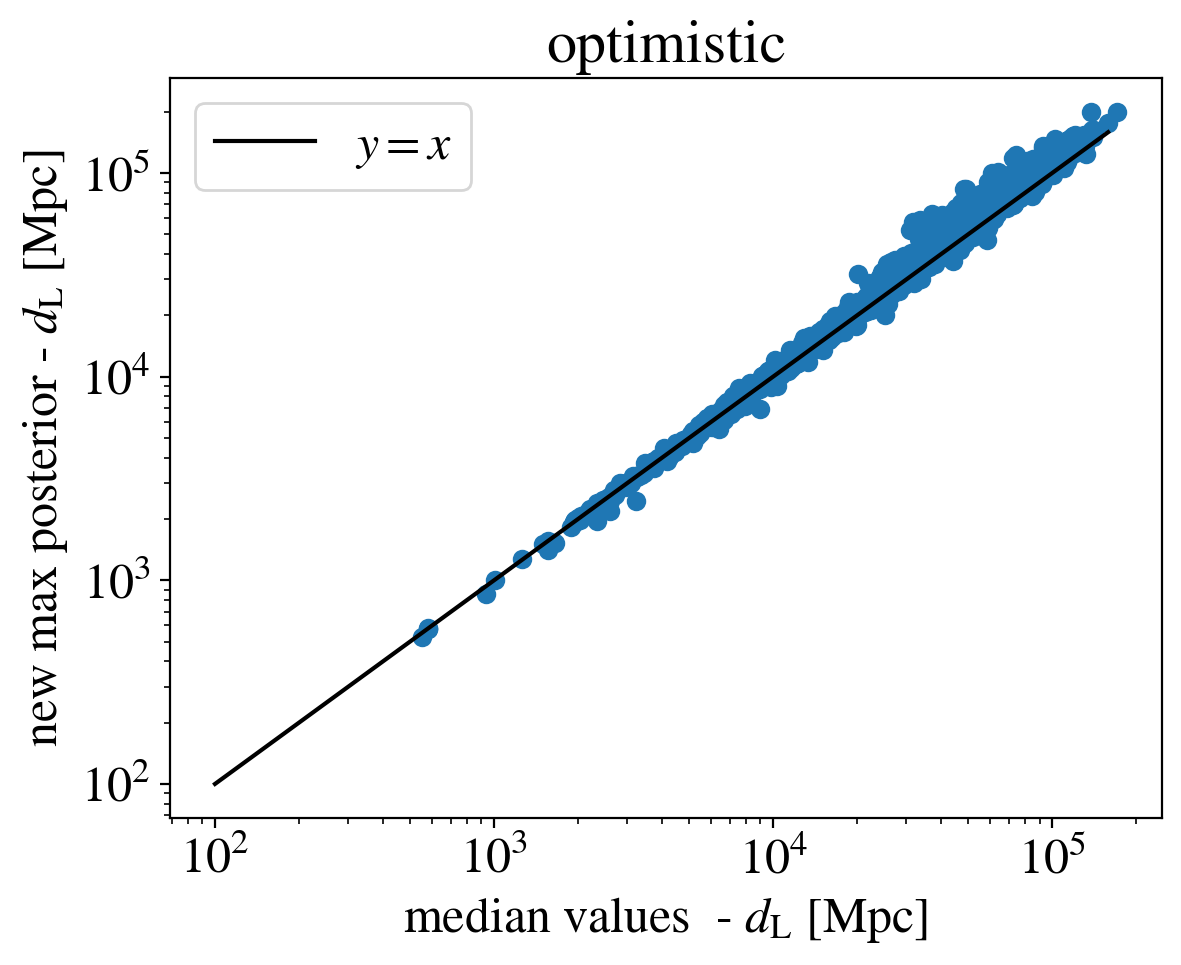

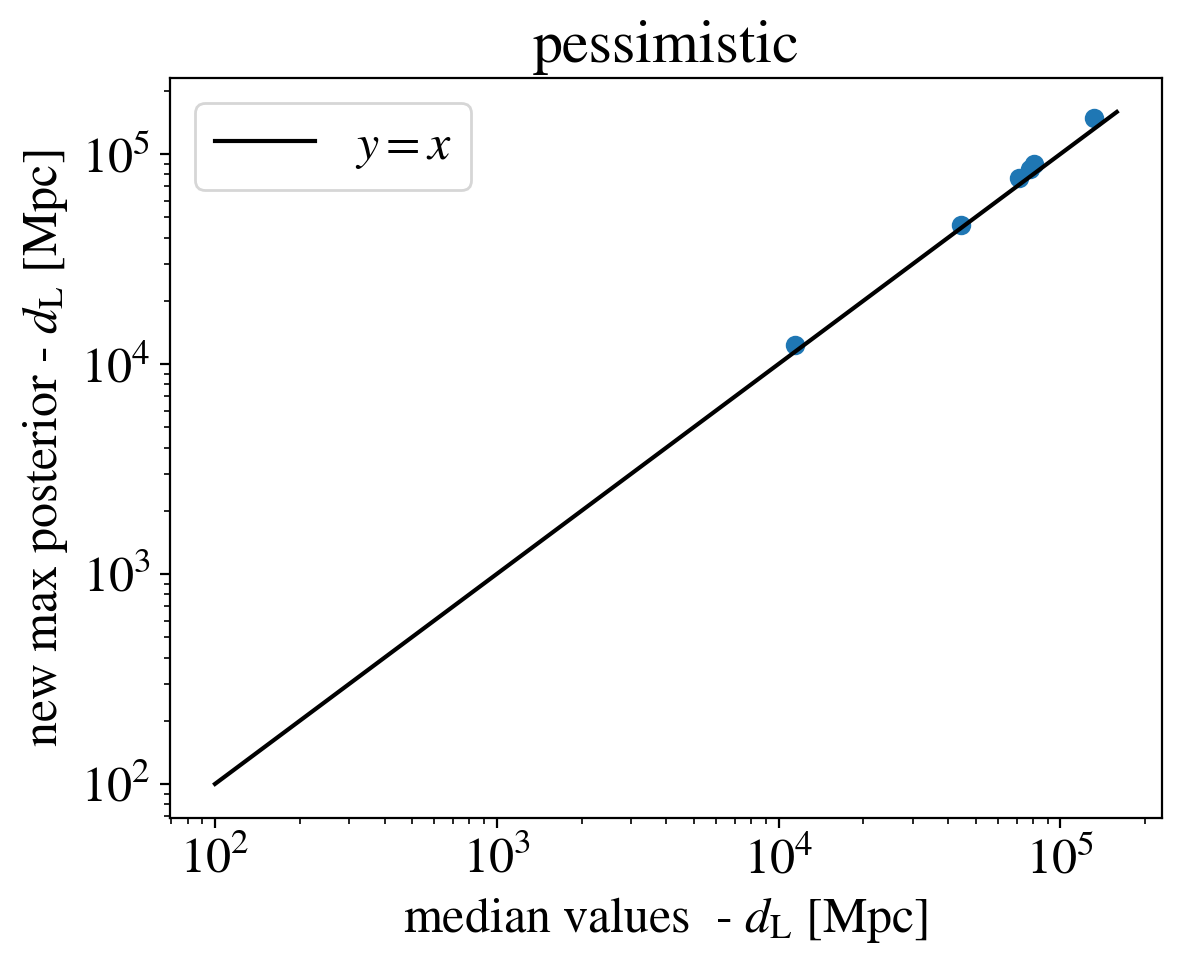

In [20]:
#print(central_values_popI)
#print(medians_arr_popI)
for i in range(len(Pop_model)):
    plt.scatter(medians_arr_popIII_all[i][:,2],central_values_popIII_all[i][:,2])
    plt.plot(np.logspace(2,5.2,100),np.logspace(2,5.2,100), color = 'black', label = r'$y = x$')
    plt.ylabel('new max posterior - $d_{\mathrm{L}}$ [Mpc]')
    plt.xlabel('median values  - $d_{\mathrm{L}}$ [Mpc]')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.title(Pop_model[i])
    plt.show()

3420 139 24.60431654676259
saved p(Pop. III fiducial) for sky localisation
threshold =  0.1
     %TP %TN %FP %FN
     97.84 83.36 16.64 2.16
    precision with custom threshold 0.19
threshold =  0.2
     %TP %TN %FP %FN
     92.09 88.51 11.49 7.91
    precision with custom threshold 0.25
threshold =  0.3
     %TP %TN %FP %FN
     74.82 92.46 7.54 25.18
    precision with custom threshold 0.29
threshold =  0.5
     %TP %TN %FP %FN
     38.13 97.98 2.02 61.87
    precision with custom threshold 0.43
threshold =  0.7
     %TP %TN %FP %FN
     13.67 99.94 0.06 86.33
    precision with custom threshold 0.9
threshold =  0.9
     %TP %TN %FP %FN
     7.19 100.0 0.0 92.81
    precision with custom threshold 1.0
3420 3055 1.1194762684124386
threshold =  0.1
     %TP %TN %FP %FN
     99.87 74.21 25.79 0.13
    precision with custom threshold 0.78
threshold =  0.2
     %TP %TN %FP %FN
     99.61 76.99 23.01 0.39
    precision with custom threshold 0.79
threshold =  0.3
     %TP %TN %FP %FN
     9

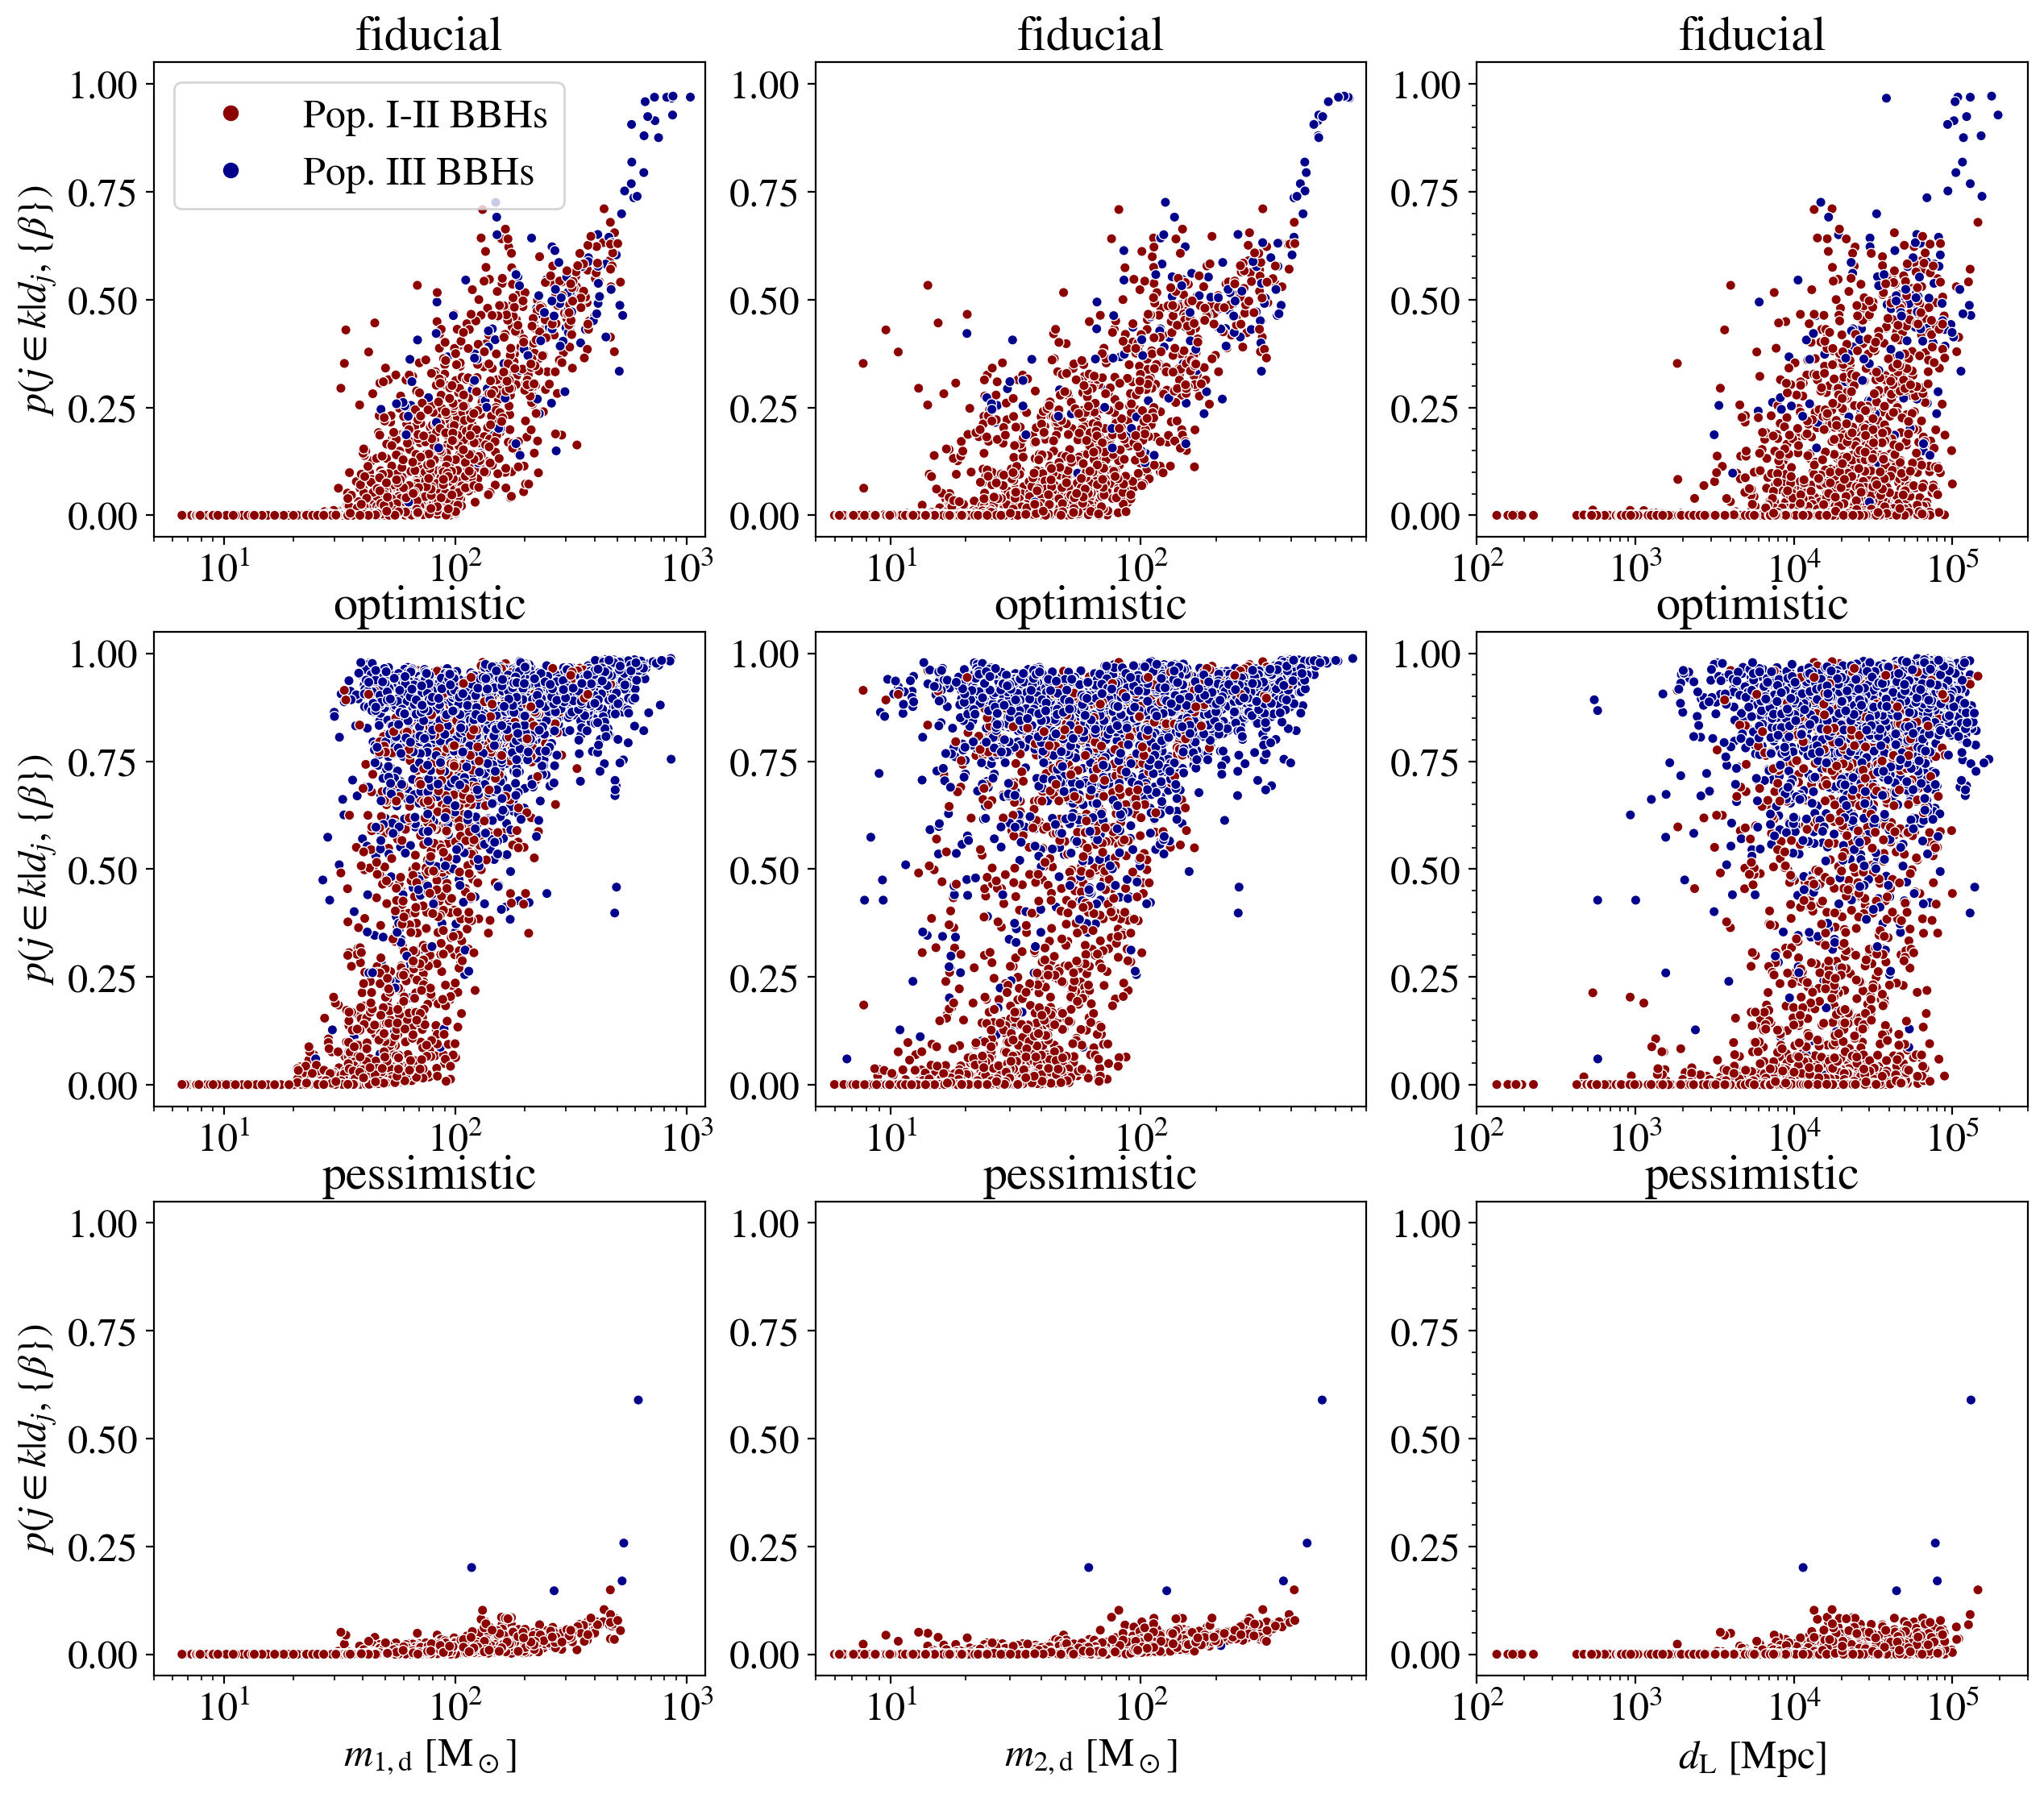

In [60]:
fig, ax1 = plt.subplots(3,3,figsize=(15,13))

Pop_model = ['fiducial','optimistic','pessimistic']

corner_lbs = ['$m_{1,\\mathrm{d}}$ [M$_\\odot$]', '$m_{2,\\mathrm{d}}$ [M$_\\odot$]', '$d_{\mathrm{L}}$ [Mpc]']


TP_arr = []
FP_arr = []
TN_arr = []
FN_arr = []

prec_arr = []
recall_arr = []

all_point_y_all_CorrectionIn = []
all_point_y_all_CorrectionOut = []
all_point_y_all_NoCorrection = []
all_point_y_all_True = []

x_limists = [[5,1200],[5,800],[100,3e5]]
thr_dec = [0.1,0.2,0.3,0.5,0.7,0.9]

for i in range(len(Pop_model)):
    N3 = len(np.array(p_PopIII_arr_popIII_all[i]))
        
    N2 = len(np.array(p_PopIII_arr_popI))

   
    print(N2,N3,N2/N3)
    for y in range(len(corner_lbs)):

        all_points_x = np.concatenate([medians_arr_popI[:,y],medians_arr_popIII_all[i][:,y]])
        #### before first draft
        all_point_y_CorrectionOut = np.concatenate([apply_prior(np.array(p_PopIII_arr_popI),N3,N2),
                                      apply_prior(np.array(p_PopIII_arr_popIII_all[i]),N3,N2)])
        if y == 0:
            all_point_y_all_CorrectionOut.append(all_point_y_CorrectionOut)

        popI_point_y = []
        for i_pred in range(len(p_PopIII_arr_popI)):
            popI_point_y.append(np.sum(apply_prior(np.array(all_predicitions_popI[i_pred]),N3,N2))/1000)
        popIII_point_y = []
        for i_pred in range(len(p_PopIII_arr_popIII_all[i])):
            popIII_point_y.append(np.sum(apply_prior(np.array(all_predictions_popIII_all[i][i_pred]),N3,N2))/1000)
        all_point_y = np.concatenate([popI_point_y, popIII_point_y])
        if Pop_model[i] == 'fiducial' and y == 0:
            print('saved p(Pop. III fiducial) for sky localisation')
            popIII_point_y_save = popIII_point_y
        if y == 0:
            all_point_y_all_CorrectionIn.append(all_point_y)
        if y == 0:
            all_point_y_all_NoCorrection.append(np.concatenate([np.array(p_PopIII_arr_popI),
                                      np.array(p_PopIII_arr_popIII_all[i])]))
        if y == 0:
            all_point_y_all_True.append(np.concatenate([np.zeros(len(np.array(p_PopIII_arr_popI))),
                                      np.ones(len(np.array(p_PopIII_arr_popIII_all[i])))]))

        
        #if i == 2:
        #    ind_m1det = medians_arr_popI[:,0] > 400
        #    print(apply_prior(np.array(all_predicitions_popI)[ind_m1det], N3,N2))
        
        all_colors = np.concatenate([['darkred'] * N2, ['darkblue'] * N3])
        all_symbols = np.concatenate([['o'] * N2, ['s'] * N3])   
        all_labels = np.concatenate([['Pop. I-II BBHs'] * N2, ['Pop. III BBHs'] * N3])   
        
        arr = np.arange(len(all_points_x))
        #print(arr)
        np.random.seed(42)
        np.random.shuffle(arr)
        #print('ind_rand = ', arr)
        ax1[i,y].scatter(all_points_x[arr],all_point_y[arr], c = all_colors[arr],
                      
                      
             marker = 'o', s = 20,
           # label = all_labels[arr], 
                         alpha = 1,
                     #facecolor = 'darkred', 
                         edgecolors = 'w',
                       linewidth = 0.5 , 
                         zorder = 2,
                        )

        ax1[i,y].set_xscale('log')
        ax1[i,y].set_xlim(x_limists[y])
        if y == 2:
            ax1[i,y].set_xticks([100,1_000,10_000,100_000])
            ax1[i,y].minorticks_on()
            ax1[i,y].xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
        #ax1[i,y].set_yscale('logit')
        ax1[i,y].set_ylim([-0.05,1.05])
        #ax1[i,y].grid(True, which="both")

        
        if i == 2:
             ax1[i,y].set_xlabel(corner_lbs[y])
             if y == 2:
                 ax1[i,y].set_xticklabels(['$10^2$','$10^3$','$10^4$','$10^5$'])
        if y == 0:
            #ax1[i,y].set_ylabel(r'$p(\mathrm{Pop. III}|~ {\bf{d}})$')
            ax1[i,y].set_ylabel(r'$p(j\in k | d_j, \{\beta\})$')
        ax1[i,y].set_title(Pop_model[i])

        # just for the first parameter
        if y == 0:
            #### before first draft
            #p_PopIII_tot = np.concatenate([apply_prior(np.array(p_PopIII_arr_popI),N3,N2),
            #                            apply_prior(np.array(p_PopIII_arr_popIII_all[i]),N3,N2)])
            p_PopIII_tot = all_point_y
            if Pop_model[i] == 'pessimistic':
                print(popIII_point_y)
            correct_tot = np.concatenate([np.zeros(len(p_PopIII_arr_popI)),
                                          np.ones(len(p_PopIII_arr_popIII_all[i]))]) 
            
            TP_arrarr = []
            FP_arrarr = []
            TN_arrarr = []
            FN_arrarr = []

            prec_here_arrarr = []
            recall_here_arrarr = []
            
            for thr in thr_dec:
                print('threshold = ', thr)
                TP = 0
                FP = 0
                TN = 0
                FN = 0
                for i_b, b in enumerate(p_PopIII_tot): 
                    #print(b)
                    if b >= thr:
                        # counting false positive
                        if correct_tot[i_b] == 0:
                            FP += 1
                        # counting true positive
                        elif correct_tot[i_b] == 1:
                            TP += 1
                            
                    elif b <= thr:
                        # counting true negative
                        if correct_tot[i_b] == 0:
                            TN += 1
                        # counting false negative
                        elif correct_tot[i_b] == 1:
                            FN += 1
                            
                # changing in percentages      
                print('    ','%TP', '%TN', '%FP', '%FN')
                print('    ',
                      round(TP/N3*100,2), 
                      round(TN/N2*100,2), 
                      round(FP/N2*100,2), 
                      round(FN/N3*100,2)
                     )
                TP_arrarr.append(round(TP/N3*100,2))
                TN_arrarr.append(round(TN/N2*100,2))
                FP_arrarr.append(round(FP/N2*100,2))
                FN_arrarr.append(round(FN/N3*100,2))
    
                
                if TP == 0 and FP == 0:
                    prec_here = '0'
                else:
                    prec_here =  round(TP/(TP+FP),2)
                    recall_here =  round(TP/(TP+FN),2)
                print('    precision with custom threshold', prec_here) 

                #saving precision
                prec_here_arrarr.append(prec_here)
                recall_here_arrarr.append(recall_here)

    TP_arr.append(TP_arrarr)
    FP_arr.append(FP_arrarr)
    TN_arr.append(TN_arrarr)
    FN_arr.append(FN_arrarr)
    prec_arr.append(prec_here_arrarr)
    recall_arr.append(recall_here_arrarr)
    

#ax1[0,0].legend()

line_1 = Line2D([0], [0], color='darkred',  marker = 'o',linewidth = 0 )
line_2 = Line2D([0], [0], color='darkblue',  marker = 'o',linewidth = 0)
labels = ['Pop. I-II BBHs', 'Pop. III BBHs']
ax1[0,0].legend([line_1,line_2], labels)


plt.savefig(folder_out+'P_odds_ALL_ALL_'+str(cut_on_rel[0])+'.png', 
                    format = 'png', bbox_inches = 'tight',dpi = 135)

plt.show()

[[0.1 97.84 83.36 16.64 2.16 0.19 0.98]
 [0.2 92.09 88.51 11.49 7.91 0.25 0.92]
 [0.3 74.82 92.46 7.54 25.18 0.29 0.75]
 [0.5 38.13 97.98 2.02 61.87 0.43 0.38]
 [0.7 13.67 99.94 0.06 86.33 0.9 0.14]
 [0.9 7.19 100.0 0.0 92.81 1.0 0.07]]
[[0.1 99.87 74.21 25.79 0.13 0.78 1.0]
 [0.2 99.61 76.99 23.01 0.39 0.79 1.0]
 [0.3 99.21 79.12 20.88 0.79 0.81 0.99]
 [0.5 97.45 83.01 16.99 2.55 0.84 0.97]
 [0.7 91.19 87.84 12.16 8.81 0.87 0.91]
 [0.9 51.23 95.47 4.53 48.77 0.91 0.51]]
[[0.1 83.33 99.91 0.09 16.67 0.62 0.83]
 [0.2 50.0 100.0 0.0 50.0 1.0 0.5]
 [0.3 16.67 100.0 0.0 83.33 1.0 0.17]
 [0.5 16.67 100.0 0.0 83.33 1.0 0.17]
 [0.7 0.0 100.0 0.0 100.0 0 0]
 [0.9 0.0 100.0 0.0 100.0 0 0]]


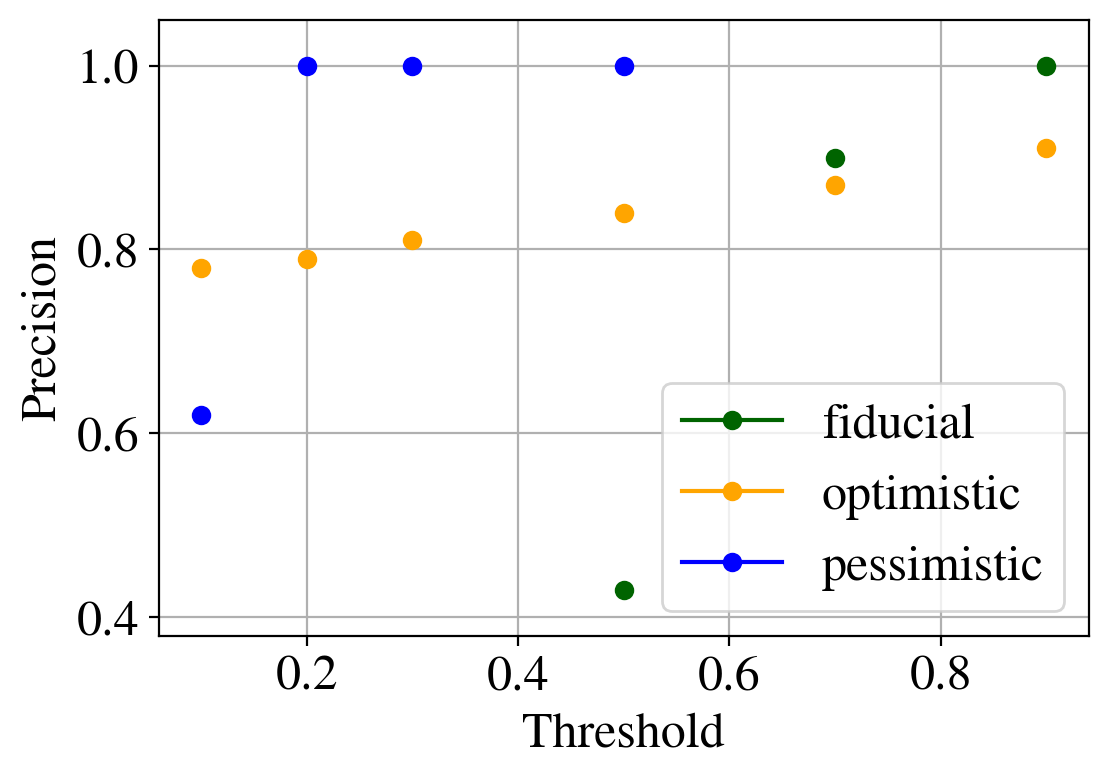

In [22]:
fig, axs = plt.subplots(1,1,figsize=(6,4))

color_mod = ['darkgreen','orange','blue']

for i_mod in range(len(Pop_model)):
    tab = np.zeros((len(thr_dec), 7),dtype='object')
    for i_thr in range(len(thr_dec)):
            TP_in = TP_arr[i_mod][i_thr]
            FP_in = FP_arr[i_mod][i_thr]
            TN_in = TN_arr[i_mod][i_thr]
            FN_in = FN_arr[i_mod][i_thr]
            prec_inin = prec_arr[i_mod][i_thr]
            recall_inin = recall_arr[i_mod][i_thr]
        
            if TP_in == 0 and FP_in == 0:
                prec_in = 0
            else:
                prec_in =  prec_inin #(TP_in)/(TP_in+FP_in)
                if i_thr == 0:
                    axs.plot(thr_dec[i_thr],prec_in, marker = 'o', color = color_mod[i_mod], label = Pop_model[i_mod] )
                else:
                    axs.plot(thr_dec[i_thr],prec_in, marker = 'o', color = color_mod[i_mod])
            if TP_in == 0 and FP_in == 0:
                recall_in = 0
            else:
                #recall_in =  TP_in/(TP_in+FN_in)
                recall_in =  recall_inin
                #if i_thr == 0:
                #    axs.plot(thr_dec[i_thr],recall_in, marker = 's', color = color_mod[i_mod])
                #else:
                #    axs.plot(thr_dec[i_thr],recall_in, marker = 's', color = color_mod[i_mod])

            tab[i_thr,:] = thr_dec[i_thr],TP_in, TN_in, FP_in, FN_in, prec_in, recall_in
    print(tab)


axs.set_xlabel('Threshold')
axs.set_ylabel('Precision')
axs.set_ylim([0.4-0.02,1+0.05])
#ax2 = axs.twinx()
#ax2.set_ylabel('Recall')
#ax2.set_ylim([0.4-0.02,1+0.02])
axs.legend()
axs.grid()
plt.show()

In [23]:
# looking at the effect of extrinsic parameters

# check posterios
Pop_model_seed = ['pessimistic']
Seeds = [10, 10000, 1120, 2230, 3340, 4450, 5560, 6670, 7780, 8890]
#cut_on_rel = [0.3]

c = cut_on_rel[0]

central_values_seed_all = []
p_PopIII_arr_seed_all = []
medians_arr_seed_all = []
all_predictions_seed_all = []

for i_p, p in enumerate(Pop_model_seed):
    print(p)
    for i_sd, sd in enumerate(Seeds):
        print('Seed_',sd)
        p_PopIII_arr_seed, _, central_values_seed, medians_arr_seed, all_predictions_seed = check_posteriors(p, c, 'Seed_'+str(sd), priors[0], indeces_to_use_all[i_p])
        central_values_seed_all.append(central_values_seed)
        p_PopIII_arr_seed_all.append(p_PopIII_arr_seed)
        medians_arr_seed_all.append(medians_arr_seed)
        #print(all_predictions_seed)
        all_predictions_seed_all.append(all_predictions_seed)
        max_seed = 1+i_sd




pessimistic
Seed_ 10
[12 19 16 13 20 10]
number of instances 6
number of samples for each instance 1000


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 23.47it/s]


Seed_ 10000
[13 17 20  2 16 12]
number of instances 6
number of samples for each instance 1000


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 31.11it/s]

Seed_ 1120


[13 17 20  2 16 12]
number of instances 6
number of samples for each instance 1000


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 29.12it/s]


Seed_ 2230
[16 20 13 10 17 24 22]
number of instances 7
number of samples for each instance 1000


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 31.34it/s]


Seed_ 3340
[12 19 16 13 20 10]
number of instances 6
number of samples for each instance 1000


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 37.41it/s]

Seed_ 4450
[9 8 6 2]


number of instances 4
number of samples for each instance 1000


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 40.02it/s]

Seed_ 5560
[9 8 7]


number of instances 3
number of samples for each instance 1000


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 39.12it/s]

Seed_ 6670
[10  9 13  2  6]


number of instances 5
number of samples for each instance 1000


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 33.37it/s]

Seed_ 7780
[16 20 13 10 17 23 21]


number of instances 7
number of samples for each instance 1000


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 36.58it/s]

Seed_ 8890
[12 19 16 13 20 10]


number of instances 6
number of samples for each instance 1000


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 39.00it/s]


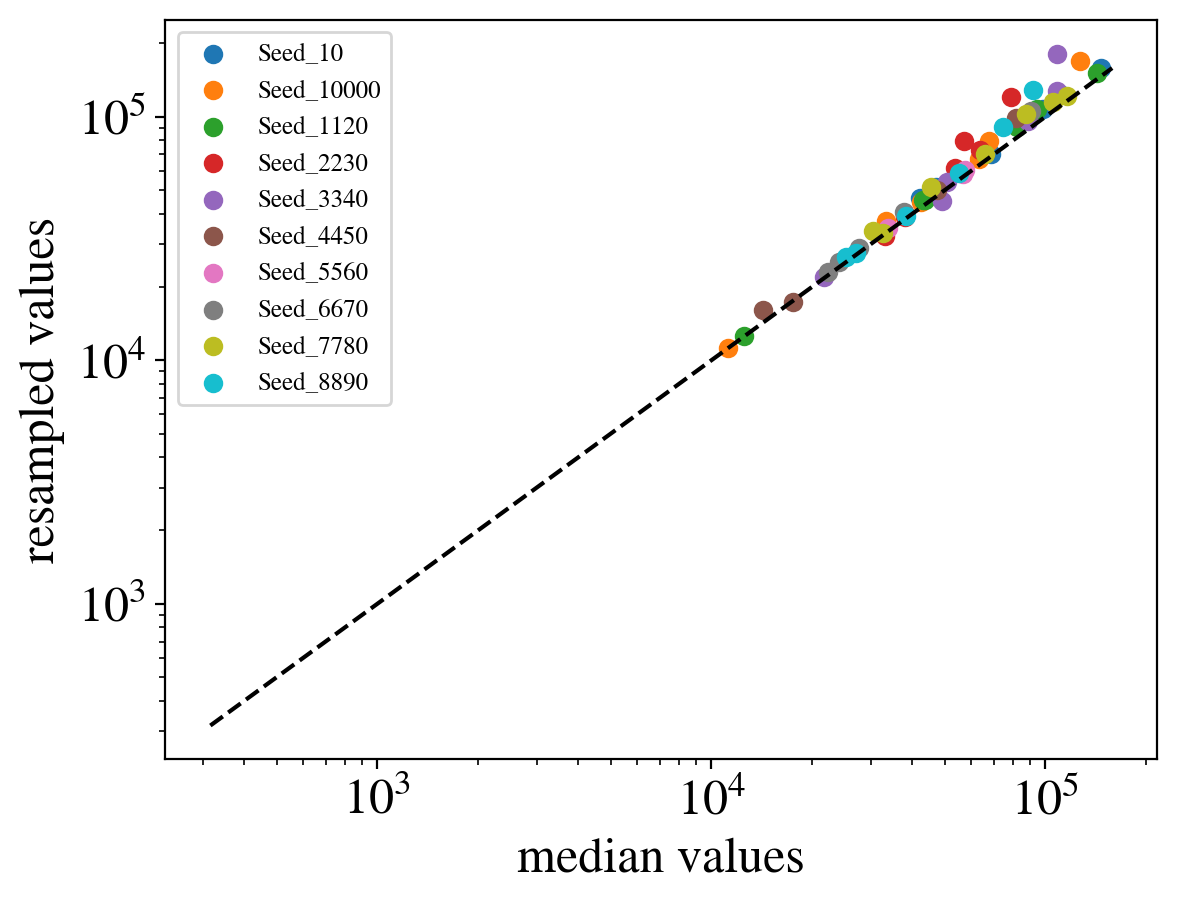

In [24]:
#print(central_values_popI)
#print(medians_arr_popI)
for sd in range(len(Seeds[:max_seed])):
    plt.scatter(medians_arr_seed_all[sd][:,2],central_values_seed_all[sd][:,2],
               label = 'Seed_'+str(Seeds[sd]))

plt.plot(np.logspace(2.5,5.2,100),np.logspace(2.5,5.2,100), color = 'black', ls = '--')
plt.ylabel('resampled values')
plt.xlabel('median values')
plt.legend(fontsize = font_value/2)
plt.xscale('log')
plt.yscale('log')

3420
total number of sources 6
threshold =  0.1
     TP TN FP FN
     3 3417 3 3
50.0
    precision with custom threshold 0.5
    recall with custom threshold 0.5
total number of sources 6
threshold =  0.1
     TP TN FP FN
     4 3417 3 2
66.66666666666666
    precision with custom threshold 0.5714285714285714
    recall with custom threshold 0.6666666666666666
total number of sources 6
threshold =  0.1
     TP TN FP FN
     3 3417 3 3
50.0
    precision with custom threshold 0.5
    recall with custom threshold 0.5
total number of sources 7
threshold =  0.1
     TP TN FP FN
     5 3416 4 2
71.42857142857143
    precision with custom threshold 0.5555555555555556
    recall with custom threshold 0.7142857142857143
total number of sources 6
threshold =  0.1
     TP TN FP FN
     4 3417 3 2
66.66666666666666
    precision with custom threshold 0.5714285714285714
    recall with custom threshold 0.6666666666666666
total number of sources 4
threshold =  0.1
     TP TN FP FN
     2 3419 1 2


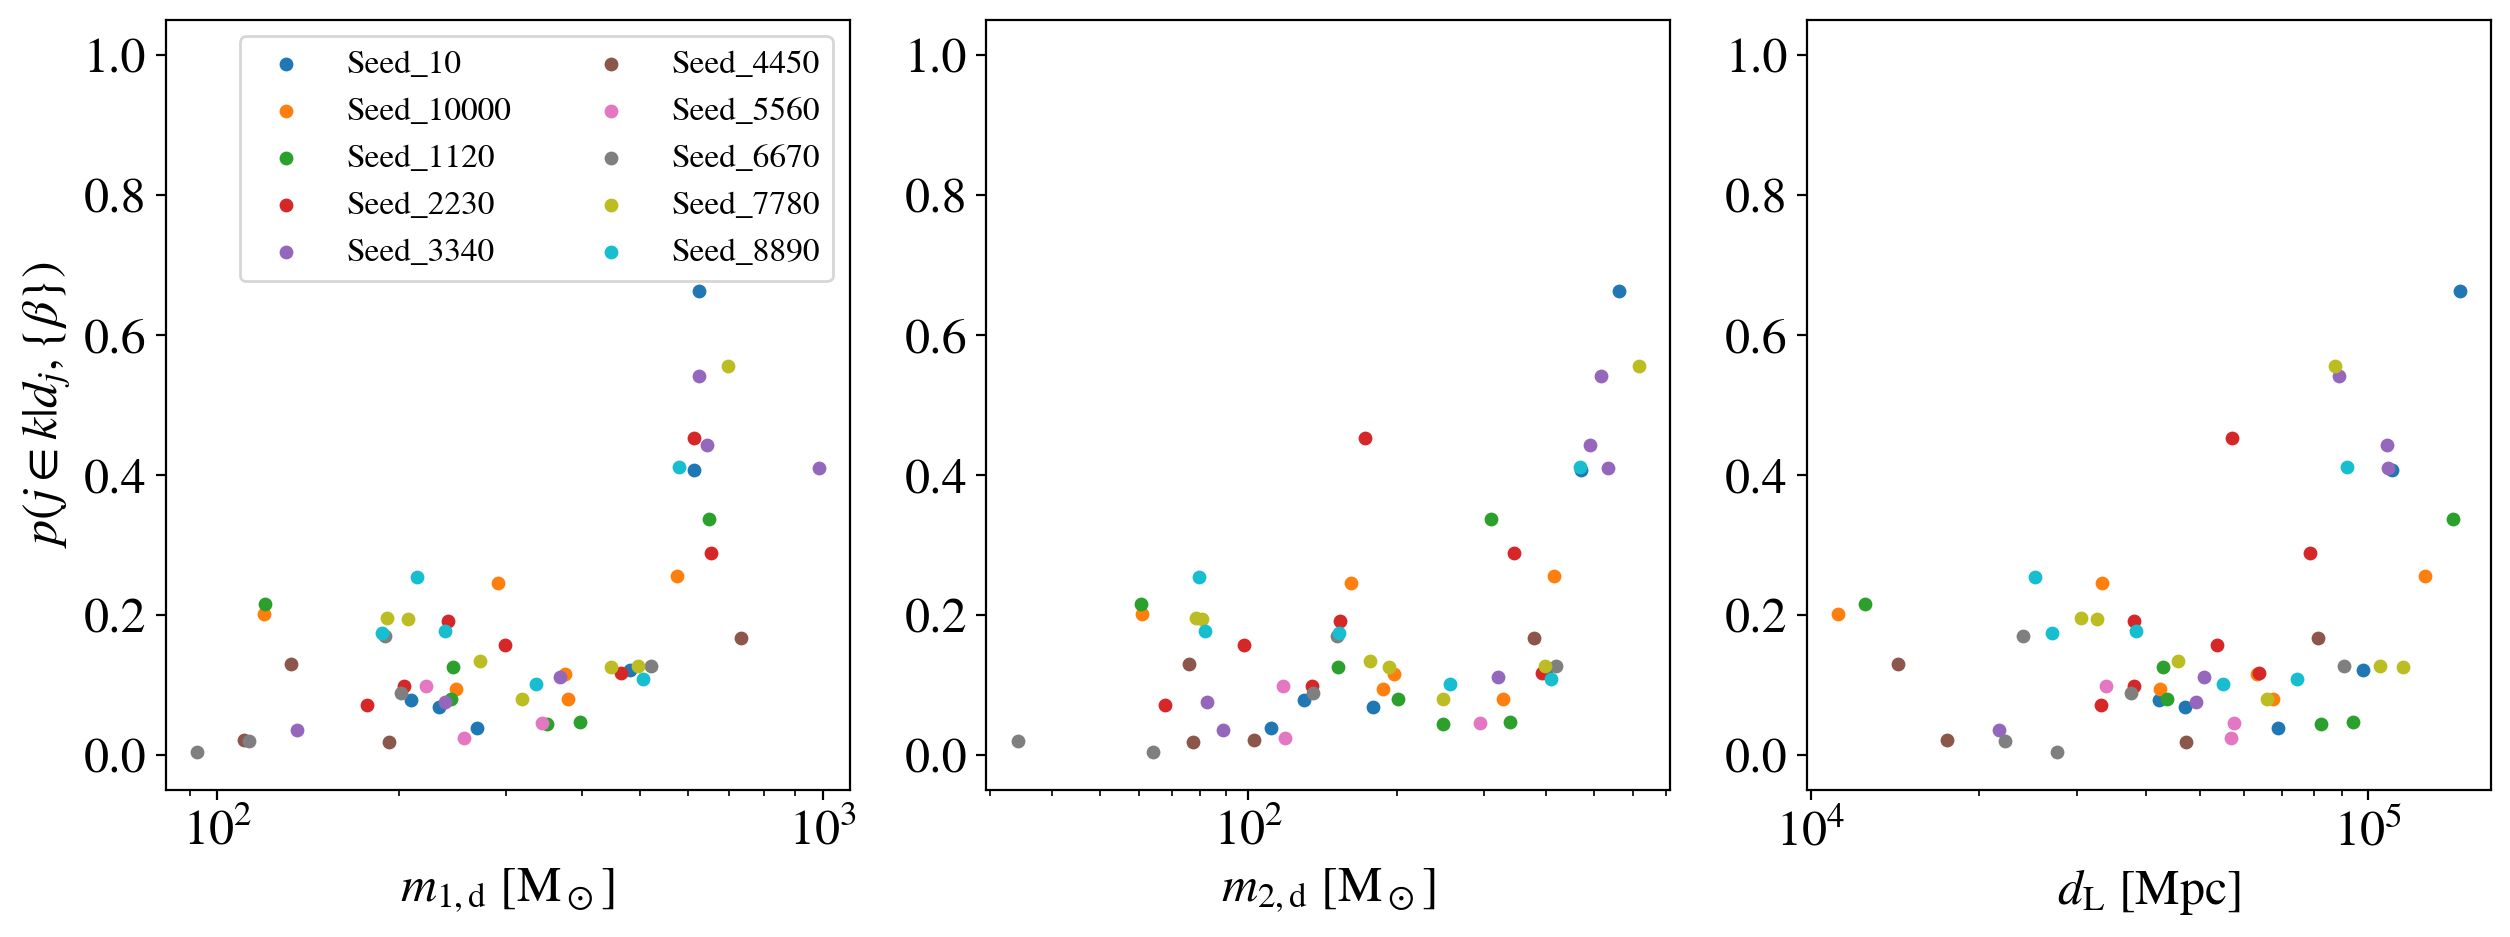

In [25]:
fig, ax1 = plt.subplots(1,3,figsize=(15,5))



corner_lbs = ['$m_{1,\\mathrm{d}}$ [M$_\\odot$]', '$m_{2,\\mathrm{d}}$ [M$_\\odot$]', '$d_{\mathrm{L}}$ [Mpc]']


thr_dec_pess = [0.1]

N2 = len(np.array(p_PopIII_arr_popI))
print(N2)

prec_all = []
recall_all = []
TP_all = []
FN_all = []
FP_all = []

for i in range(len(Seeds[:max_seed])):
    N3 = len(np.array(p_PopIII_arr_seed_all[i]))
    print('total number of sources', N3)
    
    for y in range(len(corner_lbs)):

        popIII_seed_point_y = []
        for i_pred in range(len(p_PopIII_arr_seed_all[i])):
            popIII_seed_point_y.append(np.sum(
                apply_prior(np.array(all_predictions_seed_all[i][i_pred]),N3,N2))/1000)
        #print(popIII_seed_point_y)
        
        popI_point_y = []
        for i_pred in range(len(p_PopIII_arr_popI)):
            popI_point_y.append(np.sum(apply_prior(np.array(all_predicitions_popI[i_pred]),N3,N2))/1000)
        
        
        ax1[y].scatter(medians_arr_seed_all[i][:,y],
                      
           #  apply_prior(np.array(p_PopIII_arr_seed_all[i]),N3,N2),
            popIII_seed_point_y,
                       
             marker = 'o', s = 20,
            label = 'Seed_'+str(Seeds[i]), alpha = 1,
                      #facecolor = 'darkblue',edgecolors='w',
                        linewidth = 0.5)

        ax1[y].set_xscale('log')
        #ax1[i,y].set_yscale('log')
        ax1[y].set_ylim([-0.05,1.05])
        #ax1[i,y].grid(True, which="both")

        #if i == 2:
        ax1[y].set_xlabel(corner_lbs[y])
        if y == 0:
            ax1[y].set_ylabel(r'$p(j\in k | d_j, \{\beta\})$')
        #ax1[i,y].set_title(Pop_model[i])

        # just for the first parameter
        if y == 0:
            #p_PopIII_tot = np.concatenate([apply_prior(np.array(p_PopIII_arr_popI),N3,N2),
            #                            apply_prior(np.array(p_PopIII_arr_seed_all[i]),N3,N2)])
            p_PopIII_seed_tot = np.concatenate([popI_point_y, popIII_seed_point_y])
            correct_tot = np.concatenate([np.zeros(len(p_PopIII_arr_popI)),
                                          np.ones(len(p_PopIII_arr_seed_all[i]))]) 
            
            TP_arrarr = []
            FP_arrarr = []
            TN_arrarr = []
            FN_arrarr = []
            for thr in thr_dec_pess:
                print('threshold = ', thr)
                TP = 0
                FP = 0
                TN = 0
                FN = 0
                for i_b, b in enumerate(p_PopIII_seed_tot): 
                    #print(b)
                    if b >= thr:
                        # counting false positive
                        if correct_tot[i_b] == 0:
                            FP += 1
                        # counting true positive
                        elif correct_tot[i_b] == 1:
                            TP += 1
                            
                    elif b <= thr:
                        # counting true negative
                        if correct_tot[i_b] == 0:
                            TN += 1
                        # counting false negative
                        elif correct_tot[i_b] == 1:
                            FN += 1
                            
                print('    ','TP', 'TN', 'FP', 'FN')
                print('    ',TP, TN, FP, FN)

                print(TP/N3*100)
                
                if TP == 0 and FP == 0:
                    prec_here = 0#'/'
                else:
                    prec_here =  TP/(TP+FP)
                print('    precision with custom threshold', prec_here) 
                if TP == 0 and FN == 0:
                    recall_here = 0#'/'
                else:
                    recall_here =  TP/(TP+FN)
                print('    recall with custom threshold', recall_here) 
                recall_all.append(recall_here)
                prec_all.append(prec_here)
                TP_all.append(TP)
                FN_all.append(FN)
                FP_all.append(FP)
    

    

ax1[0].legend(fontsize = font_value/1.5, ncols = 2)

plt.savefig(folder_out+'P_odds_pes_seeds_'+str(cut_on_rel[0])+'.pdf', 
                    format = 'pdf', bbox_inches = 'tight')
plt.savefig(folder_out+'P_odds_pes_seeds_'+str(cut_on_rel[0])+'.png', 
                    format = 'png', bbox_inches = 'tight',dpi = 300)

plt.show()

In [26]:
print('precision for all seeds:', prec_all)
print('average precision: ', np.mean(prec_all), np.std(prec_all))
print('average recall: ',np.mean(recall_all), np.std(recall_all))
print('TP for all seeds:',TP_all)
print('average number of TP:', np.mean(TP_all), np.std(TP_all))
print('average number of FN:',np.mean(FN_all), np.std(FN_all))

# this is a bit biased since the population of Pop.I-II BBHs is kept fixed
print('average number of FP:', np.mean(FP_all), np.std(FP_all))

precision for all seeds: [0.5, 0.5714285714285714, 0.5, 0.5555555555555556, 0.5714285714285714, 0.6666666666666666, 0, 0.6666666666666666, 0.6, 0.6666666666666666]
average precision:  0.5298412698412698 0.1864722019126921
average recall:  0.5804761904761905 0.25966531747136673
TP for all seeds: [3, 4, 3, 5, 4, 2, 0, 2, 6, 6]
average number of TP: 3.5 1.8027756377319946
average number of FN: 2.1 0.9433981132056604
average number of FP: 2.5 1.284523257866513


In [29]:
Pop_model_manual = ['fiducial']
#cut_on_rel = [0.3]

c = cut_on_rel[0]

for i_p, p in enumerate(Pop_model_manual):
    print(p)
    #figure_2 = plt.figure(figsize=(10,10))
    #p_PopIII_arr_popI_manual = manual_clf(p, c, 'Pop.I')
    _, _, _, medians_arr_manual_popI, all_predictions_manual_popI = check_posteriors(p, c, 'Pop.I', priors[0], indeces_to_use_all[i_p], manual_option = True)


Pop_model_manual = ['fiducial']
#cut_on_rel = [0.3]
c = cut_on_rel[0]
for i_p, p in enumerate(Pop_model_manual):
    print(p)
    #figure_2 = plt.figure(figsize=(10,10))
    #p_PopIII_arr_popIII_manual = manual_clf(p, c, 'Pop.III')
    _, _, _, medians_arr_manual_popIII, all_predictions_manual_popIII = check_posteriors(p, c, 'Pop.III', priors[0], indeces_to_use_all[i_p], manual_option = True)


fiducial
index used
3420
number of instances 3420
number of samples for each instance 1000


100%|█████████████████████████████████████| 3420/3420 [00:01<00:00, 1809.19it/s]


fiducial
[ 61 421 223 340 423 191  52 173 342 299 305 387 263 360 440 442 125 149
  14 249 275 260 262 184 347 370 168 129 291  39  50 361 431  38 306 151
 422 101  25 156 403  91 343 169 432  79 329 446 455 336 354  99  64 222
 330  48 365 208   4  69 318  73 108 159  22 200 325 441 195 416 433 250
 102 226 227 271 321 424 353 280 369  13 257 258  20  10 350 461 390 188
 395 317 259 332 246  28  35 296 279 219 301 132 284 134 411 363 122 351
   3  63 339 128 216 206 161 352 180  33  76 210 240 220  72  45 148 384
 104 133 313 118 112 190  96 451 320 452 166 372 261]
number of instances 139
number of samples for each instance 1000


100%|███████████████████████████████████████| 139/139 [00:00<00:00, 1868.04it/s]


N3 =  3027
N2 =  3420
3559
shape of array x =  (3559,)


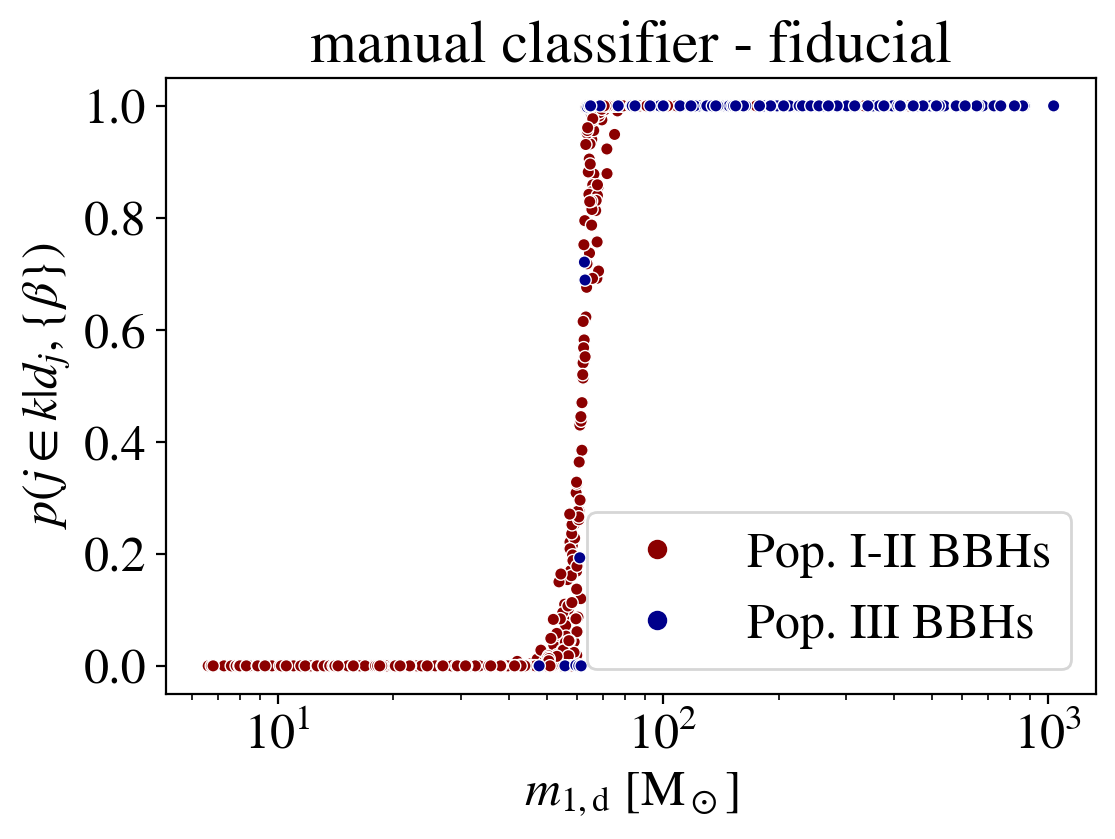

threshold =  0
Manual
     TP TN FP FN
     139 0 3420 0
    precision with custom threshold 0.039055914582747965

threshold =  0.1
Manual
     TP TN FP FN
     134 2646 774 5
    precision with custom threshold 0.14757709251101322

threshold =  0.5
Manual
     TP TN FP FN
     133 2691 729 6
    precision with custom threshold 0.154292343387471

threshold =  0.7
Manual
     TP TN FP FN
     132 2703 717 7
    precision with custom threshold 0.15547703180212014

threshold =  0.9
Manual
     TP TN FP FN
     131 2725 695 8
    precision with custom threshold 0.1585956416464891



In [30]:
# Here we apply the manual classifier on the imbalanced case.

N2 = len(medians_arr_manual_popI)
print('N3 = ',N3)
N3 = len(medians_arr_manual_popIII)
print('N2 = ', N2)


p_PopIII_arr_popI_manual_after_prior = []
for pp in range(N2):
    p_PopIII_single_manual = []
    for ipsm in all_predictions_manual_popI[pp]:
        p_PopIII_single_manual.append(apply_prior(ipsm,N3,N2))
        
    p_PopIII_arr_popI_manual_after_prior.append(np.sum(p_PopIII_single_manual)/1000)
        

p_PopIII_arr_popIII_manual_after_prior = []
for pp in range(N3):
    p_PopIII_single_manual = []
    for ipsm in all_predictions_manual_popIII[pp]:
        p_PopIII_single_manual.append(apply_prior(ipsm,N3,N2))
        
    p_PopIII_arr_popIII_manual_after_prior.append(np.sum(p_PopIII_single_manual)/1000)
#print(p_PopIII_arr_popIII_manual_after_prior)

p_PopIII_tot_manual = np.concatenate([p_PopIII_arr_popI_manual_after_prior,
                                      p_PopIII_arr_popIII_manual_after_prior])
#print(len(p_PopIII_tot_manual))

correct_tot_manual = np.concatenate([np.zeros(len(p_PopIII_arr_popI_manual_after_prior)),
                                     np.ones(len(p_PopIII_arr_popIII_manual_after_prior))])

print(len(correct_tot_manual))

all_points_x = np.concatenate([np.array(medians_arr_manual_popI[:,0]),
                               np.array(medians_arr_manual_popIII[:,0])
                              ])
print('shape of array x = ', all_points_x.shape)
#print(all_points_x )
fig, ax1 = plt.subplots(1,1,figsize=(6,4))
all_colors = np.concatenate([['darkred'] * N2, ['darkblue'] * N3])
#print(len(all_colors))
all_symbols = np.concatenate([['o'] * N2, ['s'] * N3])   
#print(len(all_symbols))
all_labels = np.concatenate([['Pop. I-II BBHs'] * N2, ['Pop. III BBHs'] * N3])  
#print(len(all_labels))
arr = np.arange(len(all_points_x))
#print(arr)
#np.random.shuffle(arr)
#print(arr.shape)
#print('ind_rand = ', arr)
ax1.scatter(all_points_x[arr],
            p_PopIII_tot_manual[arr],
            c = all_colors[arr],
     marker = 'o', s = 20,
   label = all_labels[arr], 
                 alpha = 1,
             #facecolor = 'darkred', 
                 edgecolors = 'w',
               linewidth = 0.5 , 
                 zorder = 2 
                )

ax1.set_xscale('log')
line_1 = Line2D([0], [0], color='darkred',  marker = 'o',linewidth = 0 )
line_2 = Line2D([0], [0], color='darkblue',  marker = 'o',linewidth = 0)
labels = ['Pop. I-II BBHs', 'Pop. III BBHs']
ax1.legend([line_1,line_2], labels)#,loc = [0.6,0.6] )
#ax1.set_yscale('log')
ax1.set_ylim([-0.05,1.05])
#ax1[i,y].grid(True, which="both")
plt.title('manual classifier - fiducial')


ax1.set_ylabel(r'$p(j\in k | d_j, \{\beta\})$')
ax1.set_xlabel(r'$m_{1,\mathrm{d}}$ [M$_\odot$]')


plt.savefig(folder_out+'manual_clf_on_fiducial.pdf', format = 'pdf',bbox_inches = 'tight')
plt.show()



thr_dec_manual = [0,0.1,0.5,0.7,0.9]
for thr in thr_dec_manual:
    print('threshold = ', thr)
    print('Manual')
    TP_manual = 0
    FP_manual =  0
    TN_manual = 0
    FN_manual = 0
    for i_b, b in enumerate(p_PopIII_tot_manual): 
        #print(b,correct_tot_manual[i_b])
        if b >= thr:
            # counting false positive
            if correct_tot_manual[i_b] == 0:
                FP_manual += 1
            # counting true positive
            elif correct_tot_manual[i_b] == 1:
                TP_manual += 1
                
        elif b <= thr:
            # counting true negative
            if correct_tot_manual[i_b] == 0:
                TN_manual+= 1
            # counting false negative
            elif correct_tot_manual[i_b] == 1.:
                FN_manual += 1
                
    print('    ','TP', 'TN', 'FP', 'FN')
    print('    ',TP_manual, TN_manual, FP_manual, FN_manual)
    
    prec_here_manual =  TP_manual/(TP_manual+FP_manual)
    print('    precision with custom threshold', prec_here_manual) 
    print('')
    